In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, HTML
import csv
import os
import logging
import math
import re
import json
import seaborn as sns

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
PATH_TO_CSVS = 'data/raw'
PATH_TO_JSON = 'notebooks/descvar.json'

In [4]:
# https://stackoverflow.com/questions/46135839/auto-detect-the-delimiter-in-a-csv-file-using-pd-read-csv comme base
# detecte automatiquement le sep d'un fichier csv


def get_delimiter(file_path, bytes=4096):
    try:
        with open(file_path, 'r') as file:
            data = file.read(bytes)
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(data).delimiter
        return delimiter
    except Exception as e:
        logging.error(f"Erreur lors de la détection du délimiteur: {e}")
        return None

In [5]:
# lecture d'un fichier csv en essayant différents encodage.


def read_csv_file(file_path):
    if not os.path.exists(file_path):
        return None, False, f"Fichier non trouvé: {file_path}"
    
    delimiter = get_delimiter(file_path)
    if not delimiter:
        return None, False, f"Impossible de détecter le délimiteur pour le fichier: {file_path}"
    
    encodings = ['utf-8', 'latin1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, low_memory=False, encoding=encoding, delimiter=delimiter)
            return df, True, None
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            logging.warning(f"Erreur avec l'encodage {encoding} pour le fichier {file_path}: {e}")
    
    return None, False, f"Impossible de lire le fichier {file_path} avec les encodages: {encodings}."

In [6]:
# chargement des datasets dans des listes


def load_datasets(prefixes, years, base_path= PATH_TO_CSVS):
    dataframes = []
    
    for prefix in prefixes:
        datasets = []
        for year in years:
            connector = '_' if year <= 2016 else '-'
            file_name = os.path.join(base_path, f'{prefix}{connector}{year}.csv')
            df, success, error = read_csv_file(file_name)
            if success:
                datasets.append({file_name: df})
            else:
                logging.error(error)
        dataframes.append(datasets)
    
    return dataframes

In [7]:
years = list(range(2005, 2023))
prefixes= ['caracteristiques', 'lieux', 'usagers', 'vehicules']

dataframes = load_datasets(prefixes, years)

# log
for prefix, df_list in zip(prefixes, dataframes):
        logging.info(f'{prefix}: {len(df_list)} datasets chargés.')

logging.info(f'Total datasets chargés: {sum(len(dfs) for dfs in dataframes)}.')

2024-11-25 11:12:12,173 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2005.csv: 'utf-8' codec can't decode byte 0xe9 in position 13: invalid continuation byte
2024-11-25 11:12:12,376 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2006.csv: 'utf-8' codec can't decode byte 0xb0 in position 6: invalid start byte
2024-11-25 11:12:12,551 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2007.csv: 'utf-8' codec can't decode byte 0xe9 in position 1: invalid continuation byte
2024-11-25 11:12:12,705 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2008.csv: 'utf-8' codec can't decode byte 0xf4 in position 17: invalid continuation byte
2024-11-25 11:12:12,948 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2010.csv: 'utf-8' codec can't decode byte 0xe9 in position 8: invalid continuation byte
2024-11-25 11:12:13,106 - WARN

In [8]:
def extract_year(file_name):
    match = re.search(r'(\d{4})\.csv$', file_name)
    if match:
        return match.group(1)
    else:
        return None

In [9]:
#génère le menu
def generate_navigation_menu(columns, dataset_name):
    links = [f'<a href="#{dataset_name}_{col}">{col}</a>' for col in columns]
    return f'<div id="menu_{dataset_name}"><h2>Menu {dataset_name}</h2><ul>{"".join(f"<li>{link}</li>" for link in links)}</ul></div>'

In [18]:
# Fonction pour générer des résumés des datasets
def summarize_dataset(dataset_dict, dataset_name):
    summary = {}
    
    for year, df in dataset_dict.items():
        dataset_key = f"{dataset_name}_{year}"
        summary[dataset_key] = {
            'Dataset Name': dataset_key,
            'Total Rows': df.shape[0],
            'Total Columns': df.shape[1],
            'Missing Values (%)': df.isna().mean().round(4) * 100,
            'Most Frequent Values': df.mode().iloc[0]
        }
        
        # Affichage des résumés
        print(f"Résumé pour {dataset_key}:")
        print(f"Total Rows: {summary[dataset_key]['Total Rows']}, Total Columns: {summary[dataset_key]['Total Columns']}")
        print(f"Pourcentage de valeurs manquantes par colonne:\n{summary[dataset_key]['Missing Values (%)']}")
        print(f"Valeurs les plus fréquentes:\n{summary[dataset_key]['Most Frequent Values']}")
        print("="*50)

        # Affichage d'un barplot des valeurs manquantes
        plt.figure(figsize=(12, 6))
        missing_values = summary[dataset_key]['Missing Values (%)']
        missing_values[missing_values > 0].sort_values(ascending=False).plot(kind='bar', color='orange')
        plt.title(f'Pourcentage de valeurs manquantes par colonne - {dataset_key}')
        plt.xlabel('Colonnes')
        plt.ylabel('Pourcentage de valeurs manquantes (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    return summary

In [11]:
#création d'une grille de boxplot
def create_boxplot_grid(column, datasets):

    if not any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        logging.info(f"La colonne {column} n'est pas numérique.")
        return

    n_datasets = len(datasets)
    n_cols = 5
    n_rows = math.ceil(n_datasets / n_cols)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 2), squeeze=False)
    fig.suptitle(f'Boxplots pour: {column}', fontsize=16)
    
    for ax, dataset in zip(axes.flatten(), datasets):
        for file_name, df in dataset.items():
            if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
                ax.boxplot(df[column].dropna(), vert=True)
                ax.set_title(extract_year(file_name))
                ax.set_xlabel(column)
                ax.set_ylabel('Valeurs')
    
    # Masquer les axes non utilisés
    for ax in axes.flatten()[n_datasets:]:
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [12]:
#création du bar plot pour visualiser la distribution des modalités.
def create_total_stacked_barplot(column, datasets, max_modalities=50):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                modality_count = df[column].value_counts()
                modality_counts[file_name] = modality_count
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Auncun bar plot généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = [extract_year(file_name) for file_name in modality_counts.keys()]
    
    for modality in all_modalities:
        for file_name in modality_counts.keys():
            count = modality_counts[file_name].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years).transpose()
    
    df_modalities.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='viridis')
    plt.title(f'{column}')
    plt.xlabel('Modalités')
    plt.ylabel('Count')
    plt.legend(title='Years', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [13]:
# evolution de la répartition 
def create_lineplot_evolution(column, datasets, max_modalities=12):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                year = extract_year(file_name)
                modality_count = df[column].value_counts(normalize=True) * 100
                if year not in modality_counts:
                    modality_counts[year] = modality_count
                else:
                    modality_counts[year] = modality_counts[year].add(modality_count, fill_value=0)
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Aucun graphique en ligne généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = sorted(modality_counts.keys())
    
    for modality in all_modalities:
        for year in years:
            count = modality_counts[year].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years)
    
    df_modalities.plot(kind='line', figsize=(15, 7), marker='o')
    plt.title(f'Evolution de la distribution {column}')
    plt.xlabel('Années')
    plt.ylabel('Proportion (%)')
    plt.legend(title='Modalités', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [14]:
# permet d'afficher les info depuis le json
def display_variable_info(col_name, dataset_name, descvar):
    dataset_name_upper = dataset_name.upper()
    if dataset_name_upper in descvar:
        section = descvar[dataset_name_upper]
        if col_name in section:
            details = section[col_name]
            if isinstance(details, dict):    
                description = details.get('description', 'Pas de description.')
                modalities = details.get('modalities', {})
                
                print(f"Description: {description}")
                if modalities:
                    print("\nModalités:")
                    for key, value in modalities.items():
                        print(f"- {key}: {value}")
            else:
                print(f"Description: {details}")
            return
    logging.info(f"Pas de description pour `{col_name}` dans la section `{dataset_name_upper}`.")

In [15]:
# analyse une colonne unique
def analyze_column(column, datasets, total_rows, dataset_name, descvar= None):
    column_results = []
    
    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                col_type = df[column].dtype
                col_mode = df[column].mode()[0] if not df[column].mode().empty else "N/A"
                null_proportion_file = df[column].isnull().mean() *100
                null_proportion_total = df[column].isnull().sum() / total_rows
                column_results.append([
                    extract_year(file_name), 
                    col_type, 
                    col_mode, 
                    null_proportion_file, 
                    null_proportion_total
                ])
    
    if column_results:
        display(HTML(f'<div id="{dataset_name}_{column}"><h2>Colonne: {column}</h2>'))
        print(f"lignes: {total_rows}\n")
        display_variable_info(column, dataset_name, descvar)
        print(tabulate(column_results, headers=[
            "Année", "Type", "Mode", 
            "Proportion valeurs nulles (fichier)", 
            "Proportion valeurs nulles (total)"
        ]))
        
        #if any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        create_boxplot_grid(column, datasets) 
        create_total_stacked_barplot(column, datasets)
        create_lineplot_evolution(column, datasets)

        display(HTML(f'<p><a href="#menu_{dataset_name}">Retour au menu</a></p></div>'))


In [16]:
# on analyse toutes les colonnes à la suite
def analyze_all_columns(datasets, dataset_name, descvar= None):
    
    logging.info(f'Chargement de {dataset_name}.')
    
    all_columns = set()

    for dataset in datasets: 
        for file_name, df in dataset.items():
            all_columns.update(df.columns)
    
    total_rows = sum(df.shape[0] for dataset in datasets for file_name, df in dataset.items())
    
    navigation_menu = generate_navigation_menu(all_columns, dataset_name) 
    display(HTML(navigation_menu))

    #traitement pour chaque colonne
    for column in all_columns:
        analyze_column(column, datasets, total_rows, dataset_name, descvar= descvar)
            

Résumé pour caracteristiques_data/raw\caracteristiques_2005.csv:
Total Rows: 87026, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.00
col         0.00
com         0.00
adr        19.29
gps        68.93
lat        69.04
long       69.04
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200500000001
an                  5.0
mois                6.0
jour               19.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr        AUTOROUTE A1
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


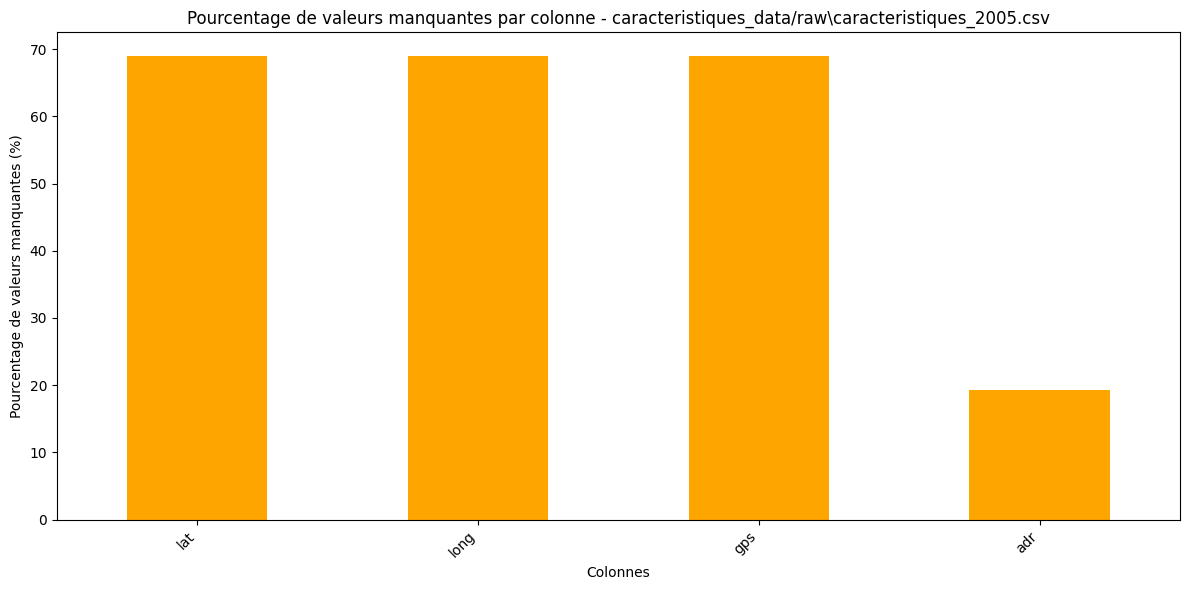

Résumé pour caracteristiques_data/raw\caracteristiques_2006.csv:
Total Rows: 82993, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.00
col         0.00
com         0.00
adr        13.41
gps        70.68
lat        70.77
long       70.77
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200600000001
an                  6.0
mois                6.0
jour               13.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr        AUTOROUTE A1
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


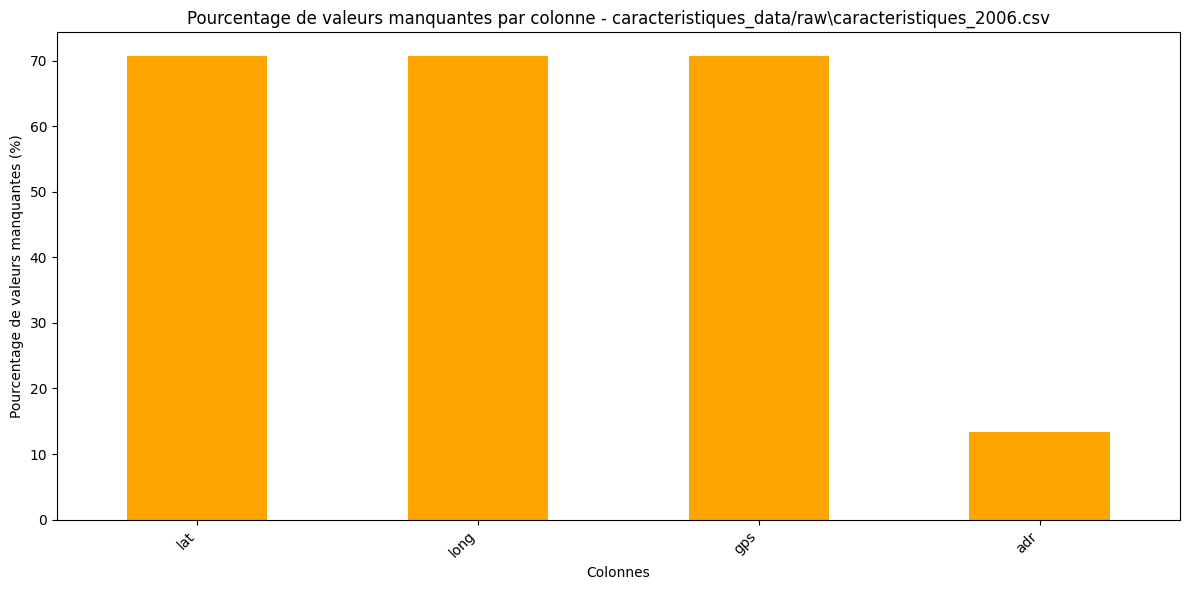

Résumé pour caracteristiques_data/raw\caracteristiques_2007.csv:
Total Rows: 83850, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.00
col         0.00
com         0.00
adr        17.84
gps        71.81
lat        71.91
long       71.91
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200700000001
an                  7.0
mois               10.0
jour                6.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr        AUTOROUTE A1
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


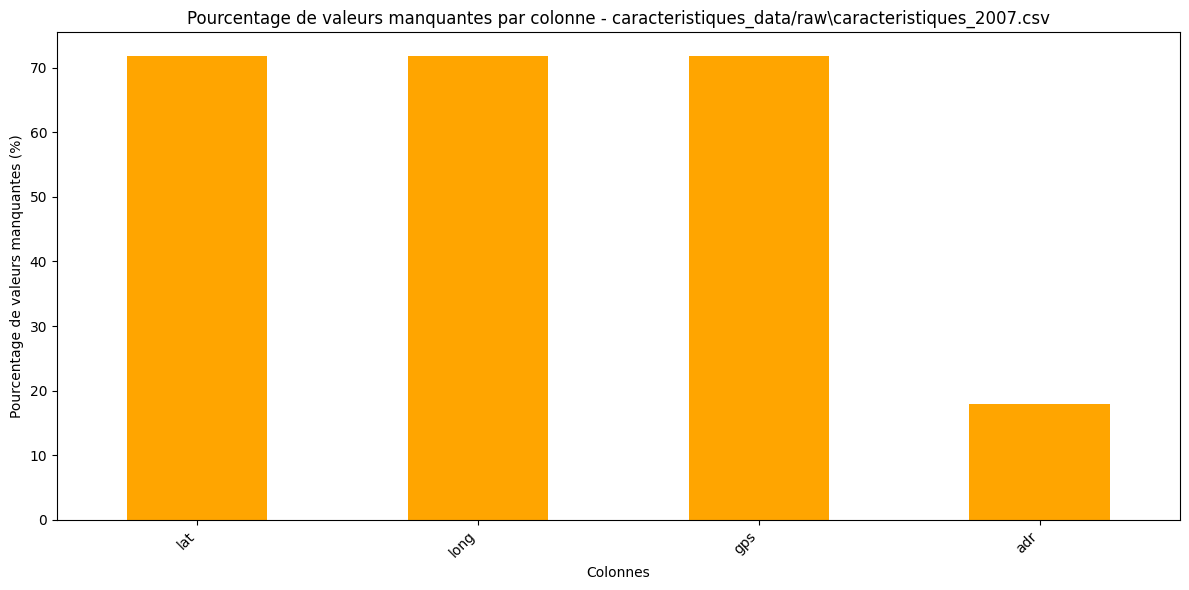

Résumé pour caracteristiques_data/raw\caracteristiques_2008.csv:
Total Rows: 76767, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.00
col         0.00
com         0.00
adr        19.38
gps        71.68
lat        71.81
long       71.81
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200800000001
an                  8.0
mois               10.0
jour                4.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr        AUTOROUTE A1
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


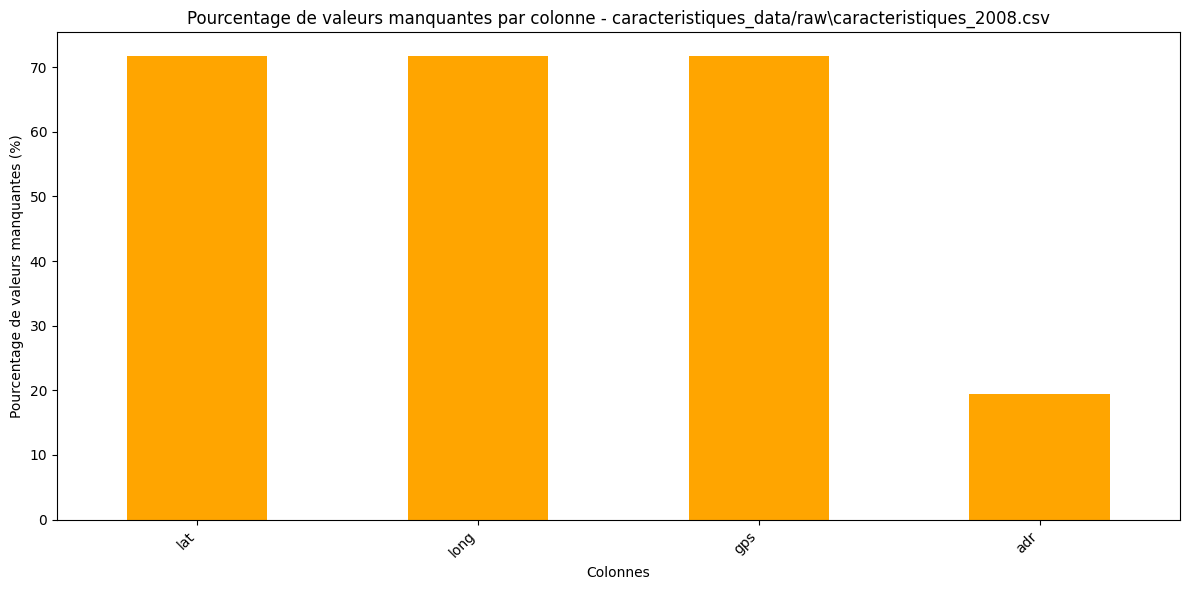

Résumé pour caracteristiques_data/raw\caracteristiques_2009.csv:
Total Rows: 74409, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.01
col         0.00
com         0.00
adr        17.31
gps        54.84
lat        54.98
long       54.98
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200900000001
an                  9.0
mois                6.0
jour               17.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                88.0
adr                 A13
gps                   M
lat                 4.0
long                  0
dep               750.0
Name: 0, dtype: object


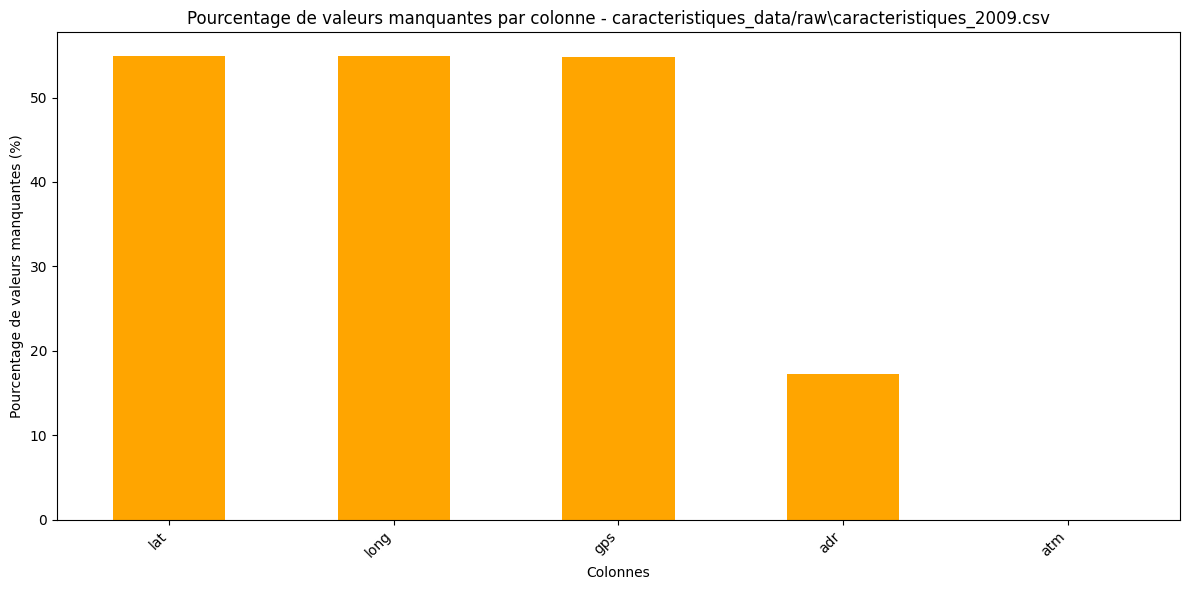

Résumé pour caracteristiques_data/raw\caracteristiques_2010.csv:
Total Rows: 69379, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.00
col         0.00
com         0.00
adr        16.63
gps        54.27
lat        54.51
long       54.51
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201000000001
an                 10.0
mois               10.0
jour               15.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr        AUTOROUTE A1
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


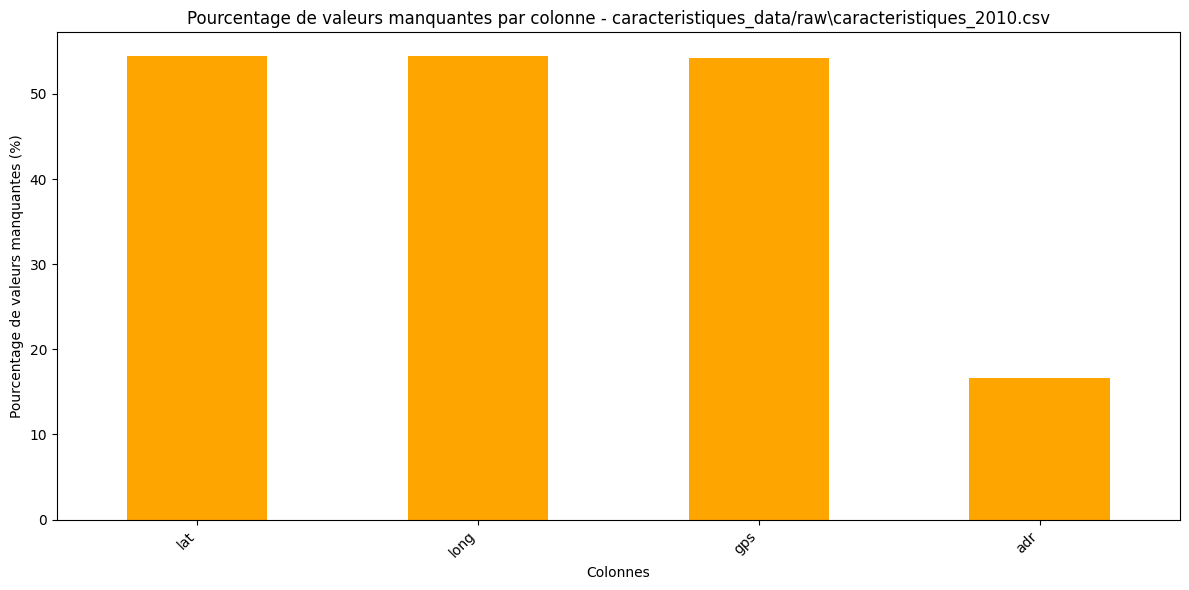

Résumé pour caracteristiques_data/raw\caracteristiques_2011.csv:
Total Rows: 66974, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.02
col         0.01
com         0.00
adr        16.30
gps        53.94
lat        54.17
long       54.17
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201100000001
an                 11.0
mois                5.0
jour                8.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr                 A13
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


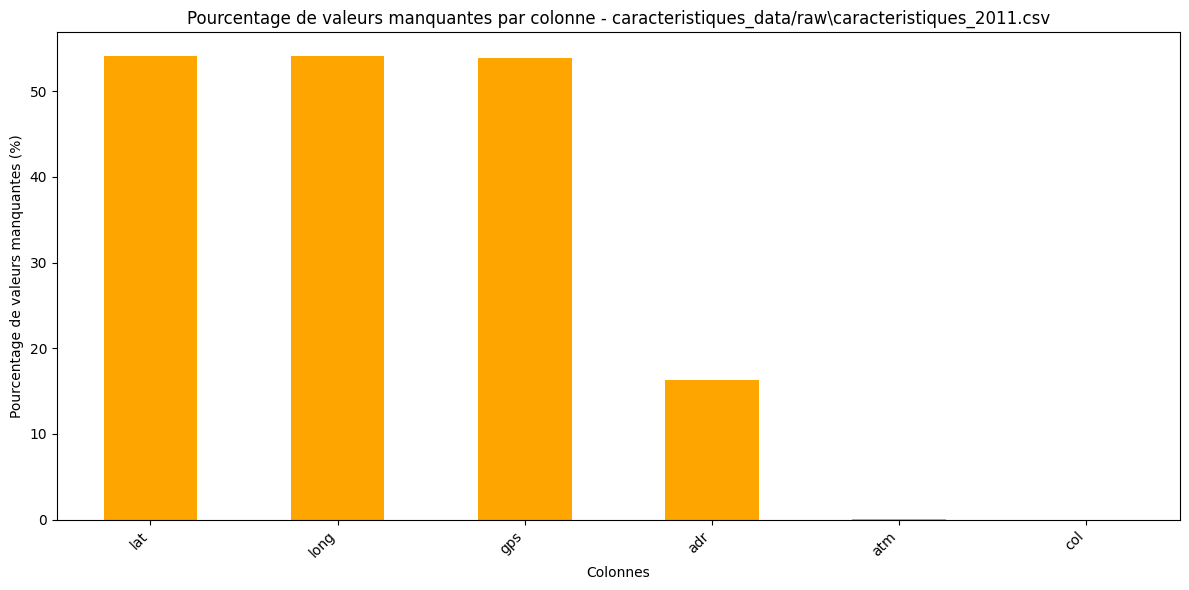

Résumé pour caracteristiques_data/raw\caracteristiques_2012.csv:
Total Rows: 62250, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.00
col         0.00
com         0.00
adr        15.96
gps        52.99
lat        55.24
long       55.25
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201200000001
an                 12.0
mois               10.0
jour               21.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr                 A13
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


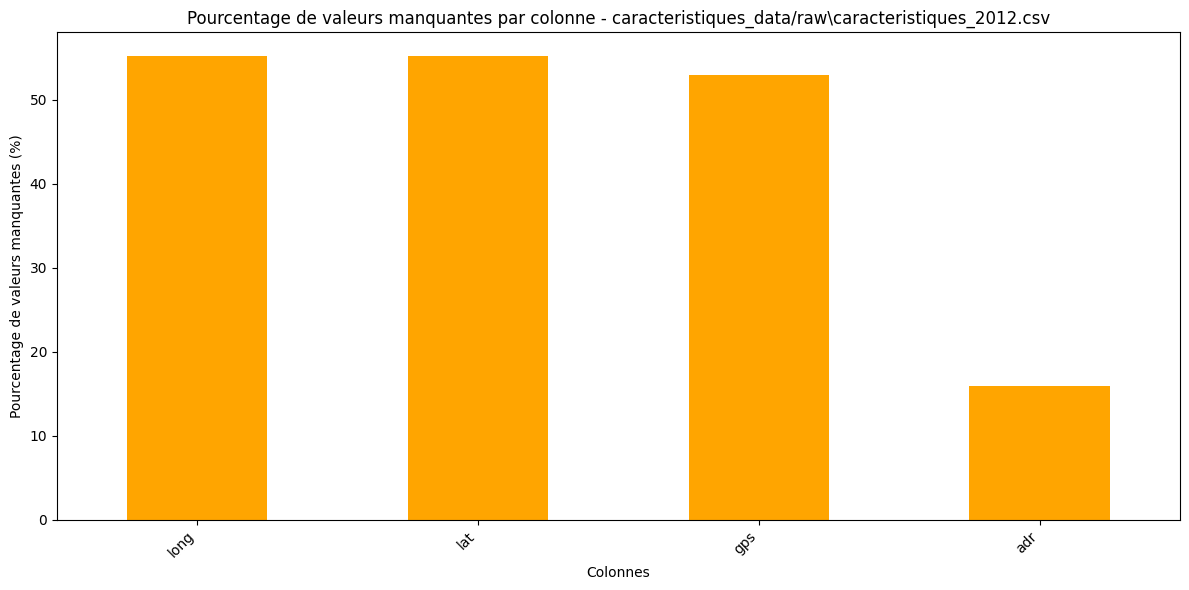

Résumé pour caracteristiques_data/raw\caracteristiques_2013.csv:
Total Rows: 58397, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.02
col         0.00
com         0.00
adr        16.01
gps        51.28
lat        51.76
long       51.76
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc     201300000001
an                  13.0
mois                 7.0
jour                 9.0
hrmn              1800.0
lum                  1.0
agg                  2.0
int                  1.0
atm                  1.0
col                  6.0
com                 55.0
adr        AUTOROUTE A86
gps                    M
lat                  0.0
long                 0.0
dep                750.0
Name: 0, dtype: object


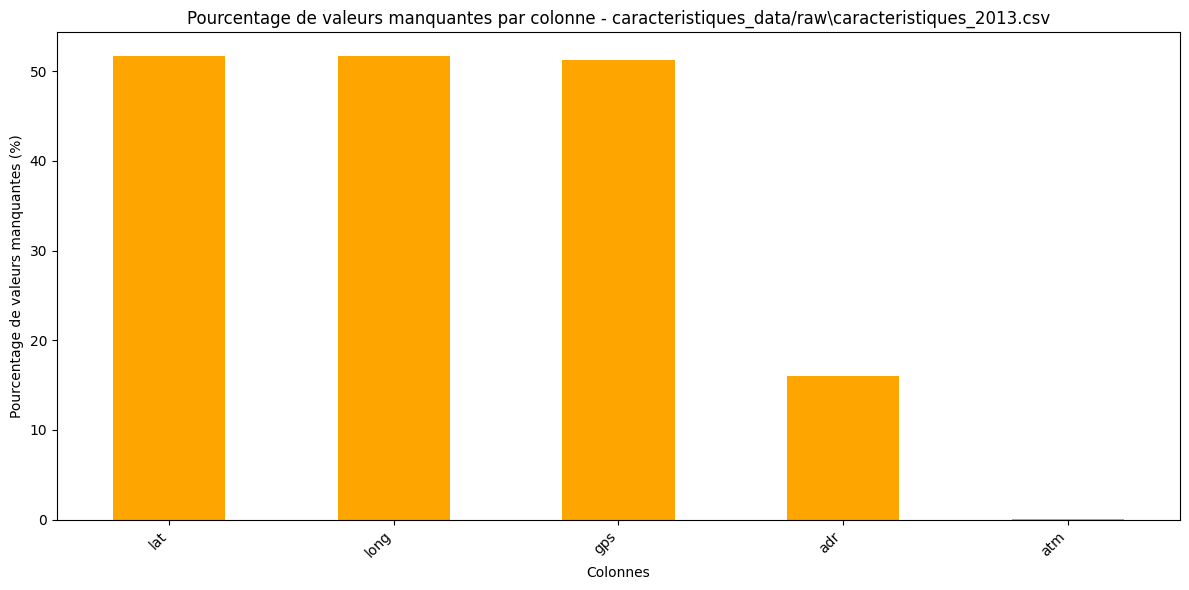

Résumé pour caracteristiques_data/raw\caracteristiques_2014.csv:
Total Rows: 59854, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.03
col         0.00
com         0.00
adr        16.04
gps        48.27
lat        48.91
long       48.91
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc     201400000001
an                  14.0
mois                10.0
jour                16.0
hrmn              1800.0
lum                  1.0
agg                  2.0
int                  1.0
atm                  1.0
col                  6.0
com                 55.0
adr        AUTOROUTE A86
gps                    M
lat                  0.0
long                 0.0
dep                750.0
Name: 0, dtype: object


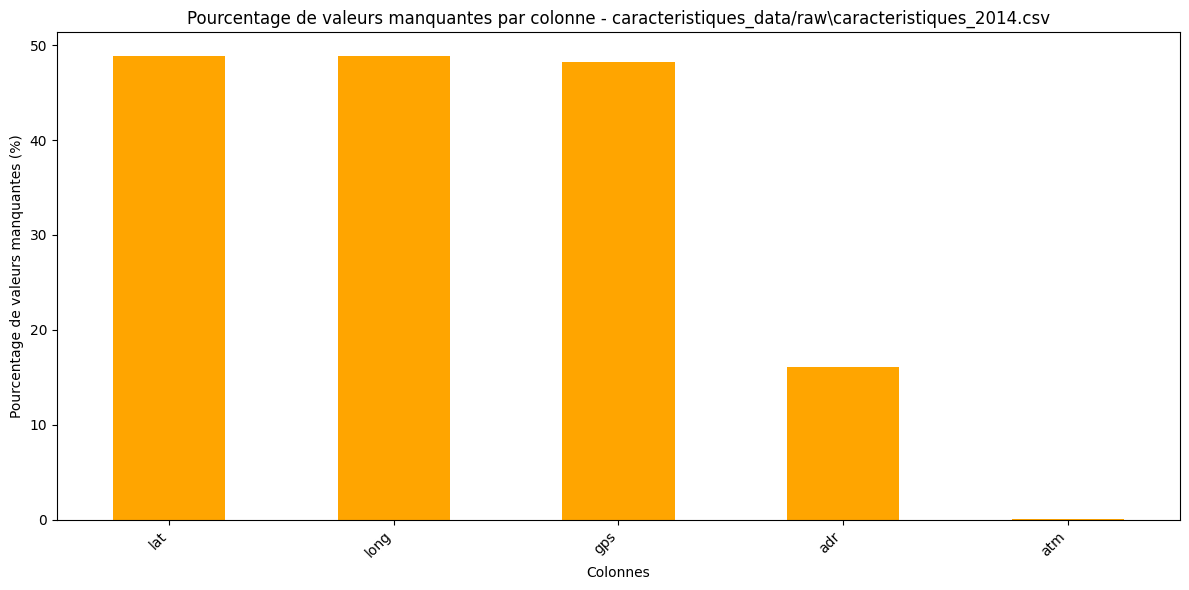

Résumé pour caracteristiques_data/raw\caracteristiques_2015.csv:
Total Rows: 58654, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.00
col         0.00
com         0.00
adr        16.02
gps        36.16
lat        36.72
long       36.72
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201500000001
an                 15.0
mois                6.0
jour               10.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr        AUTOROUTE A1
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


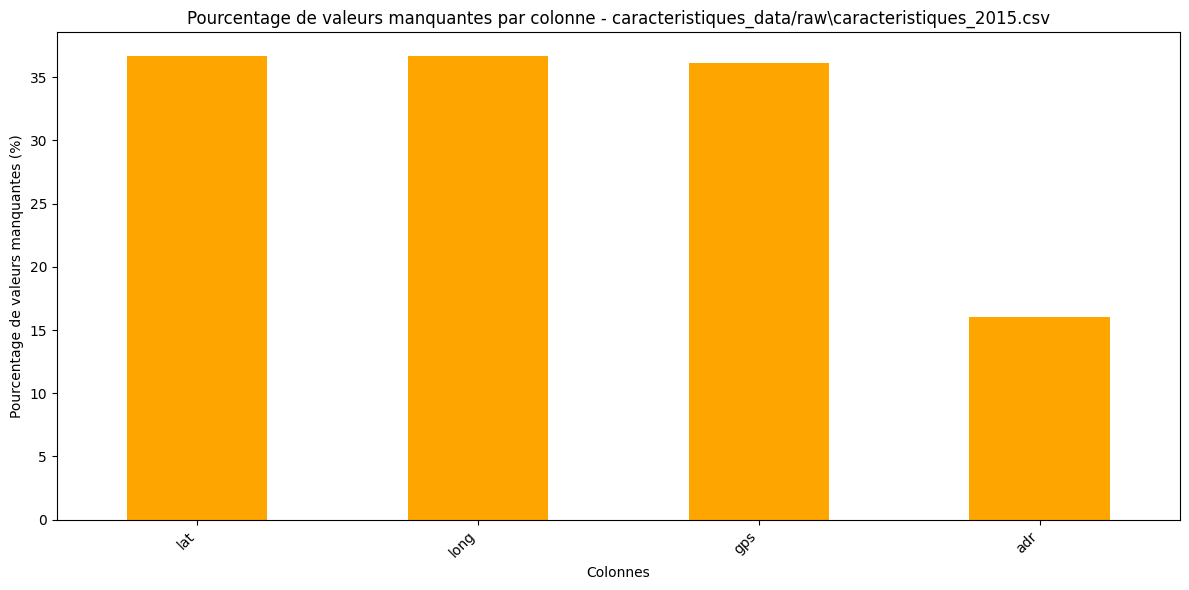

Résumé pour caracteristiques_data/raw\caracteristiques_2016.csv:
Total Rows: 59432, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.00
col         0.00
com         0.00
adr        15.43
gps        20.61
lat        21.62
long       21.62
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201600000001
an                 16.0
mois               10.0
jour                6.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr        AUTOROUTE A1
gps                   M
lat                 0.0
long                0.0
dep               750.0
Name: 0, dtype: object


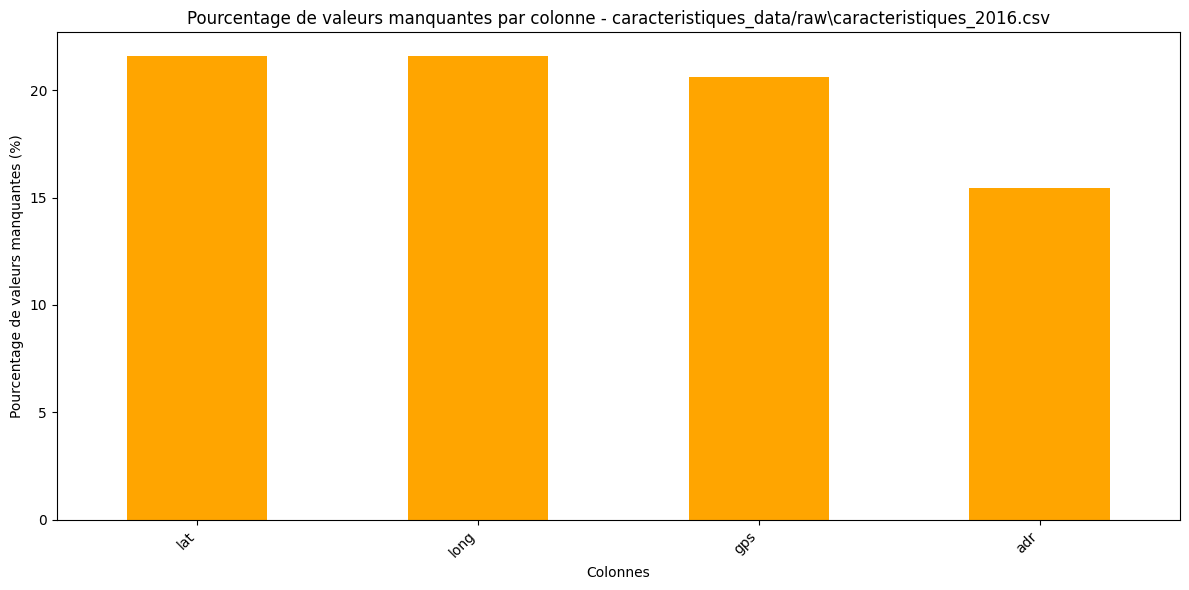

Résumé pour caracteristiques_data/raw\caracteristiques-2017.csv:
Total Rows: 60701, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
an          0.00
mois        0.00
jour        0.00
hrmn        0.00
lum         0.00
agg         0.00
int         0.00
atm         0.02
col         0.01
com         0.00
adr         1.35
gps         7.59
lat        12.74
long       12.74
dep         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201700000001
an                 17.0
mois                6.0
jour                7.0
hrmn             1800.0
lum                 1.0
agg                 2.0
int                 1.0
atm                 1.0
col                 6.0
com                55.0
adr        AUTOROUTE A1
gps                   M
lat           4800000.0
long           220000.0
dep               750.0
Name: 0, dtype: object


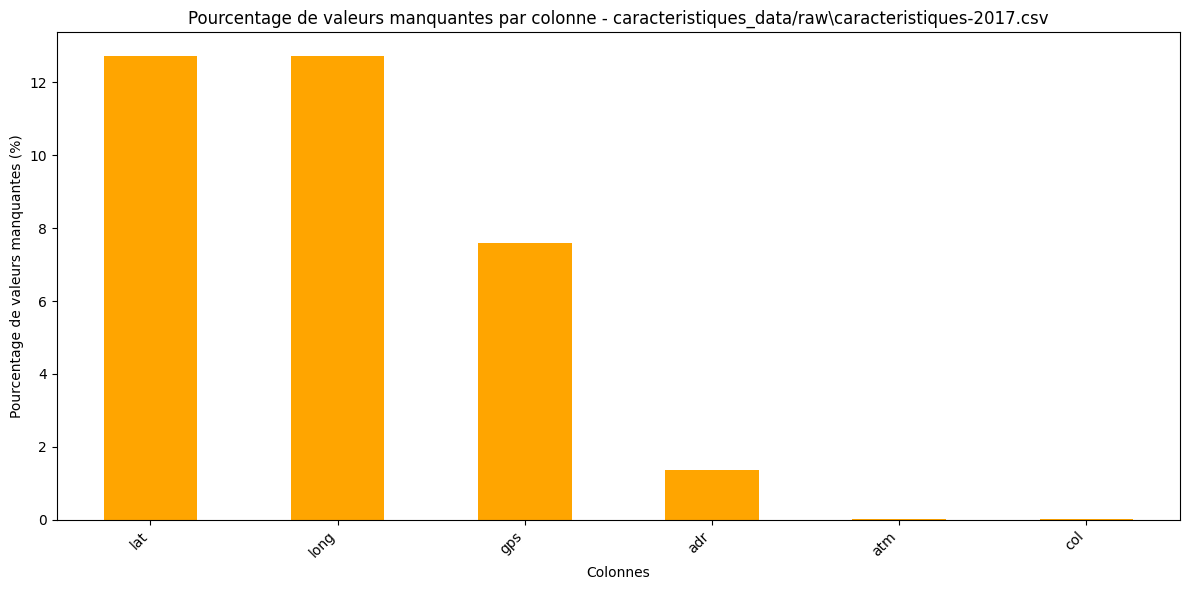

Résumé pour caracteristiques_data/raw\caracteristiques-2018.csv:
Total Rows: 57783, Total Columns: 16
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
an         0.00
mois       0.00
jour       0.00
hrmn       0.00
lum        0.00
agg        0.00
int        0.00
atm        0.01
col        0.00
com        0.00
adr        0.96
gps        0.09
lat        3.15
long       3.15
dep        0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc     201800000001
an                  18.0
mois                10.0
jour                12.0
hrmn              1800.0
lum                  1.0
agg                  2.0
int                  1.0
atm                  1.0
col                  6.0
com                 55.0
adr        AUTOROUTE A86
gps                    M
lat            4889276.0
long            228547.0
dep                750.0
Name: 0, dtype: object


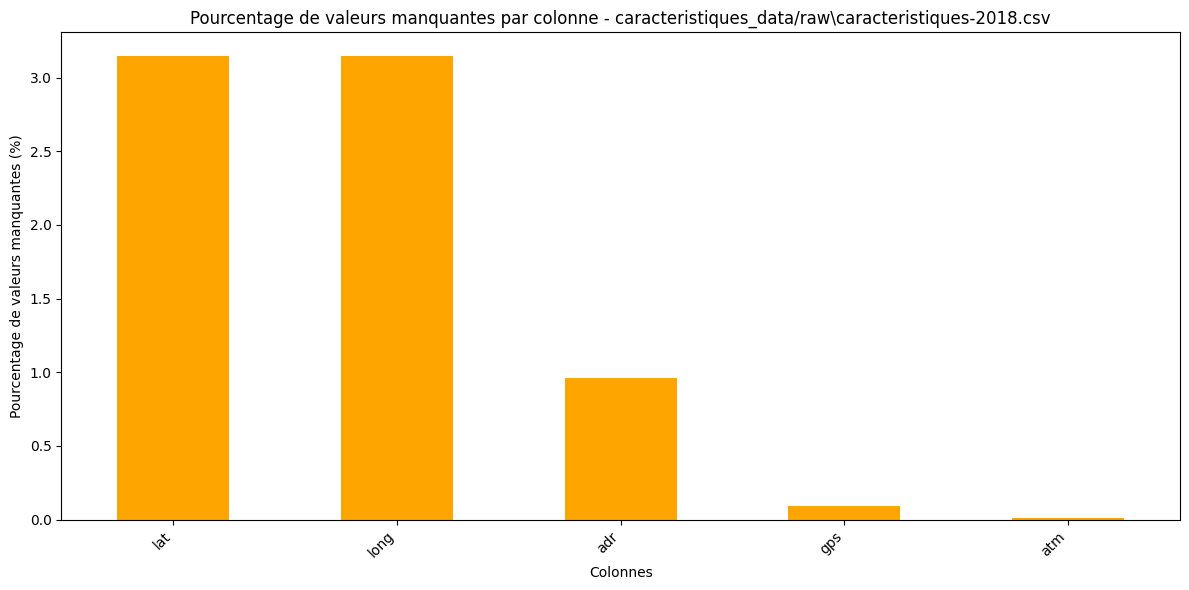

Résumé pour caracteristiques_data/raw\caracteristiques-2019.csv:
Total Rows: 58840, Total Columns: 15
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
jour       0.00
mois       0.00
an         0.00
hrmn       0.00
lum        0.00
dep        0.00
com        0.00
agg        0.00
int        0.00
atm        0.00
col        0.00
adr        0.73
lat        0.00
long       0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc     201900000001
jour                18.0
mois                 7.0
an                2019.0
hrmn               18:00
lum                  1.0
dep                   75
com                75116
agg                  2.0
int                  1.0
atm                  1.0
col                  6.0
adr        AUTOROUTE A86
lat           48,8100000
long           2,4400000
Name: 0, dtype: object


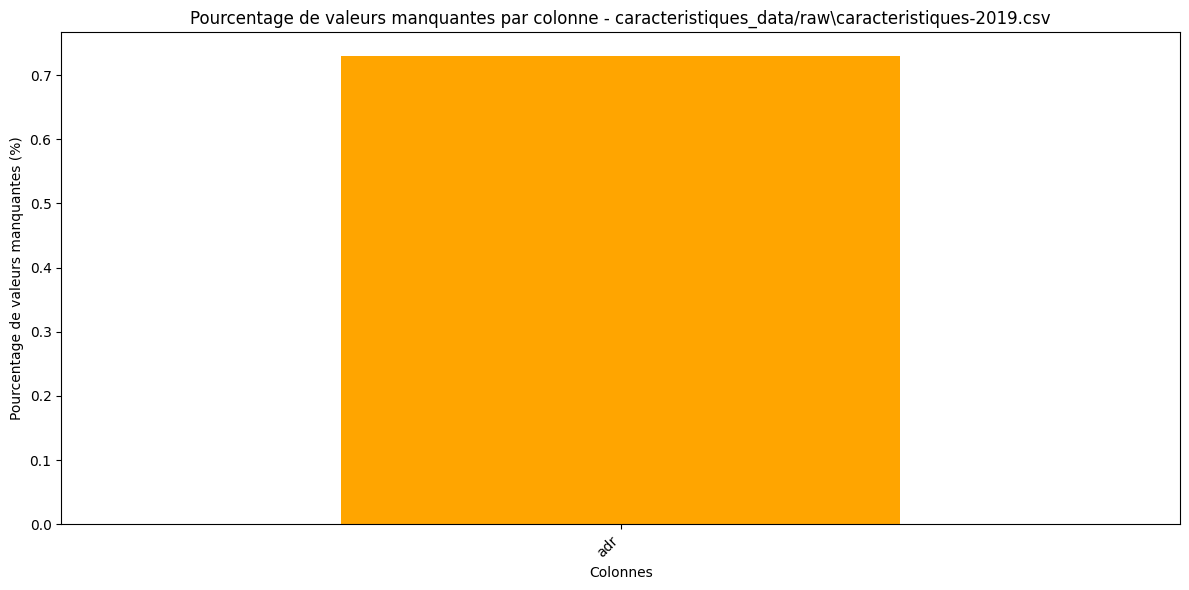

Résumé pour caracteristiques_data/raw\caracteristiques-2020.csv:
Total Rows: 47744, Total Columns: 15
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
jour       0.00
mois       0.00
an         0.00
hrmn       0.00
lum        0.00
dep        0.00
com        0.00
agg        0.00
int        0.00
atm        0.00
col        0.00
adr        0.75
lat        0.00
long       0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    202000000001
jour                6.0
mois                9.0
an               2020.0
hrmn              18:00
lum                 1.0
dep                  75
com               75116
agg                 2.0
int                 1.0
atm                 1.0
col                 3.0
adr                  A4
lat          43,1213200
long          5,9533100
Name: 0, dtype: object


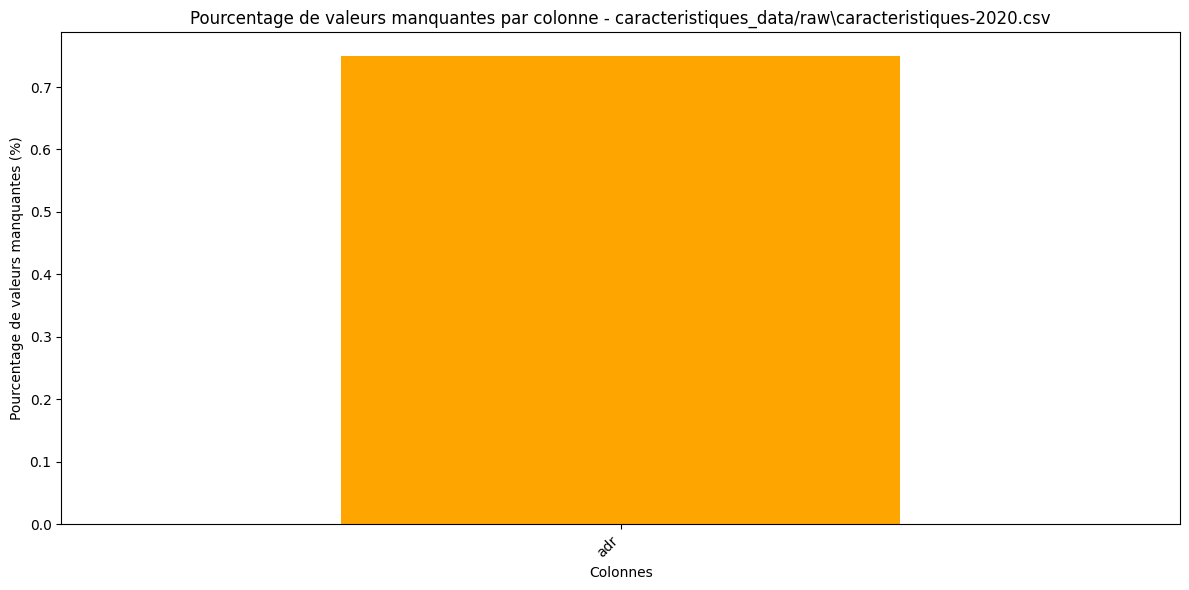

Résumé pour caracteristiques_data/raw\caracteristiques-2021.csv:
Total Rows: 56518, Total Columns: 15
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
jour       0.00
mois       0.00
an         0.00
hrmn       0.00
lum        0.00
dep        0.00
com        0.00
agg        0.00
int        0.00
atm        0.00
col        0.00
adr        1.01
lat        0.00
long       0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc        202100000001
jour                    9.0
mois                    6.0
an                   2021.0
hrmn                  18:00
lum                     1.0
dep                      75
com                   75116
agg                     2.0
int                     1.0
atm                     1.0
col                     3.0
adr           AUTOROUTE A86
lat          -17,5845220000
long        -149,5685780000
Name: 0, dtype: object


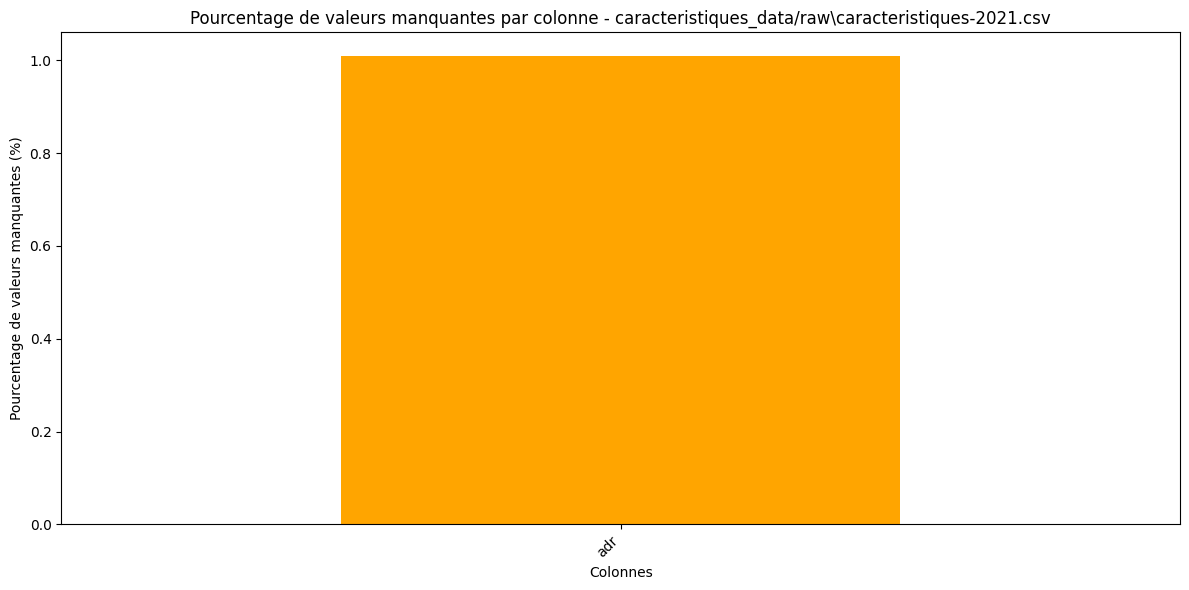

Résumé pour caracteristiques_data/raw\caracteristiques-2022.csv:
Total Rows: 55302, Total Columns: 15
Pourcentage de valeurs manquantes par colonne:
Accident_Id    0.00
jour           0.00
mois           0.00
an             0.00
hrmn           0.00
lum            0.00
dep            0.00
com            0.00
agg            0.00
int            0.00
atm            0.00
col            0.00
adr            2.23
lat            0.00
long           0.00
dtype: float64
Valeurs les plus fréquentes:
Accident_Id     202200000001
jour                    14.0
mois                     6.0
an                    2022.0
hrmn                   18:00
lum                      1.0
dep                       75
com                    75116
agg                      2.0
int                      1.0
atm                      1.0
col                      3.0
adr                       A4
lat            48,8172046066
long            2,4285178250
Name: 0, dtype: object


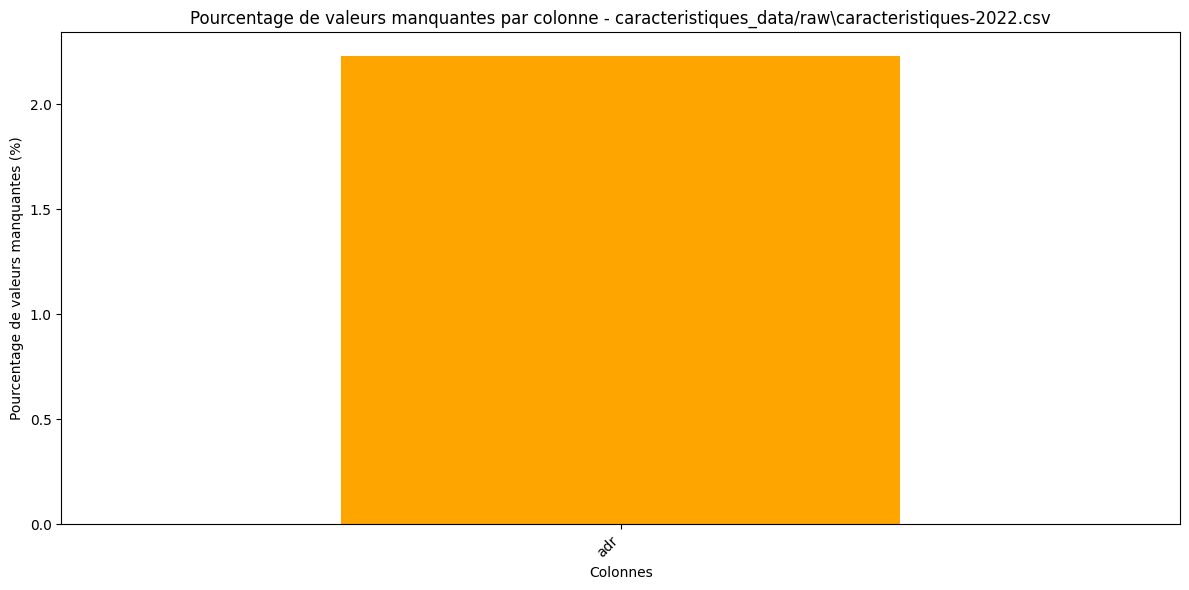

2024-11-25 11:19:49,255 - INFO - Chargement de caracteristiques.


lignes: 1176873

Description: Localisation :

Modalités:
- 1: Hors agglomération
- 2: En agglomération
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        2                                      0                                    0
   2006  int64        2                                      0                                    0
   2007  int64        2                                      0                                    0
   2008  int64        2                                      0                                    0
   2009  int64        2                                      0                                    0
   2010  int64        2                                      0                                    0
   2011  int64        2                                      0                                   

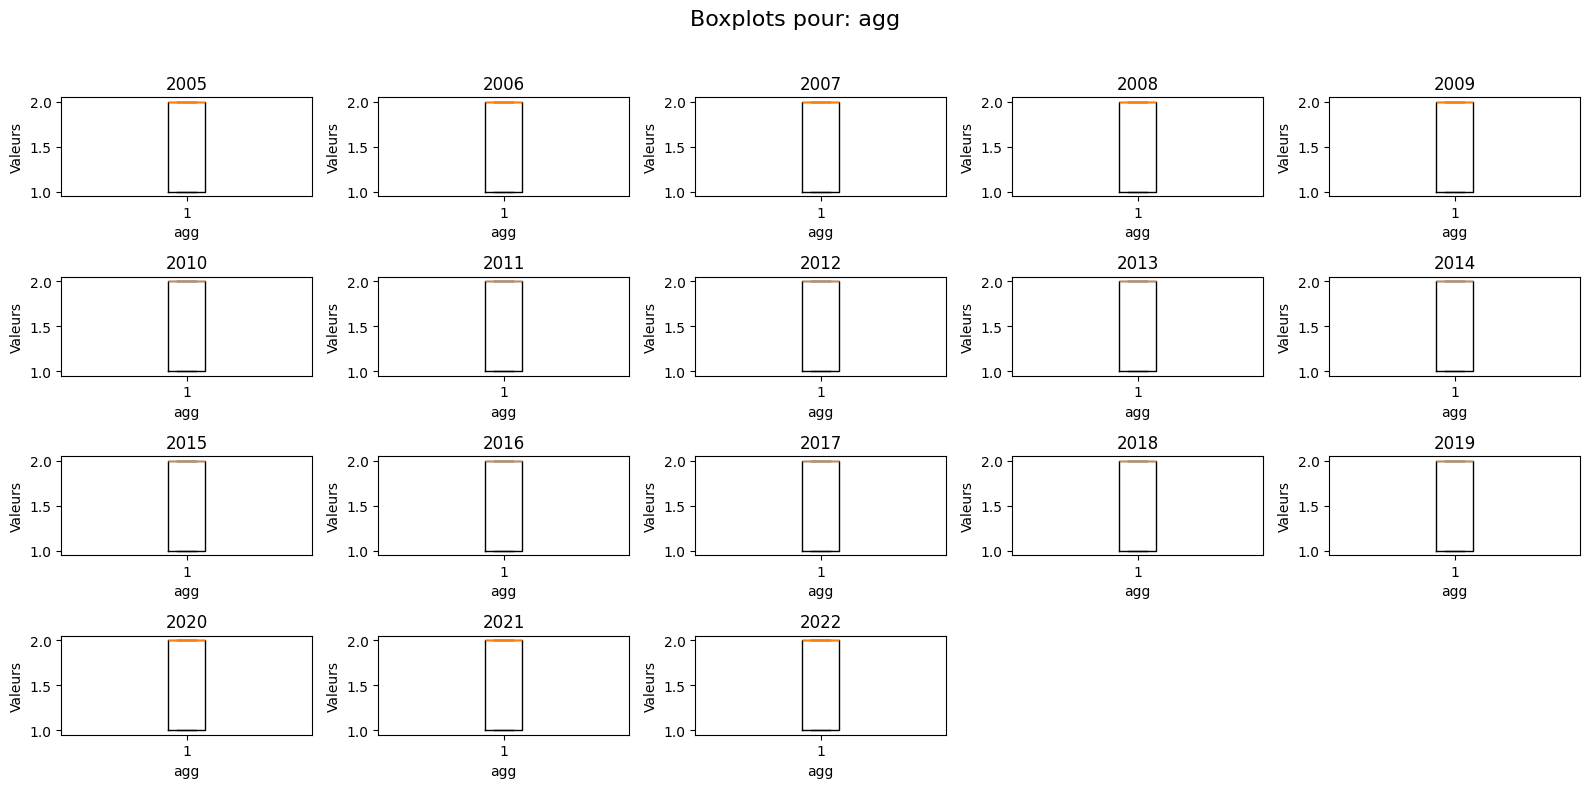

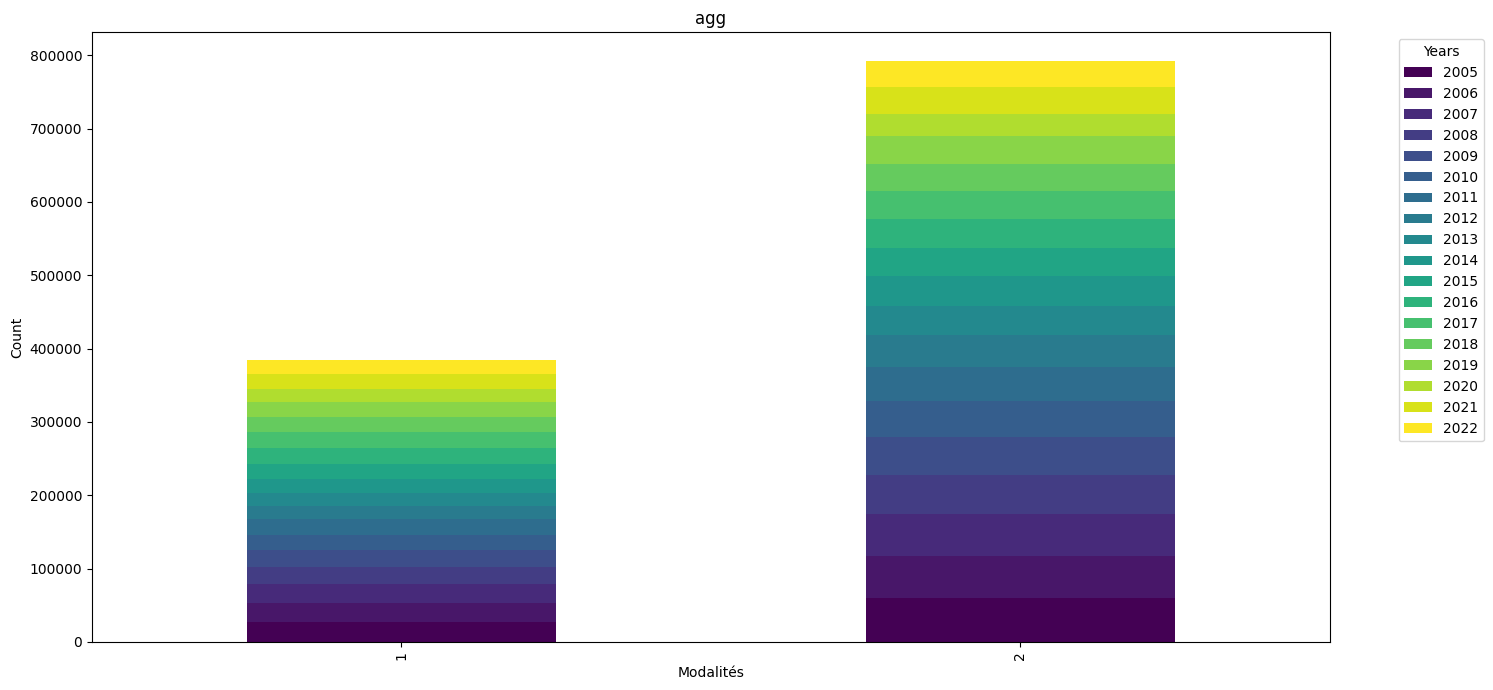

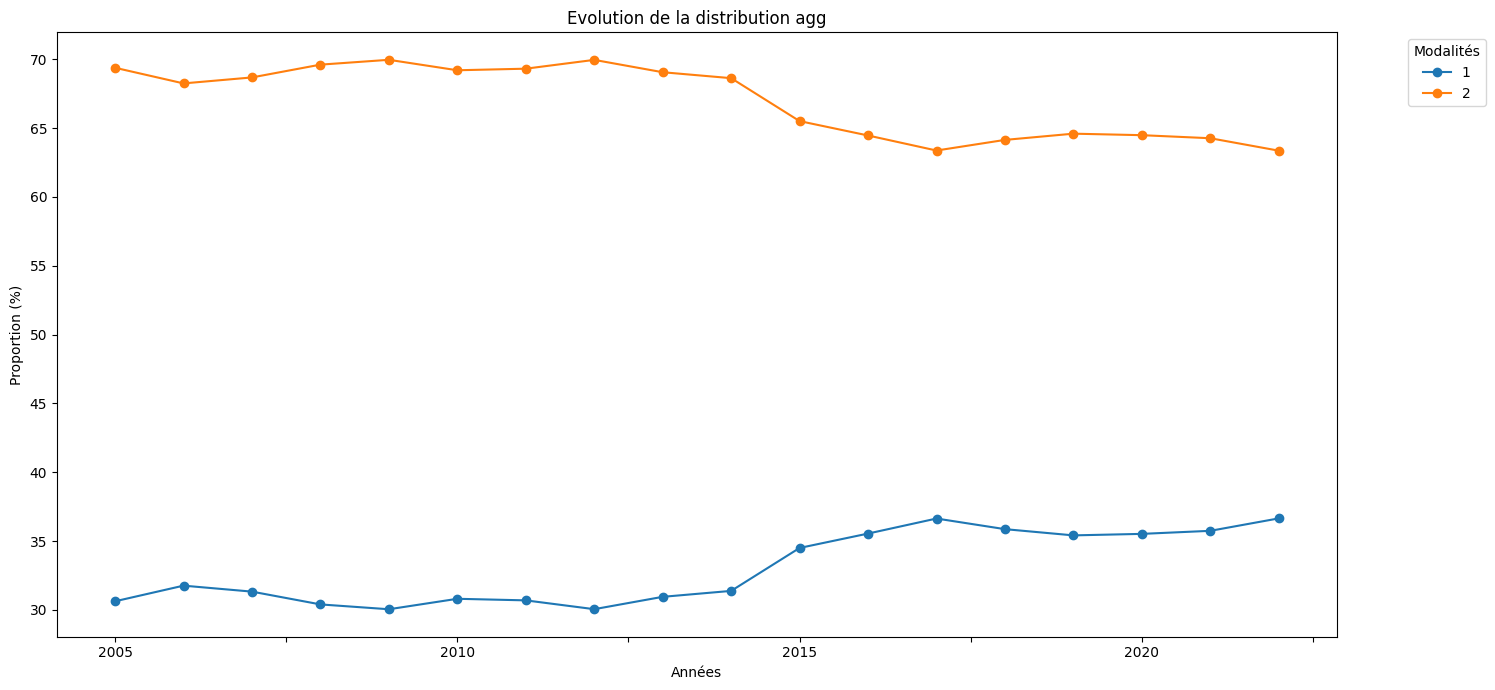

lignes: 1176873

Description: Département : Code INSEE du département (2A Corse-du-Sud – 2B Haute-Corse).
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64      750                                      0                                    0
   2006  int64      750                                      0                                    0
   2007  int64      750                                      0                                    0
   2008  int64      750                                      0                                    0
   2009  int64      750                                      0                                    0
   2010  int64      750                                      0                                    0
   2011  int64      750                                      0                                

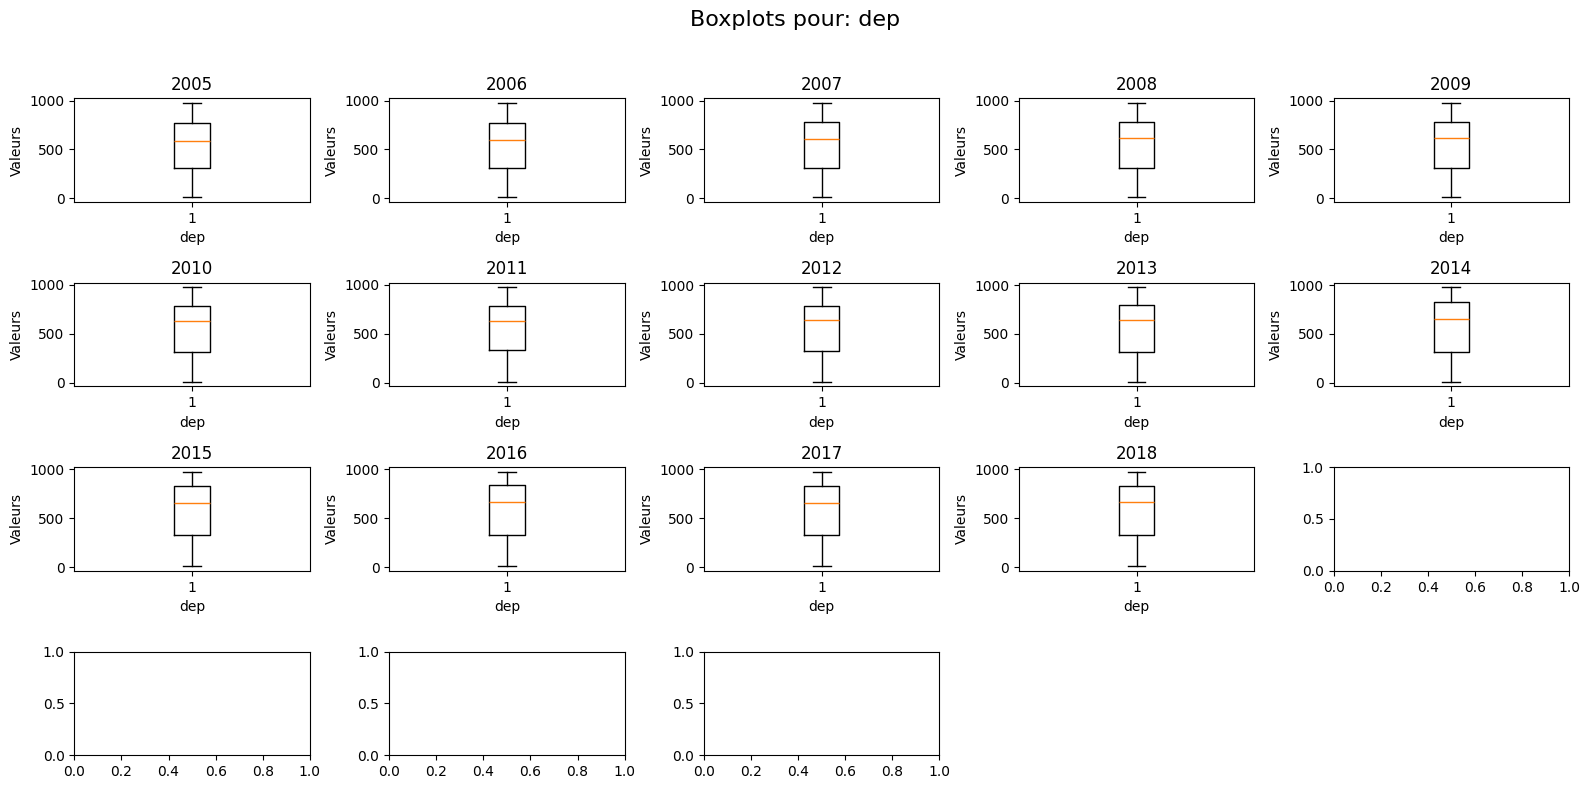

2024-11-25 11:19:52,938 - WARNING - Le nombre de modalités uniques dans la colonne dep excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:19:52,968 - WARNING - Le nombre de modalités uniques dans la colonne dep excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Numéro d'identifiant de l’accident.
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11                                      0                                    0
   2012

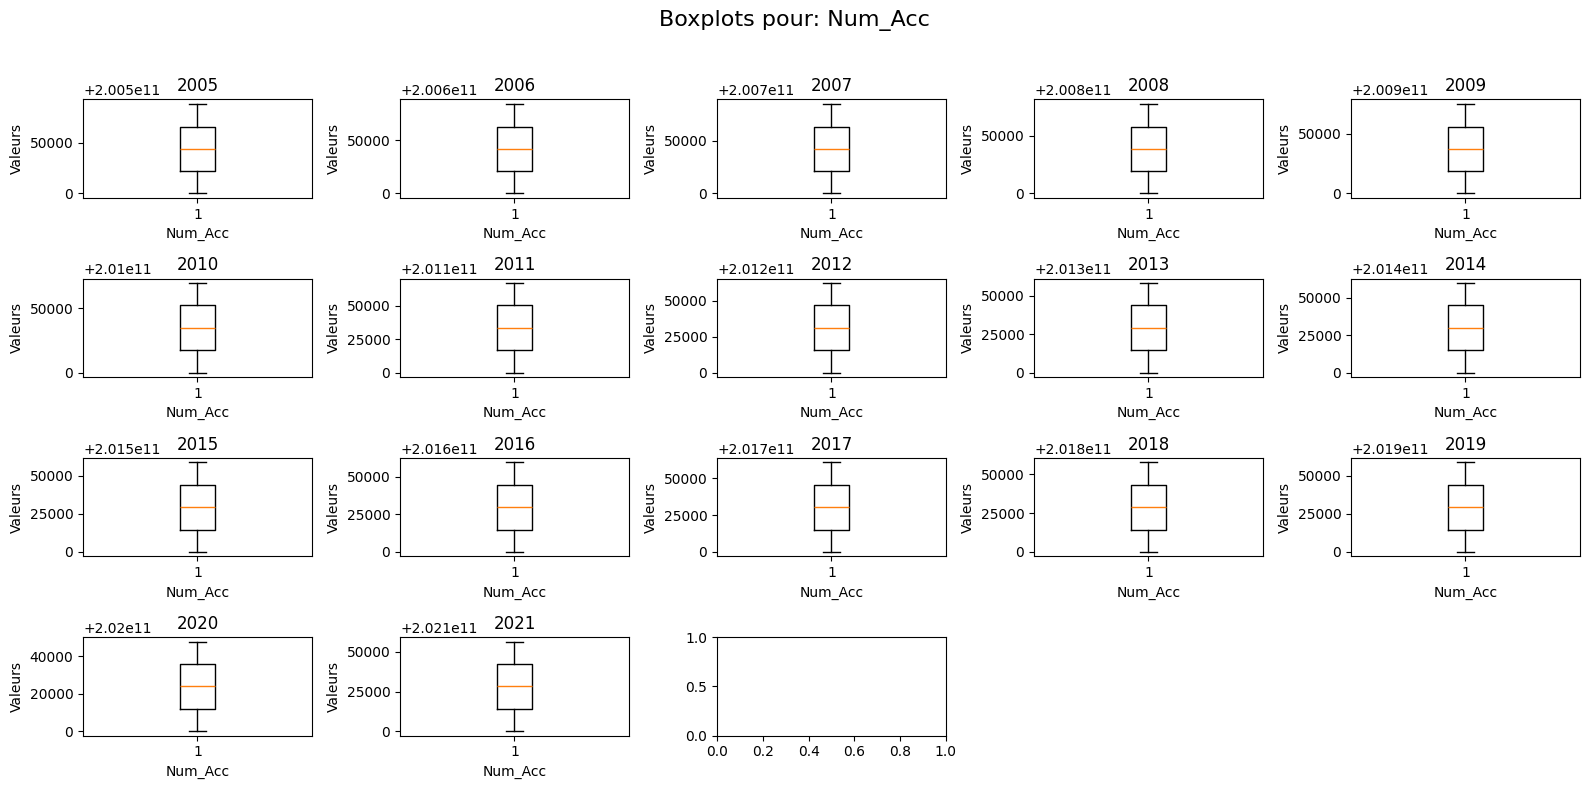

2024-11-25 11:19:54,798 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:19:55,016 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Intersection :

Modalités:
- 1: Hors intersection
- 2: Intersection en X
- 3: Intersection en T
- 4: Intersection en Y
- 5: Intersection à plus de 4 branches
- 6: Giratoire
- 7: Place
- 8: Passage à niveau
- 9: Autre intersection
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                 

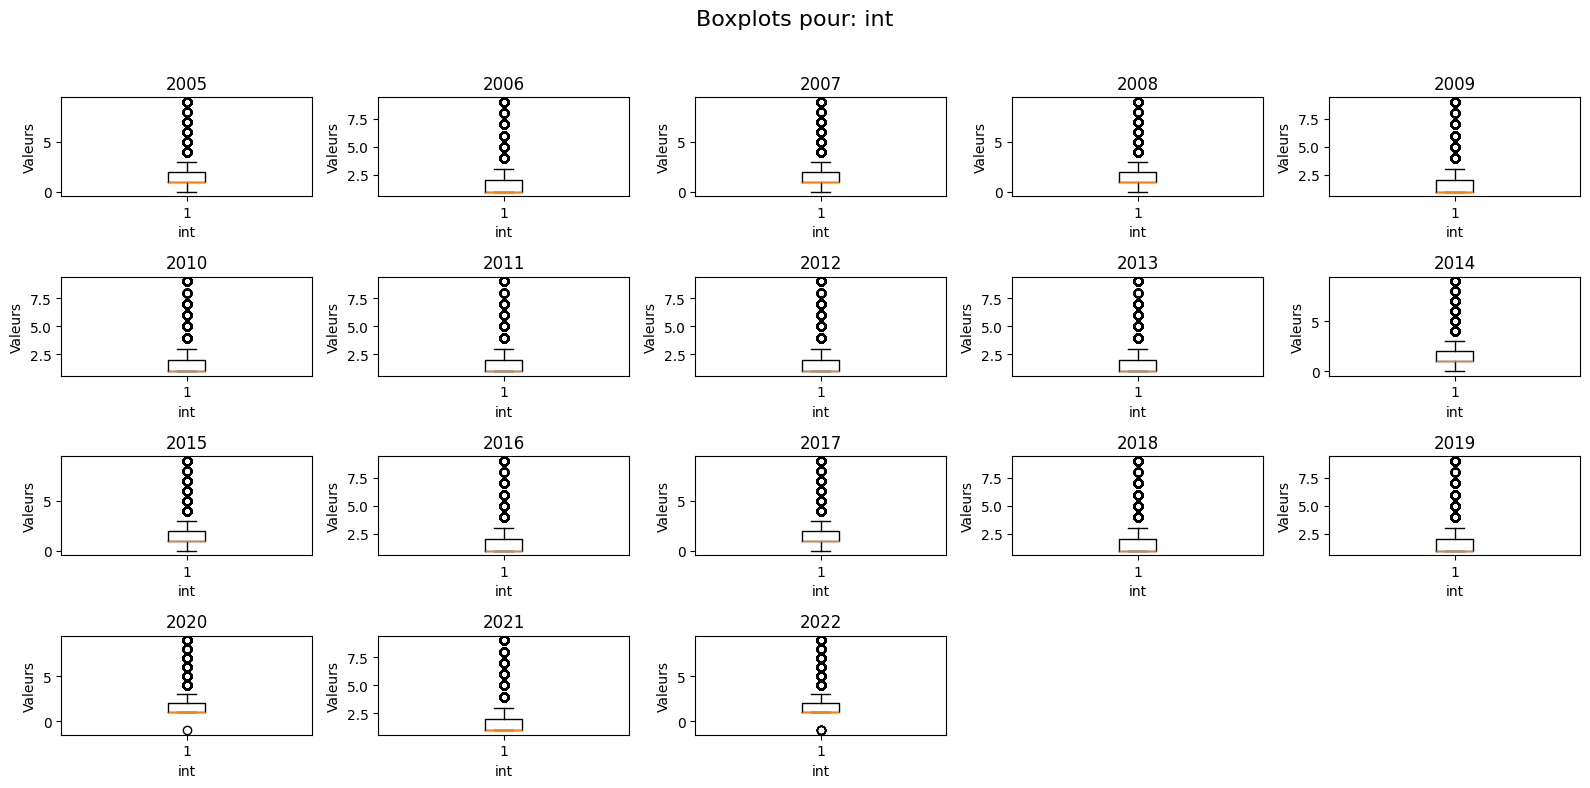

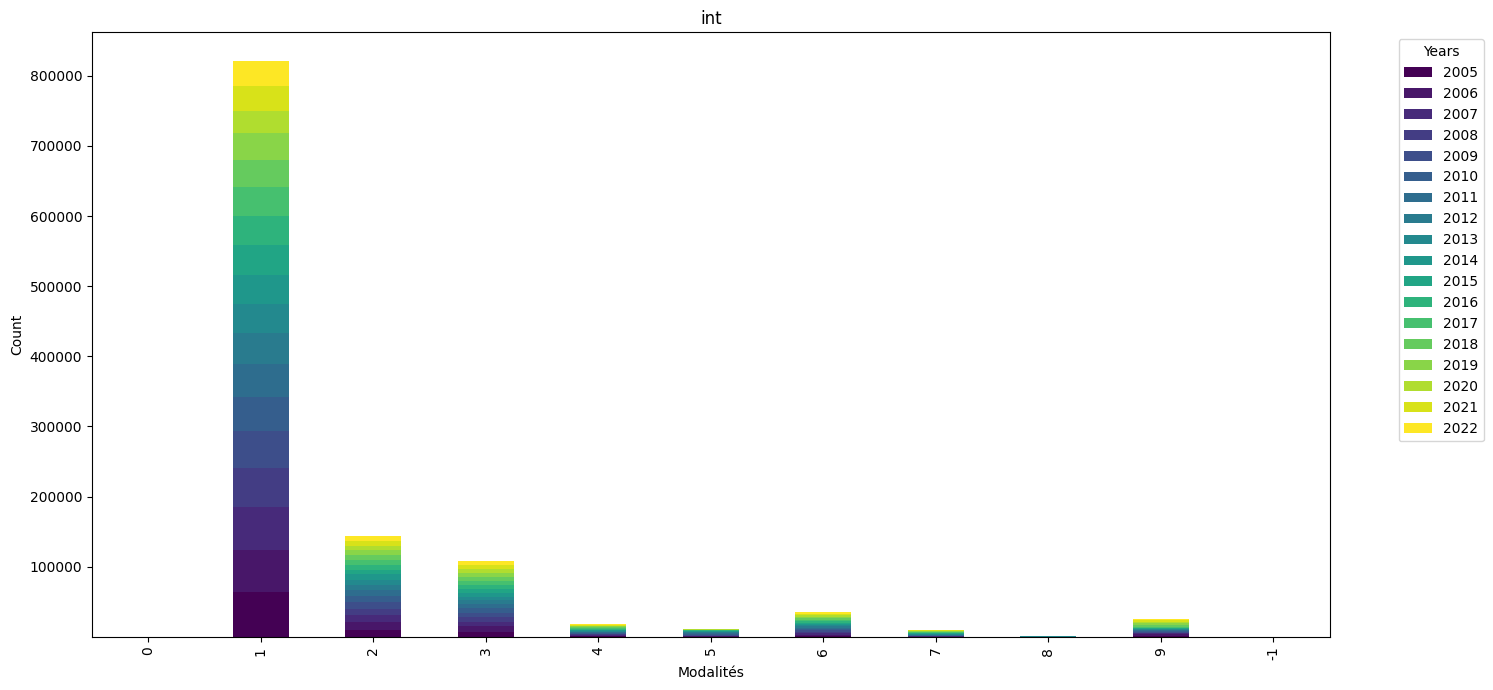

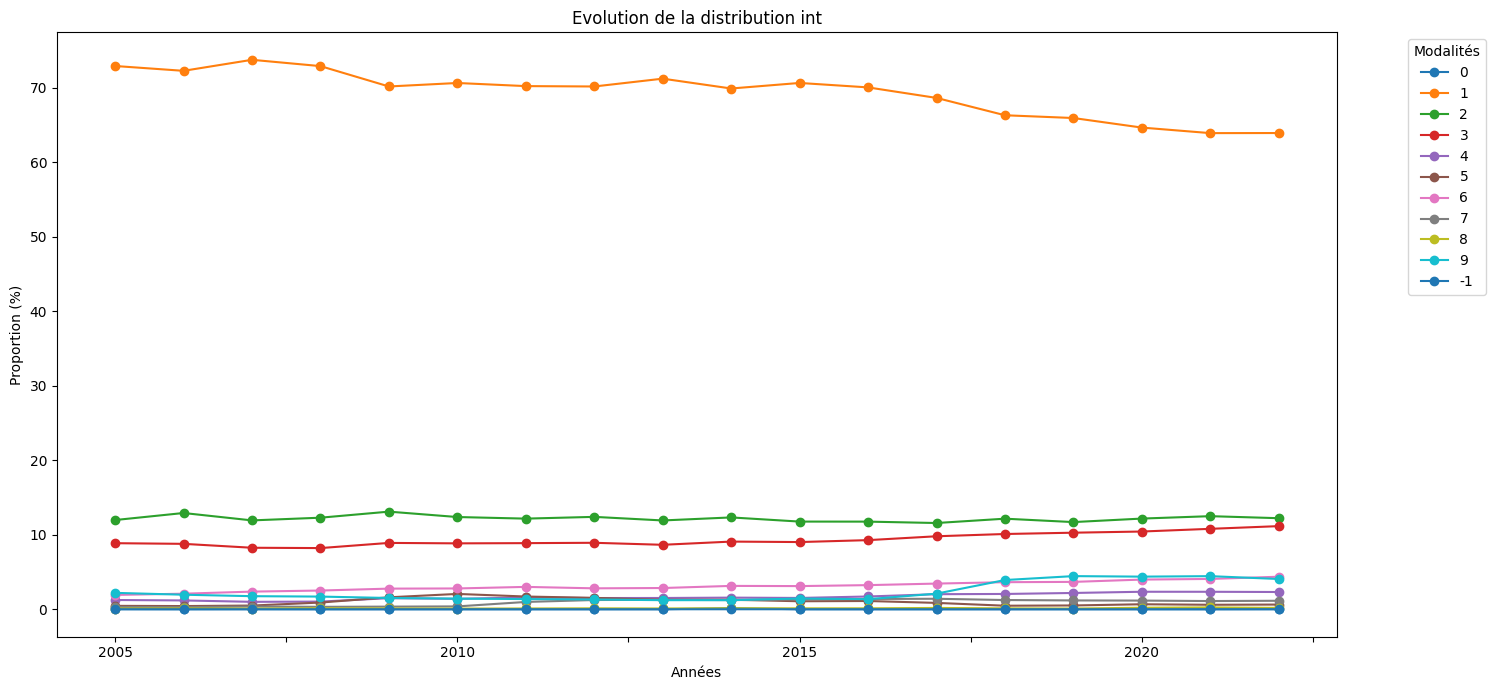

lignes: 1176873

Description: Lumière : conditions d’éclairage dans lesquelles l'accident s'est produit :

Modalités:
- 1: Plein jour
- 2: Crépuscule ou aube
- 3: Nuit sans éclairage public
- 4: Nuit avec éclairage public non allumé
- 5: Nuit avec éclairage public allumé
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1     

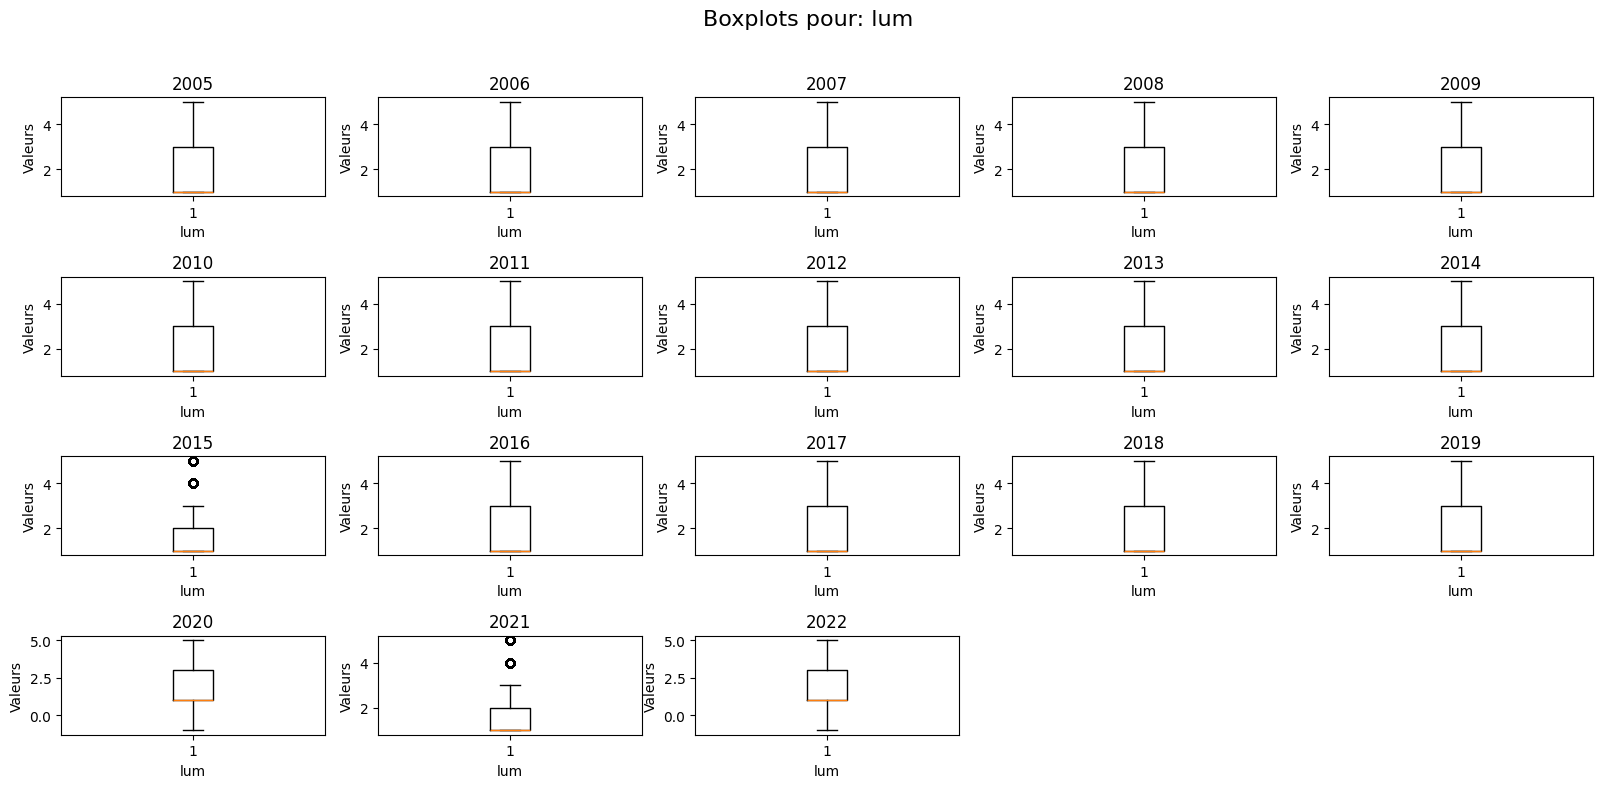

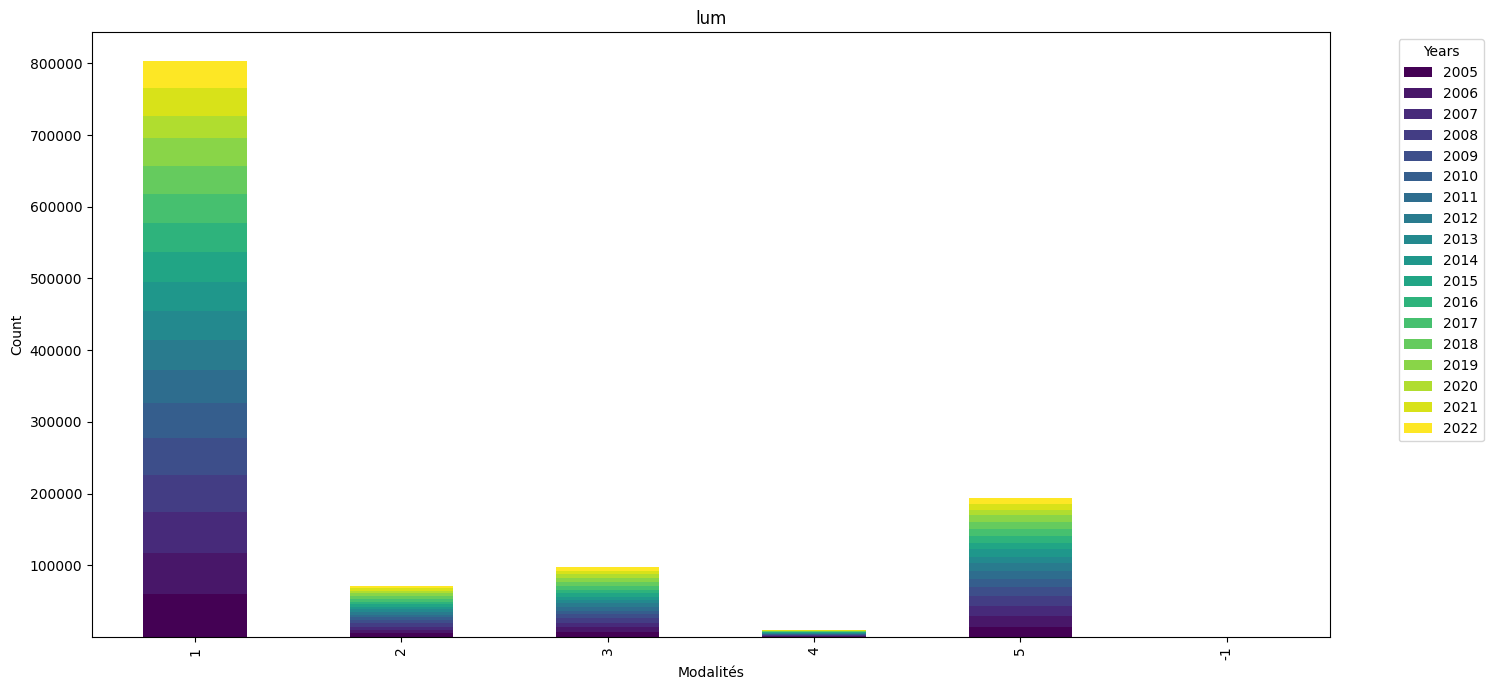

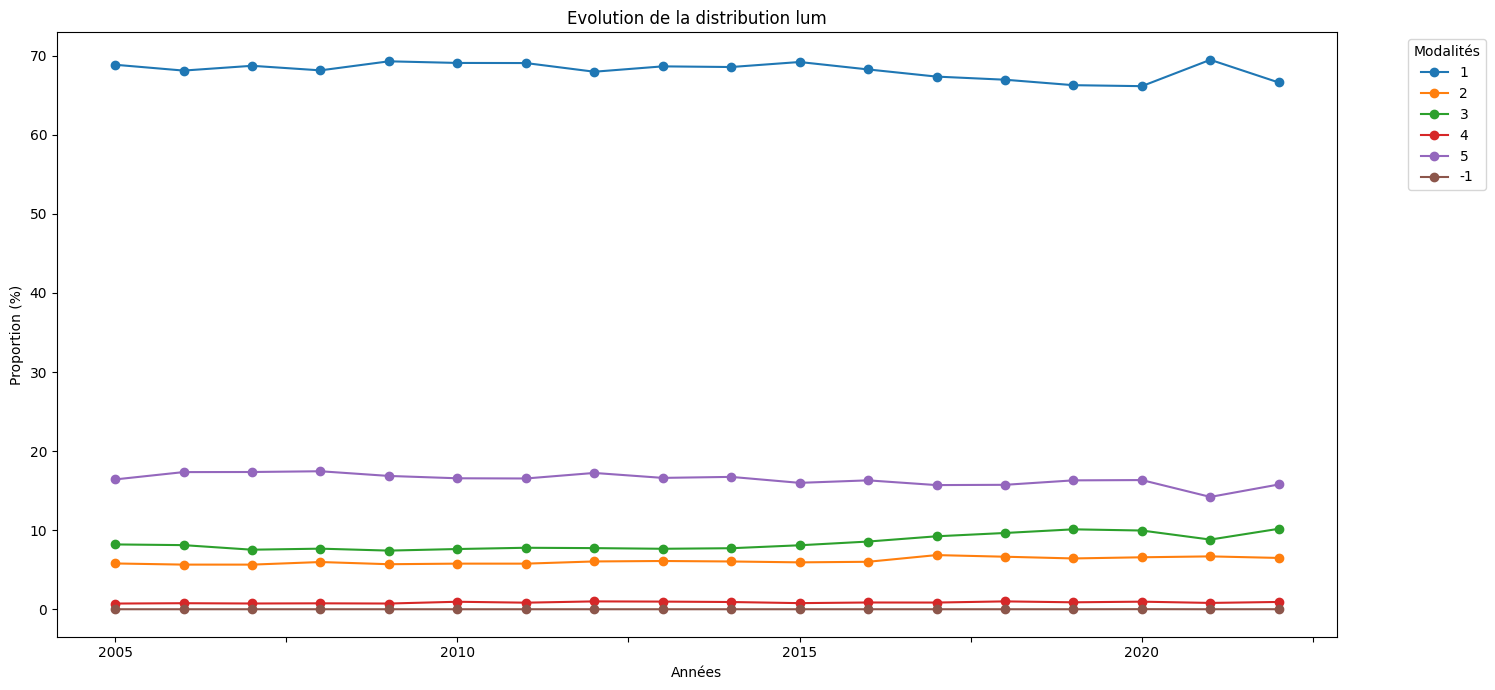

2024-11-25 11:20:00,003 - INFO - La colonne adr n'est pas numérique.


lignes: 1176873

Description: Adresse postale : variable renseignée pour les accidents survenus en agglomération.
  Année  Type    Mode             Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  -------------  -------------------------------------  -----------------------------------
   2005  object  AUTOROUTE A1                               19.2908                            0.0142649
   2006  object  AUTOROUTE A1                               13.4132                            0.00945896
   2007  object  AUTOROUTE A1                               17.8366                            0.0127083
   2008  object  AUTOROUTE A1                               19.382                             0.0126428
   2009  object  A13                                        17.307                             0.0109426
   2010  object  AUTOROUTE A1                               16.629                             0.0098031
   2011  object  A13                     

2024-11-25 11:20:00,381 - WARNING - Le nombre de modalités uniques dans la colonne adr excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:00,801 - WARNING - Le nombre de modalités uniques dans la colonne adr excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Conditions atmosphériques :

Modalités:
- -1: Non renseigné
- 1: Normale
- 2: Pluie légère
- 3: Pluie forte
- 4: Neige - grêle
- 5: Brouillard - fumée
- 6: Vent fort - tempête
- 7: Temps éblouissant
- 8: Temps couvert
- 9: Autre
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                             0                                   0
   2006  int64         1                             0                                   0
   2007  int64         1                             0                                   0
   2008  int64         1                             0                                   0
   2009  float64       1                             0.00940746                          5.94797e-06
   2010  float64       1                             0.00432408           

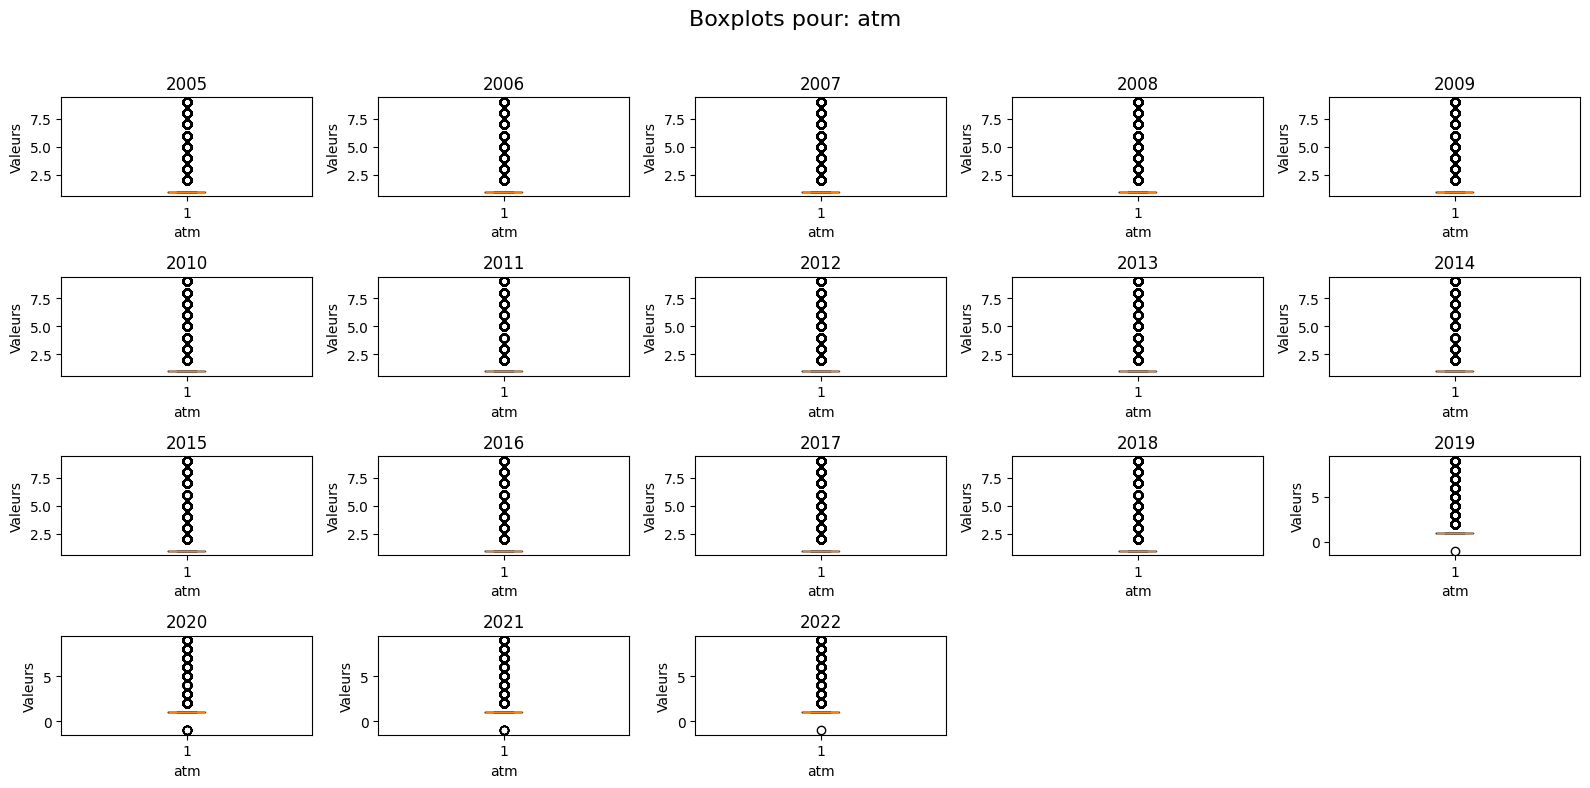

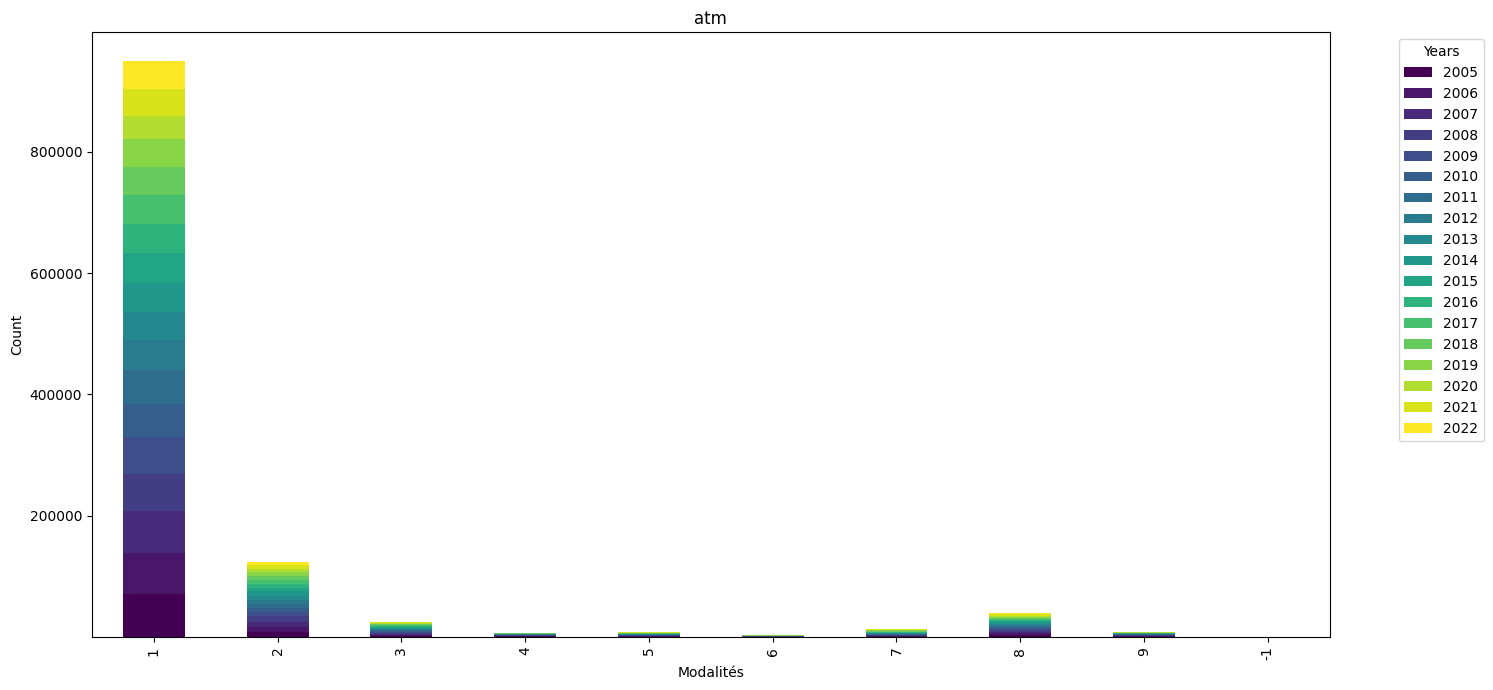

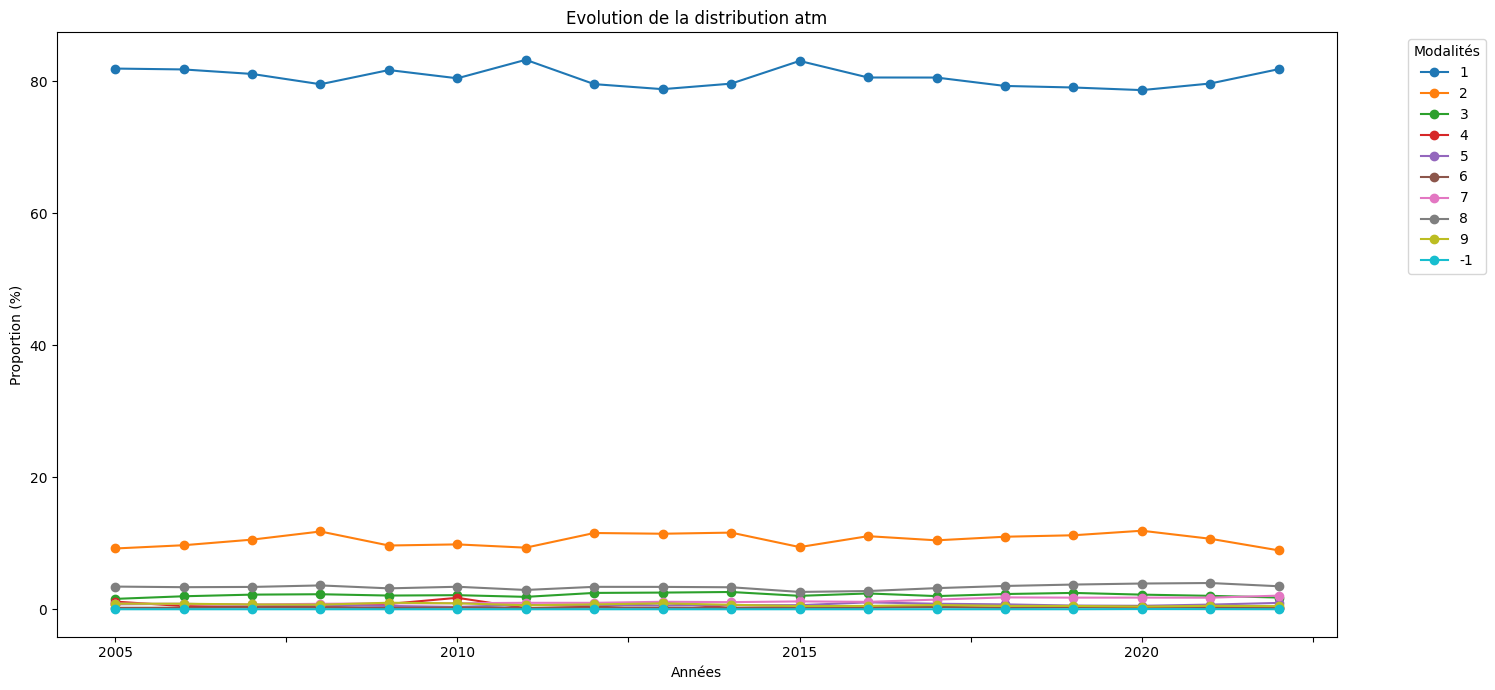

lignes: 1176873

Description: Latitude
  Année  Type     Mode              Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  --------------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                          69.0403                            0.0510531
   2006  float64  0.0                                          70.7686                            0.049906
   2007  float64  0.0                                          71.9129                            0.0512366
   2008  float64  0.0                                          71.8056                            0.0468385
   2009  float64  4.0                                          54.9813                            0.0347625
   2010  float64  0.0                                          54.5064                            0.0321326
   2011  float64  0.0                                          54.1748                          

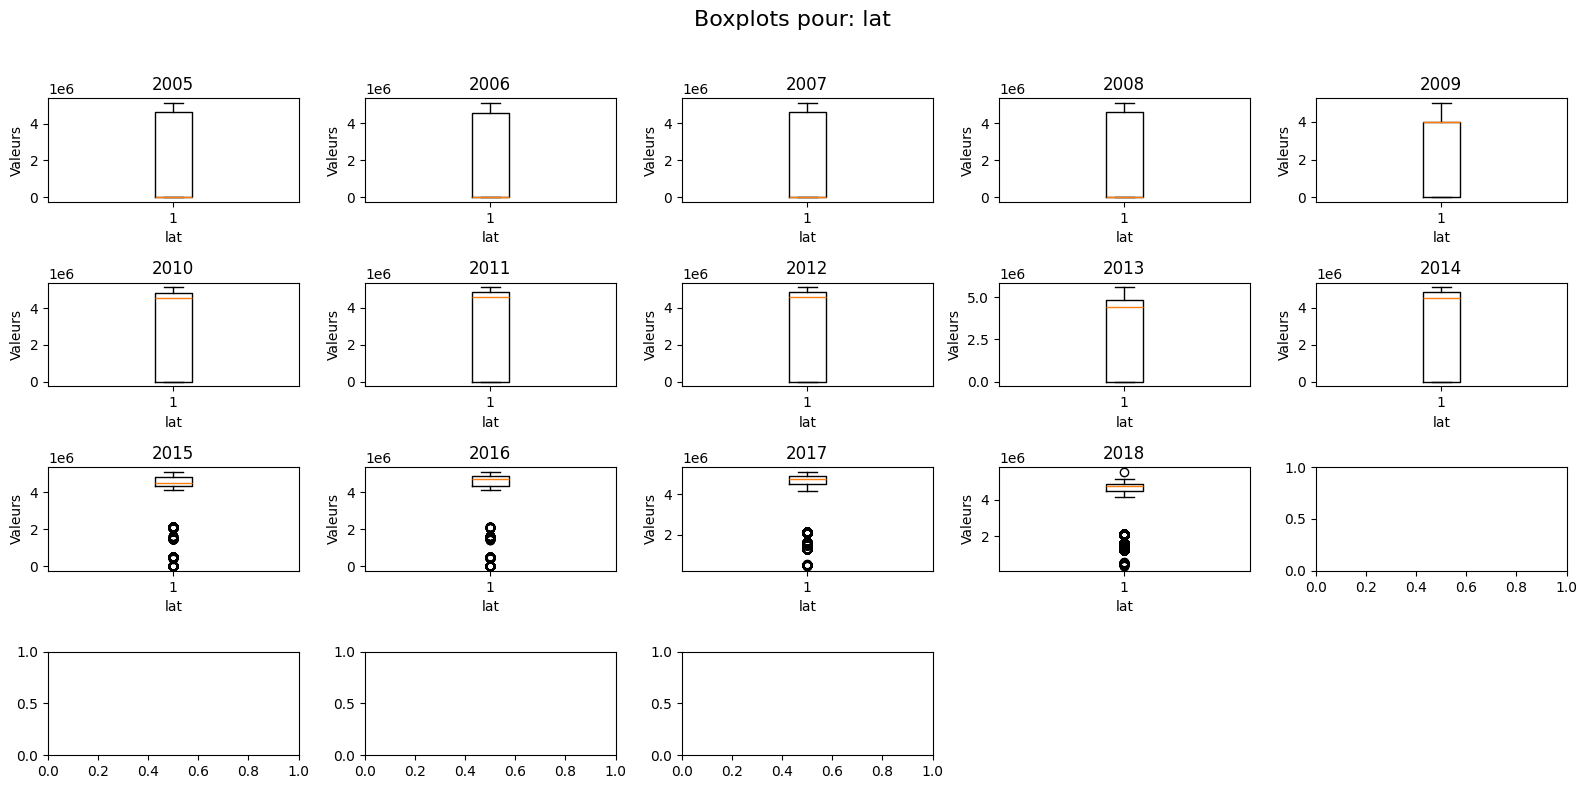

2024-11-25 11:20:05,682 - WARNING - Le nombre de modalités uniques dans la colonne lat excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:05,894 - WARNING - Le nombre de modalités uniques dans la colonne lat excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Jour de l'accident.
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64       19                                      0                                    0
   2006  int64       13                                      0                                    0
   2007  int64        6                                      0                                    0
   2008  int64        4                                      0                                    0
   2009  int64       17                                      0                                    0
   2010  int64       15                                      0                                    0
   2011  int64        8                                      0                                    0
   2012  int64       21                           

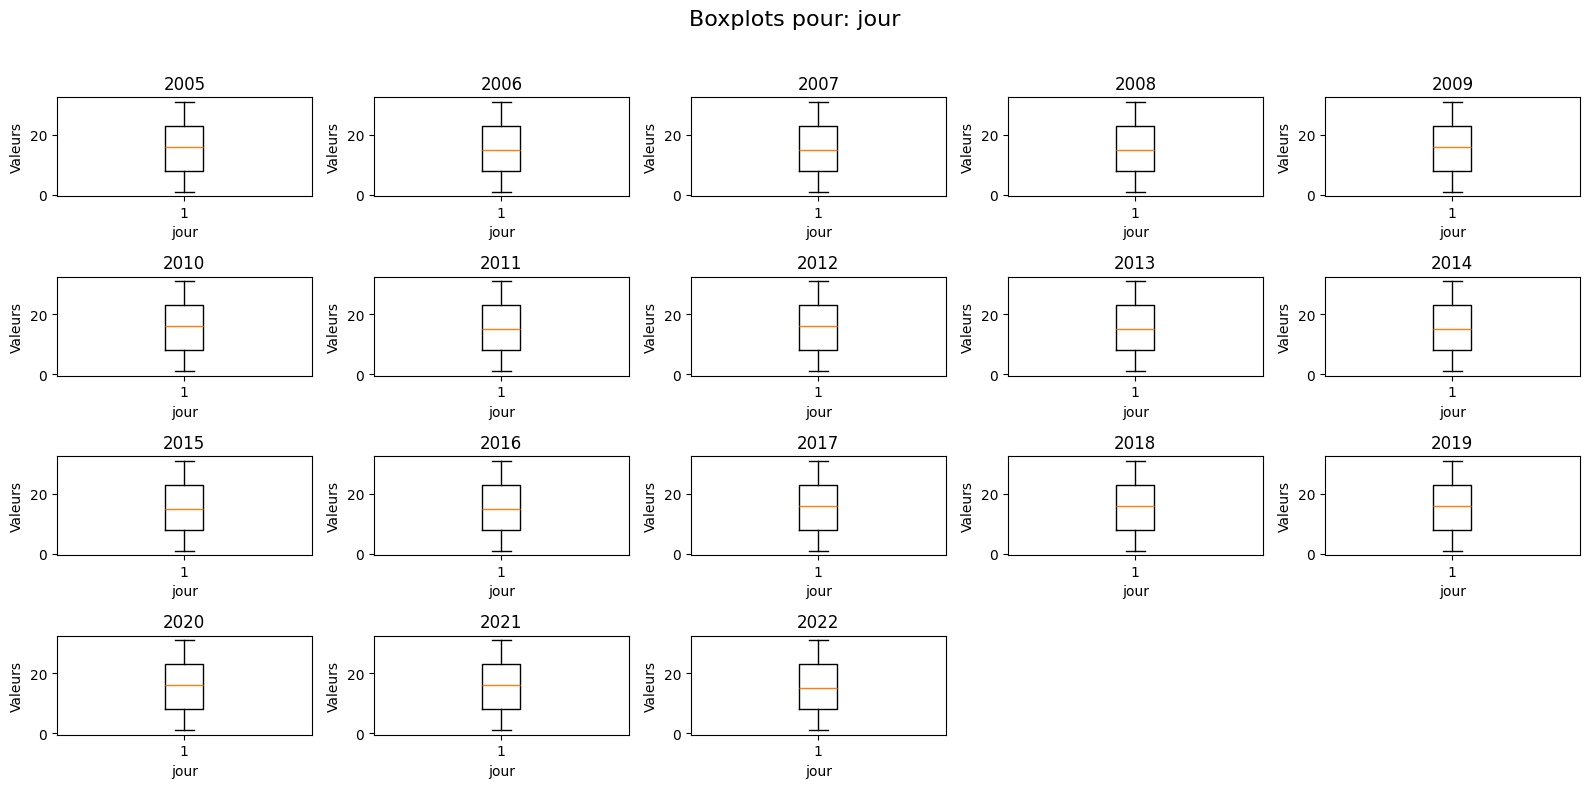

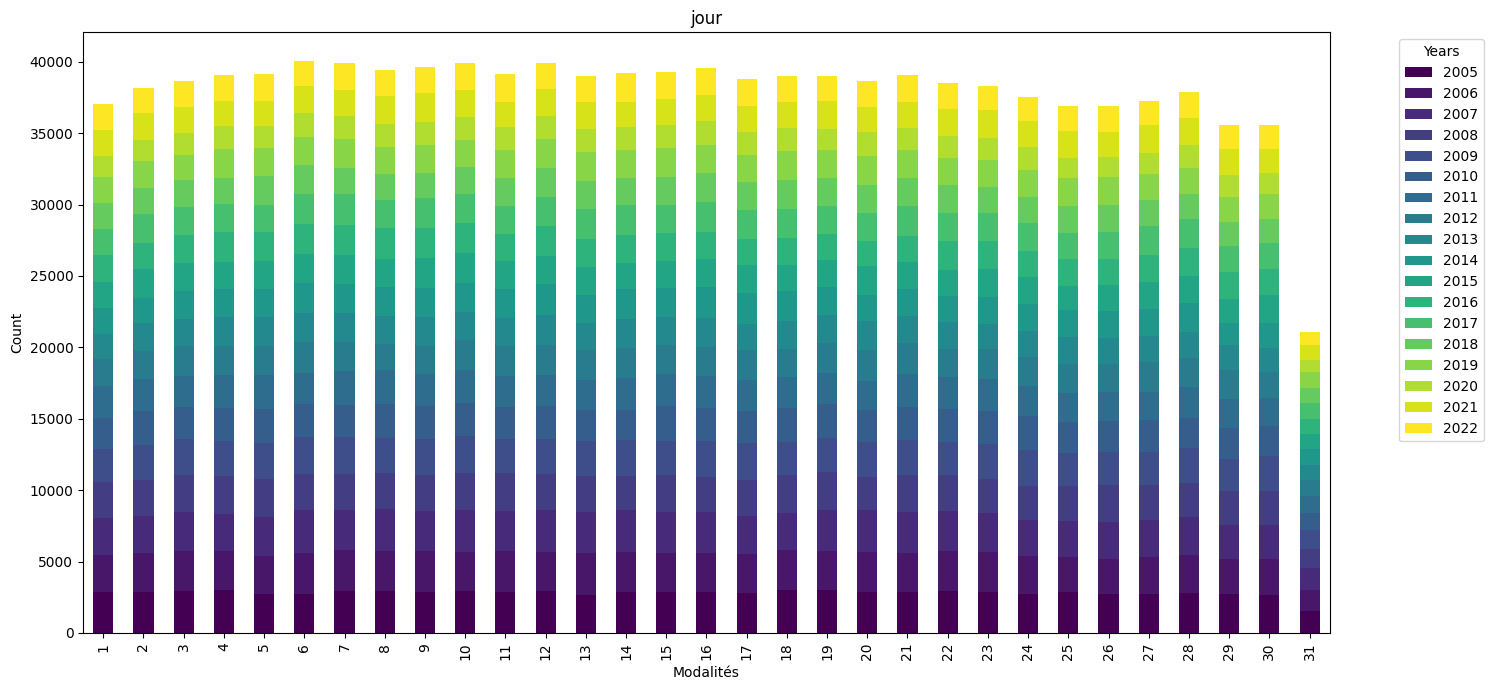

2024-11-25 11:20:08,248 - WARNING - Le nombre de modalités uniques dans la colonne jour excède le seuil de 12. Aucun graphique en ligne généré.


2024-11-25 11:20:08,359 - INFO - Pas de description pour `gps` dans la section `CARACTERISTIQUES`.
2024-11-25 11:20:08,361 - INFO - La colonne gps n'est pas numérique.


lignes: 1176873

  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  M                                  68.9323                             0.0509732
   2006  object  M                                  70.6843                             0.0498465
   2007  object  M                                  71.8104                             0.0511635
   2008  object  M                                  71.6831                             0.0467587
   2009  object  M                                  54.8361                             0.0346707
   2010  object  M                                  54.2729                             0.031995
   2011  object  M                                  53.9403                             0.0306966
   2012  object  M                                  52.9912                             0.0280294


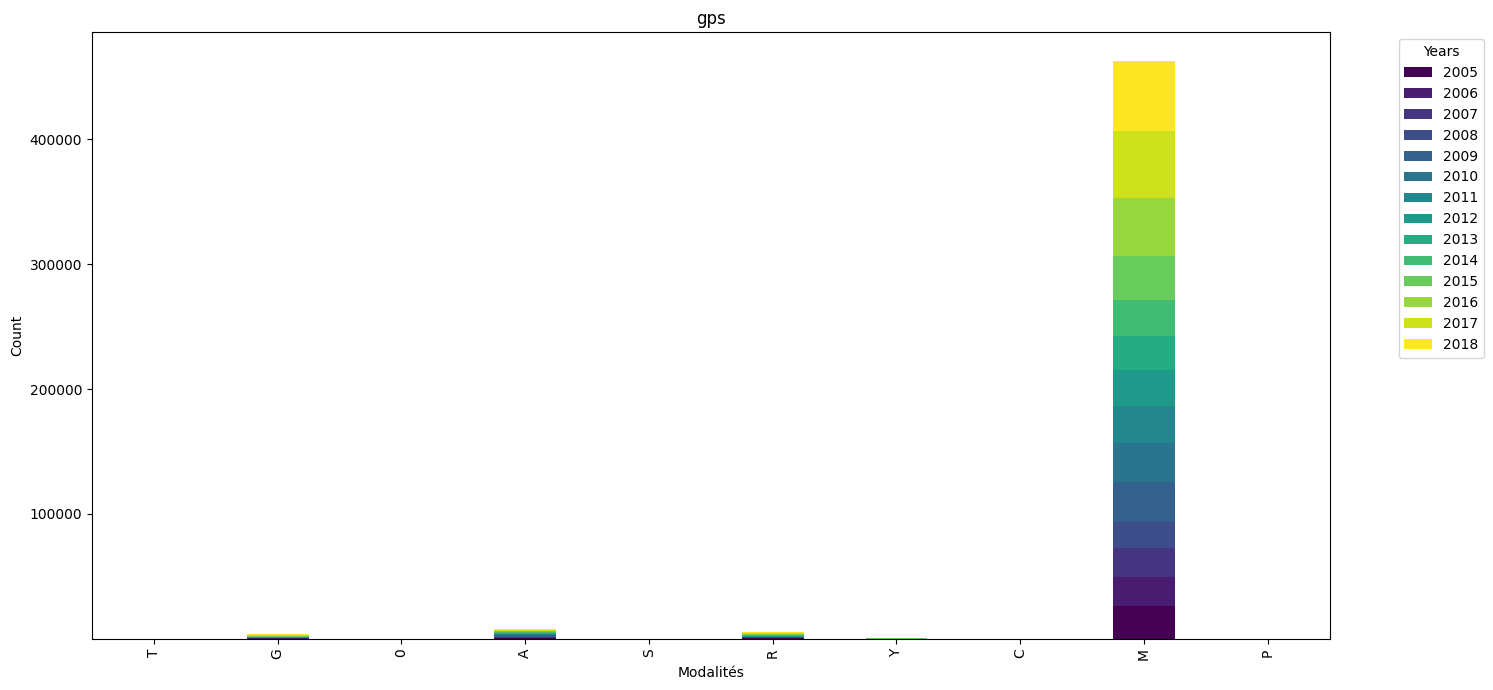

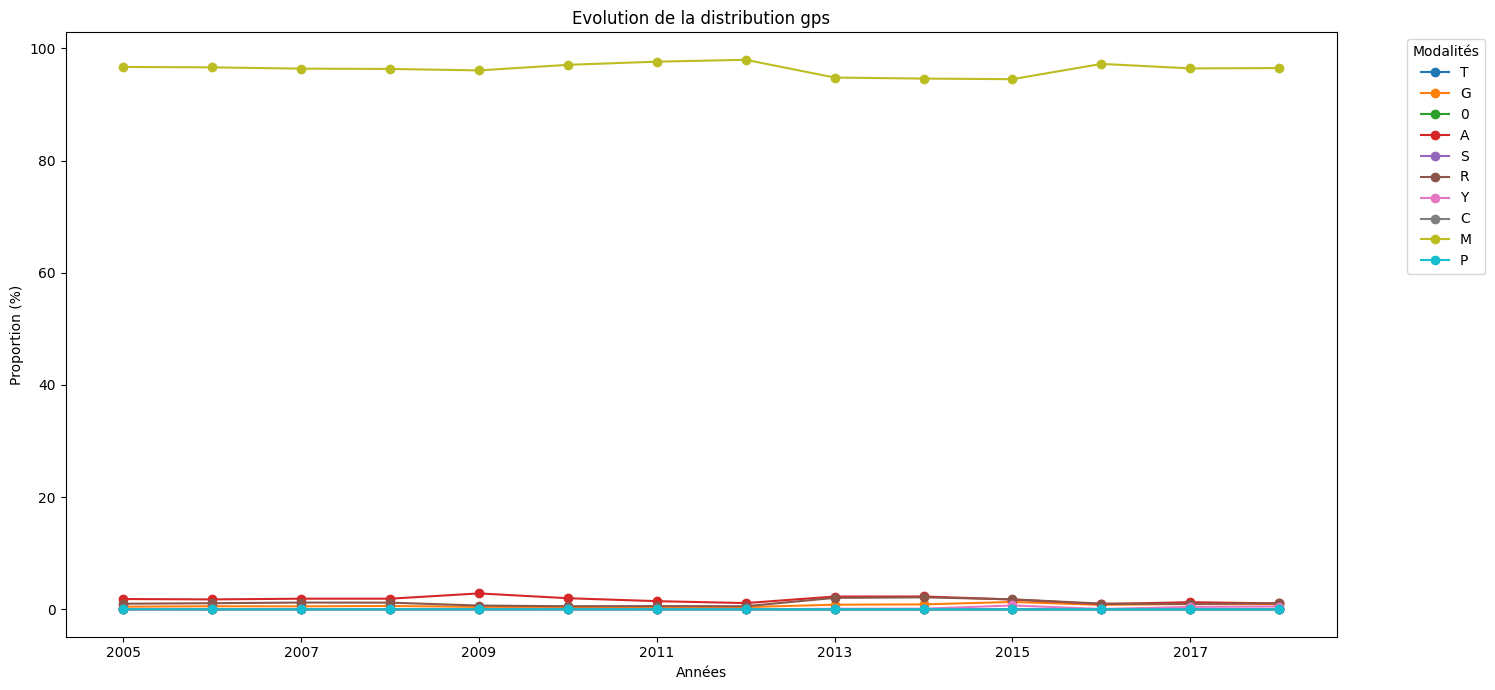

2024-11-25 11:20:09,075 - INFO - Pas de description pour `Accident_Id` dans la section `CARACTERISTIQUES`.


lignes: 1176873

  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2022  int64   2.022e+11                                      0                                    0


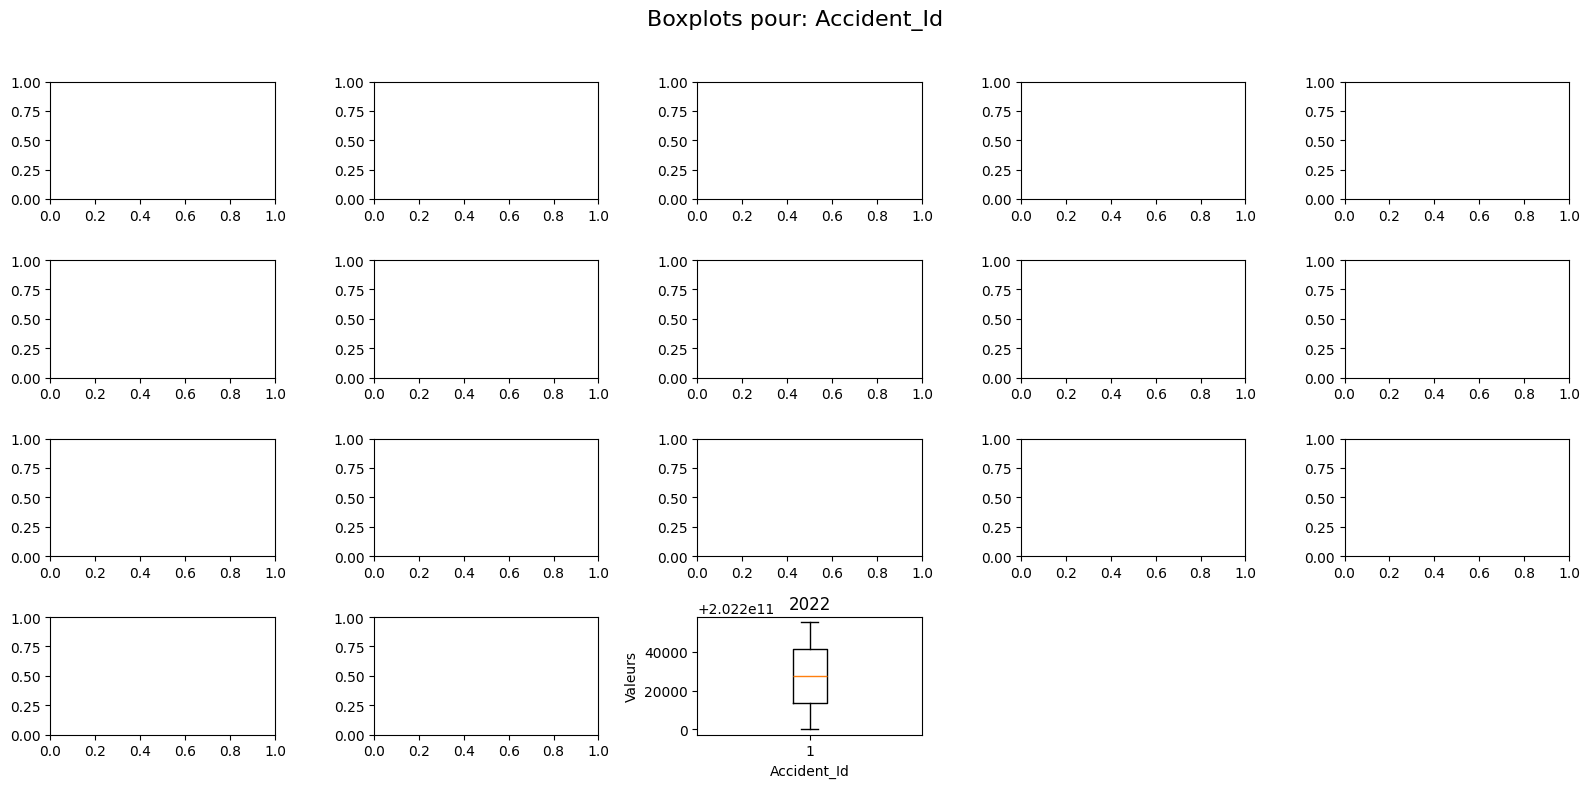

2024-11-25 11:20:10,847 - WARNING - Le nombre de modalités uniques dans la colonne Accident_Id excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:10,866 - WARNING - Le nombre de modalités uniques dans la colonne Accident_Id excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Année de l'accident.
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        5                                      0                                    0
   2006  int64        6                                      0                                    0
   2007  int64        7                                      0                                    0
   2008  int64        8                                      0                                    0
   2009  int64        9                                      0                                    0
   2010  int64       10                                      0                                    0
   2011  int64       11                                      0                                    0
   2012  int64       12                          

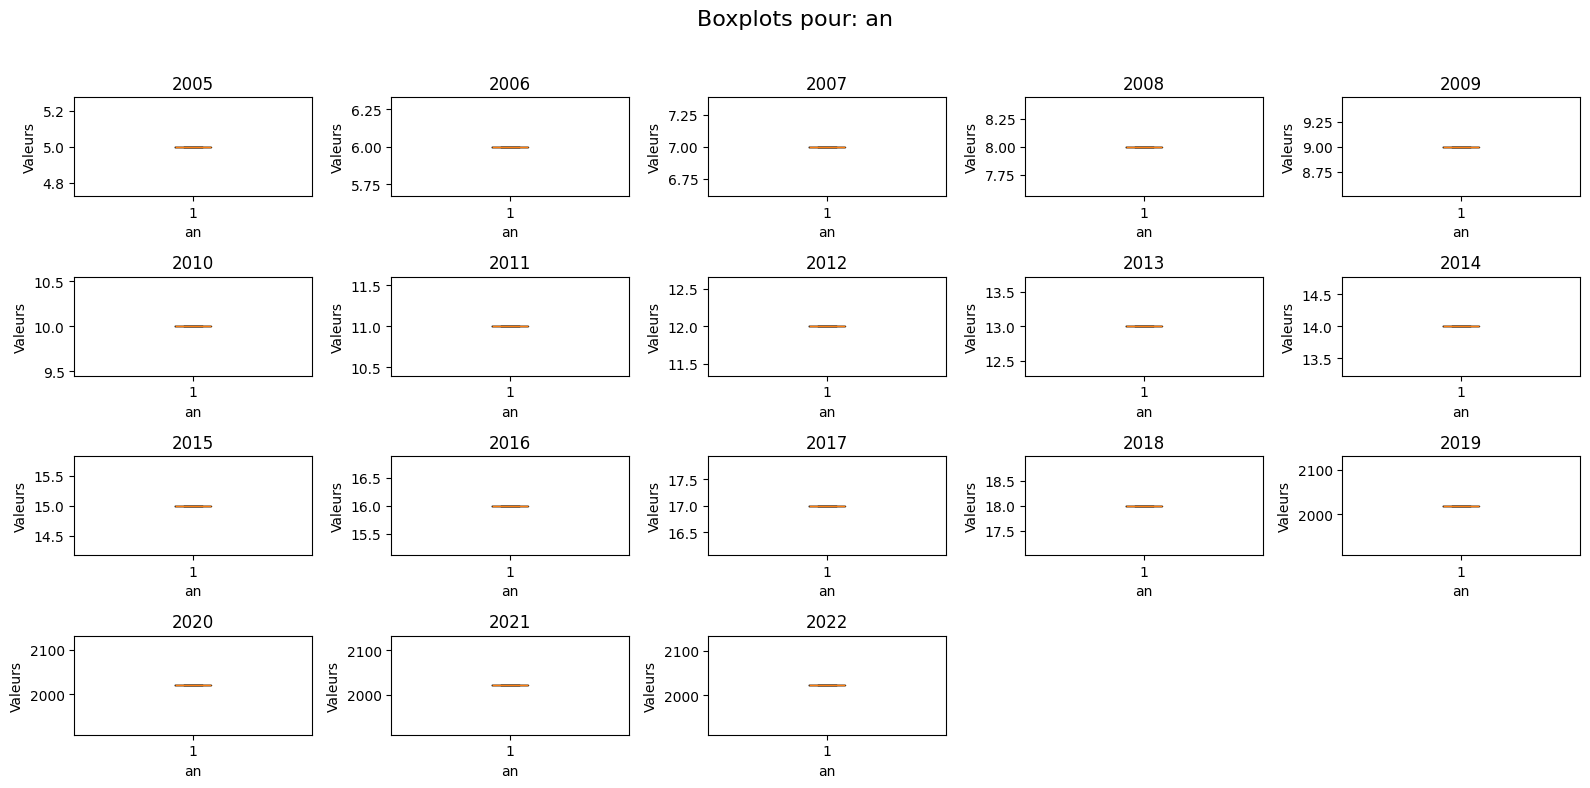

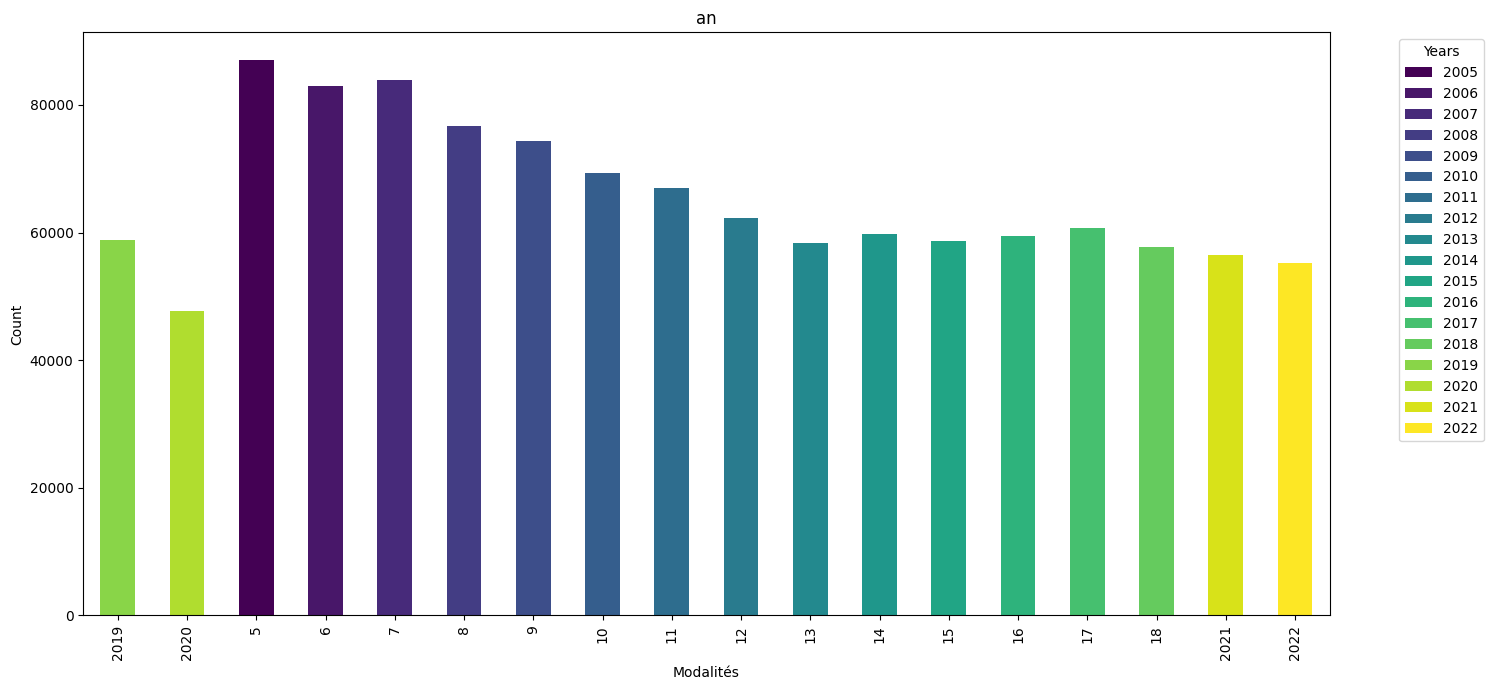

2024-11-25 11:20:13,233 - WARNING - Le nombre de modalités uniques dans la colonne an excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Commune : Le numéro de commune est un code donné par l‘INSEE. Le code est composé du code INSEE du département suivi par 3 chiffres.
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64      55                             0.00229816                          1.69942e-06
   2006  int64        55                             0                                   0
   2007  int64        55                             0                                   0
   2008  int64        55                             0                                   0
   2009  int64        88                             0                                   0
   2010  int64        55                             0                                   0
   2011  int64        55                             0                         

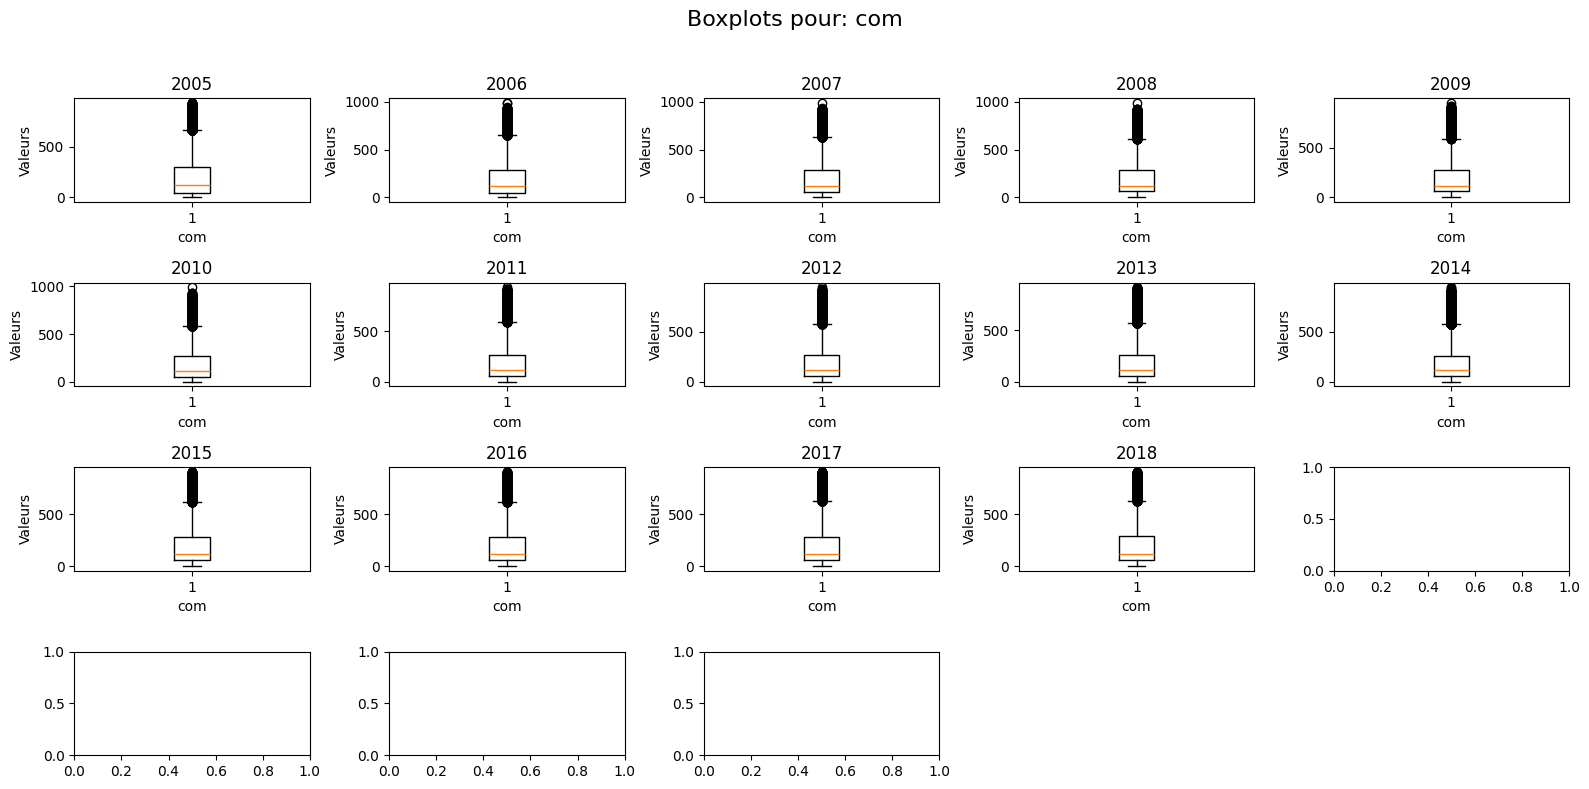

2024-11-25 11:20:15,124 - WARNING - Le nombre de modalités uniques dans la colonne com excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:15,173 - WARNING - Le nombre de modalités uniques dans la colonne com excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Longitude
  Année  Type     Mode               Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ---------------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                           69.0403                            0.0510531
   2006  float64  0.0                                           70.7686                            0.049906
   2007  float64  0.0                                           71.9129                            0.0512366
   2008  float64  0.0                                           71.8056                            0.0468385
   2009  object   0                                             54.9813                            0.0347625
   2010  float64  0.0                                           54.5064                            0.0321326
   2011  float64  0.0                                           54.1748                

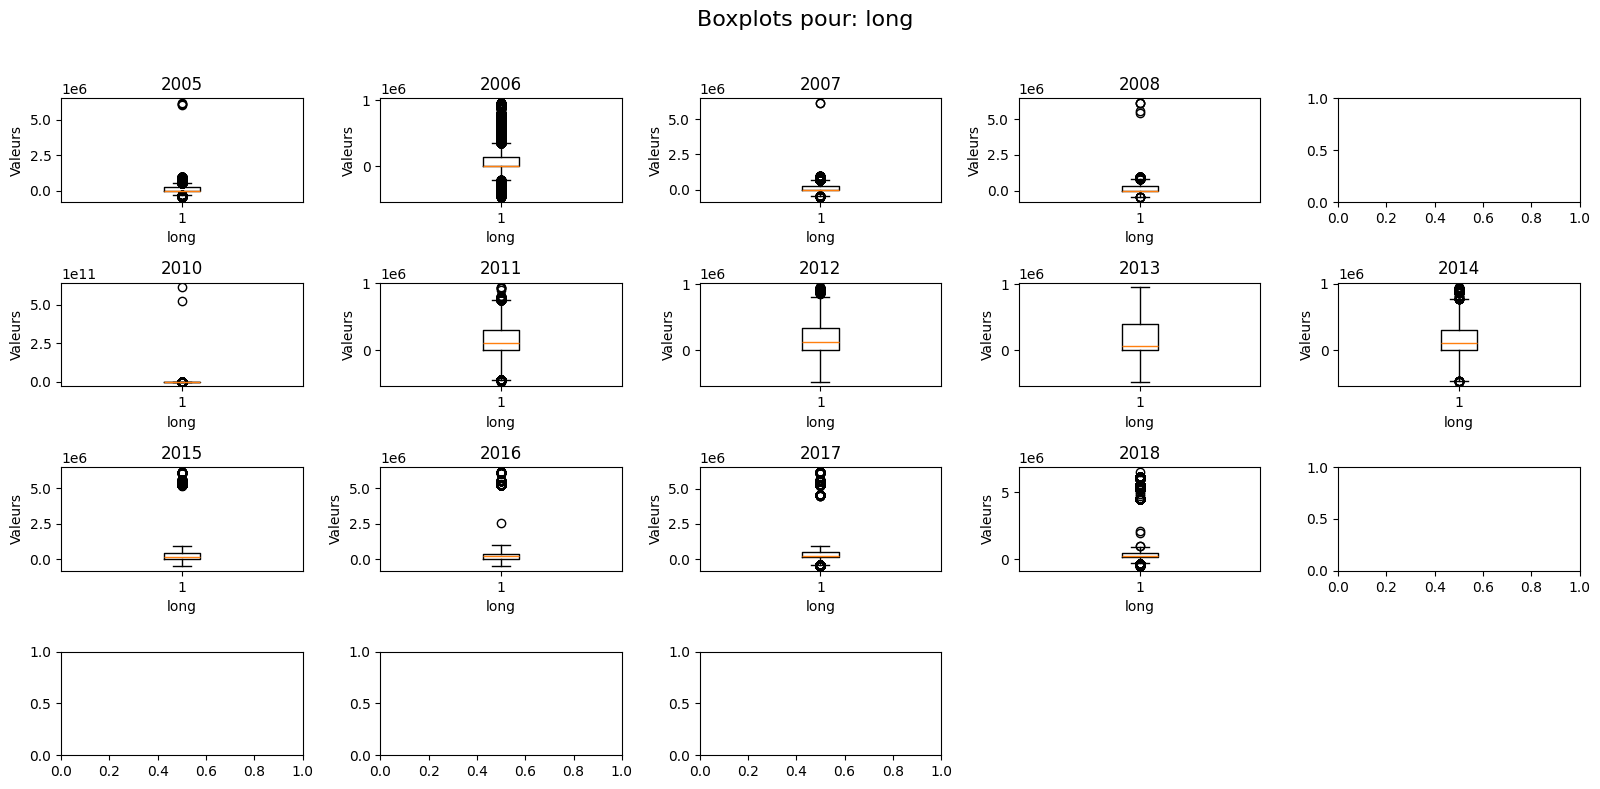

2024-11-25 11:20:17,239 - WARNING - Le nombre de modalités uniques dans la colonne long excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:17,450 - WARNING - Le nombre de modalités uniques dans la colonne long excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Type de collision :

Modalités:
- -1: Non renseigné
- 1: Deux véhicules - frontale
- 2: Deux véhicules – par l’arrière
- 3: Deux véhicules – par le coté
- 4: Trois véhicules et plus – en chaîne
- 5: Trois véhicules et plus - collisions multiples
- 6: Autre collision
- 7: Sans collision
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         6                             0                                   0
   2006  int64         6                             0                                   0
   2007  int64         6                             0                                   0
   2008  int64         6                             0                                   0
   2009  int64         6                             0                                   0
   2010  float64       6  

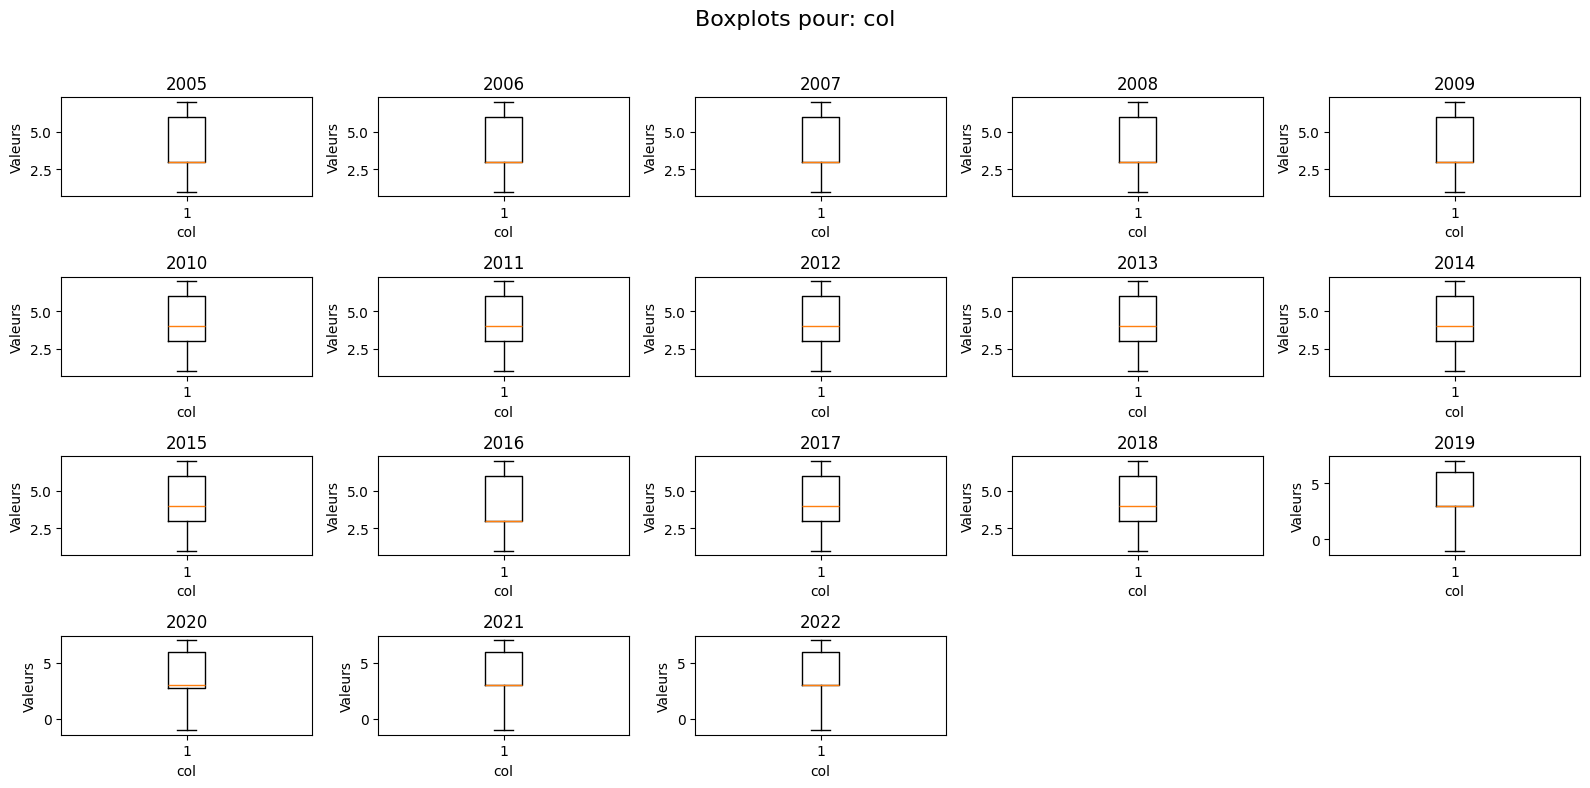

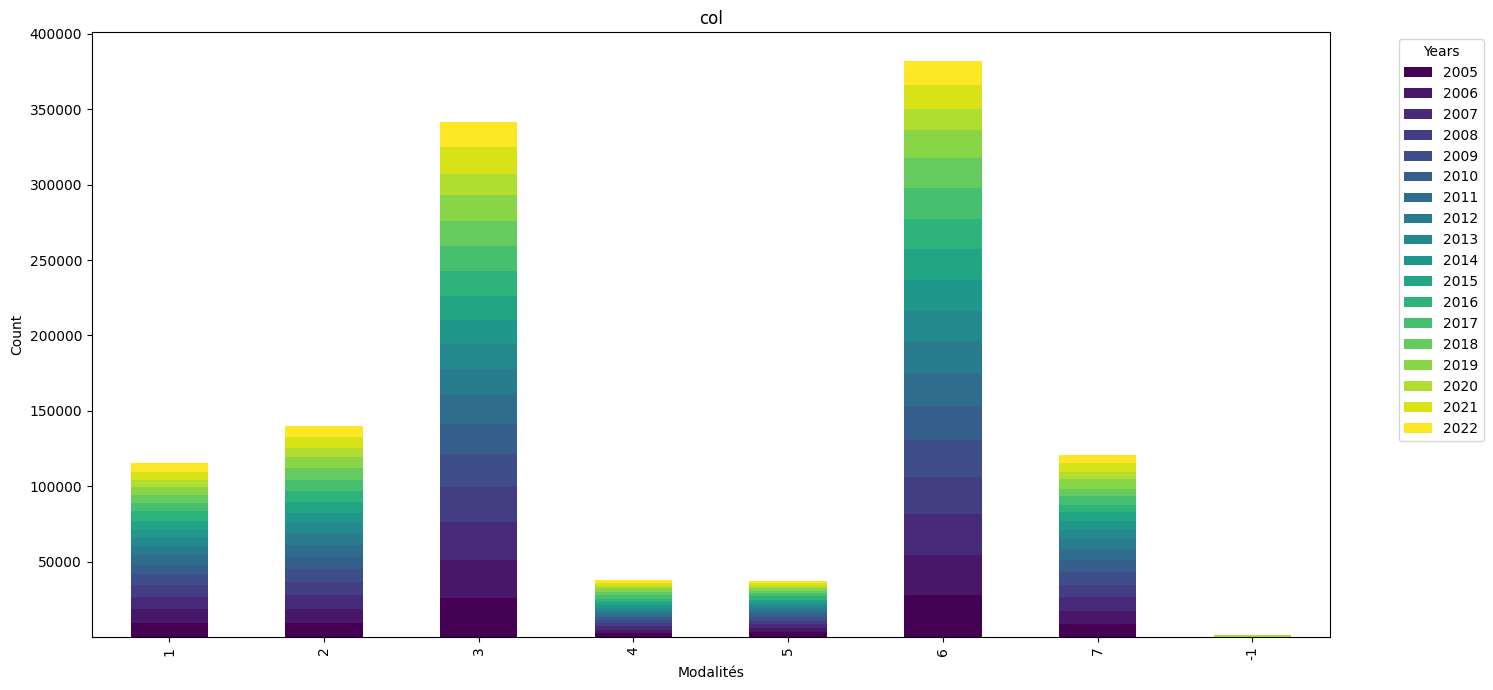

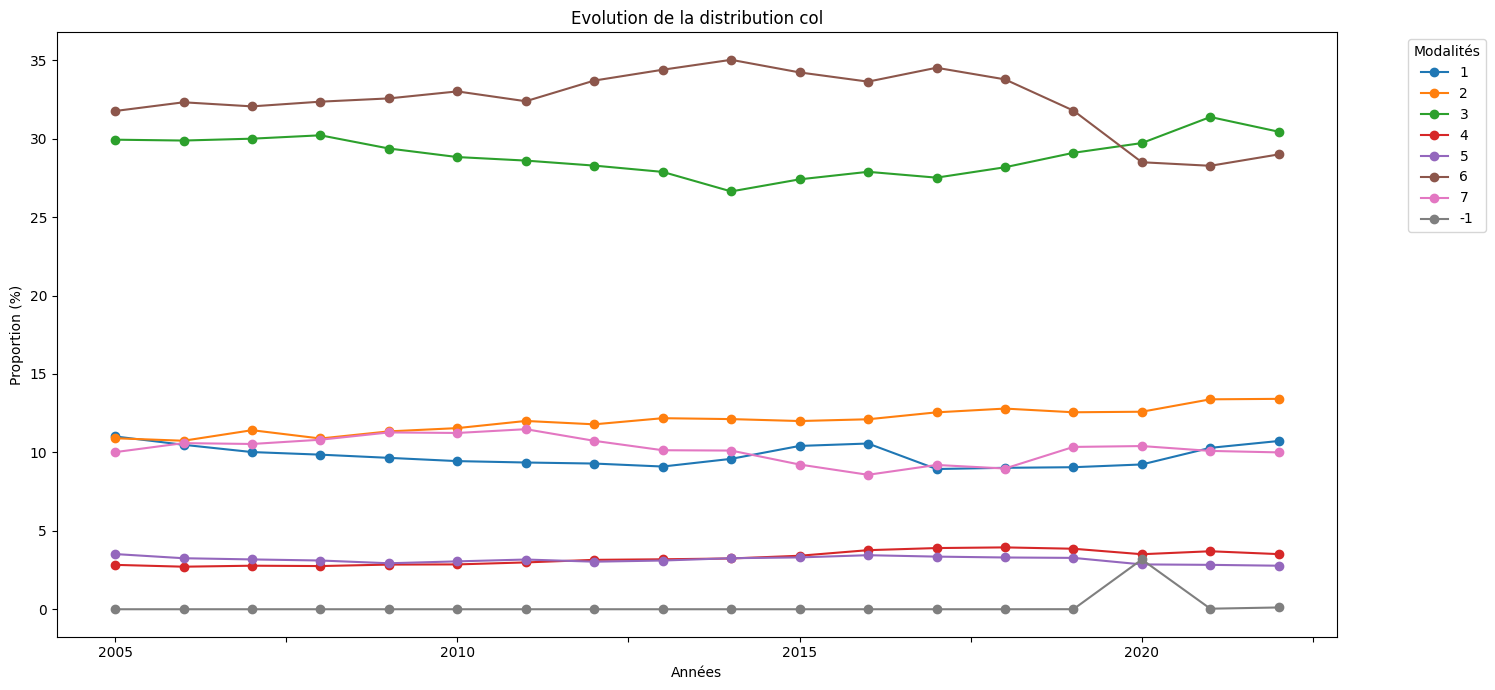

lignes: 1176873

Description: Mois de l'accident.
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        6                                      0                                    0
   2006  int64        6                                      0                                    0
   2007  int64       10                                      0                                    0
   2008  int64       10                                      0                                    0
   2009  int64        6                                      0                                    0
   2010  int64       10                                      0                                    0
   2011  int64        5                                      0                                    0
   2012  int64       10                           

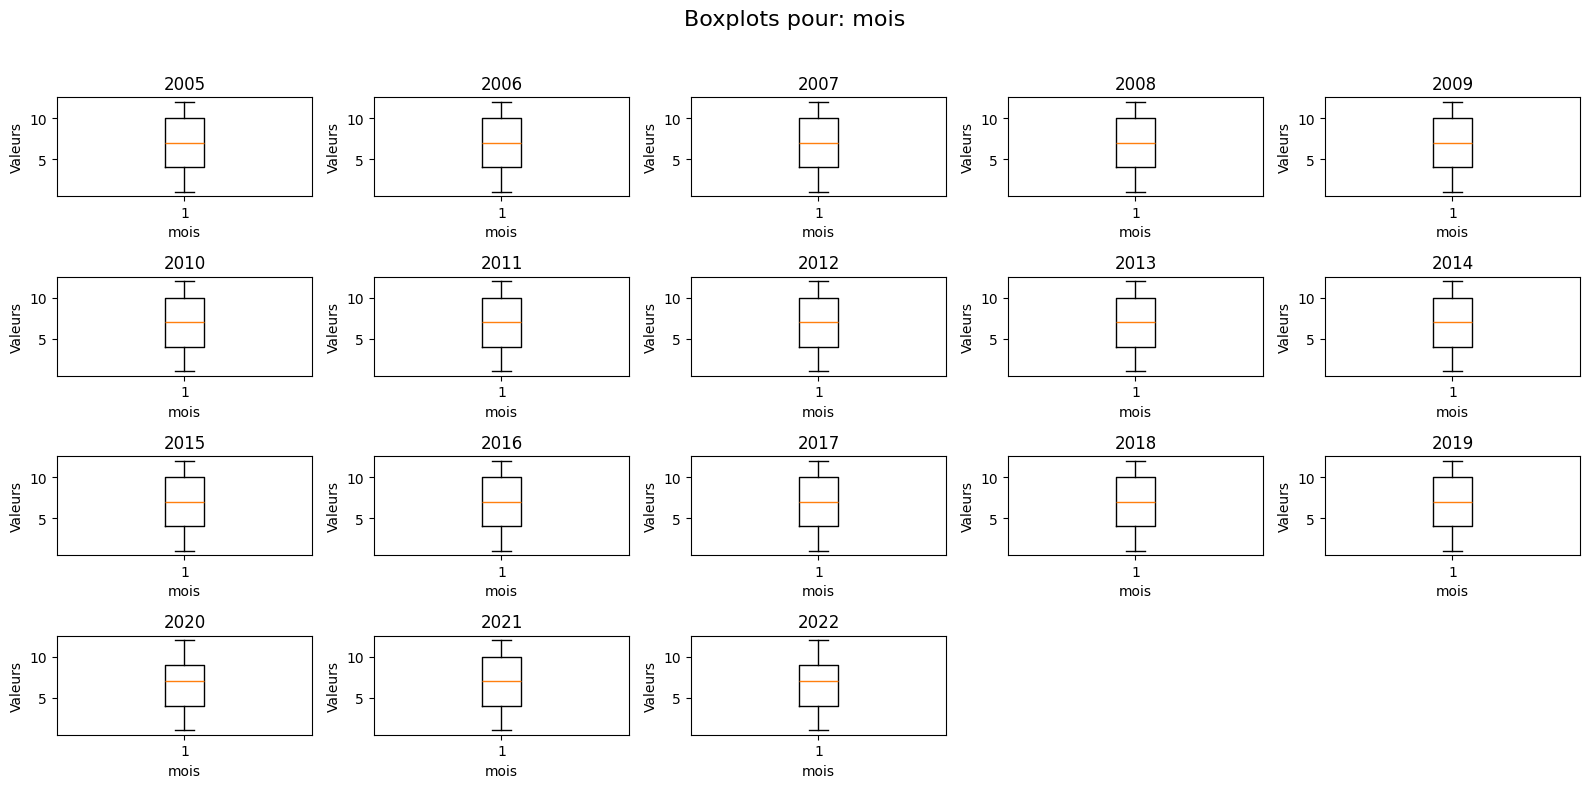

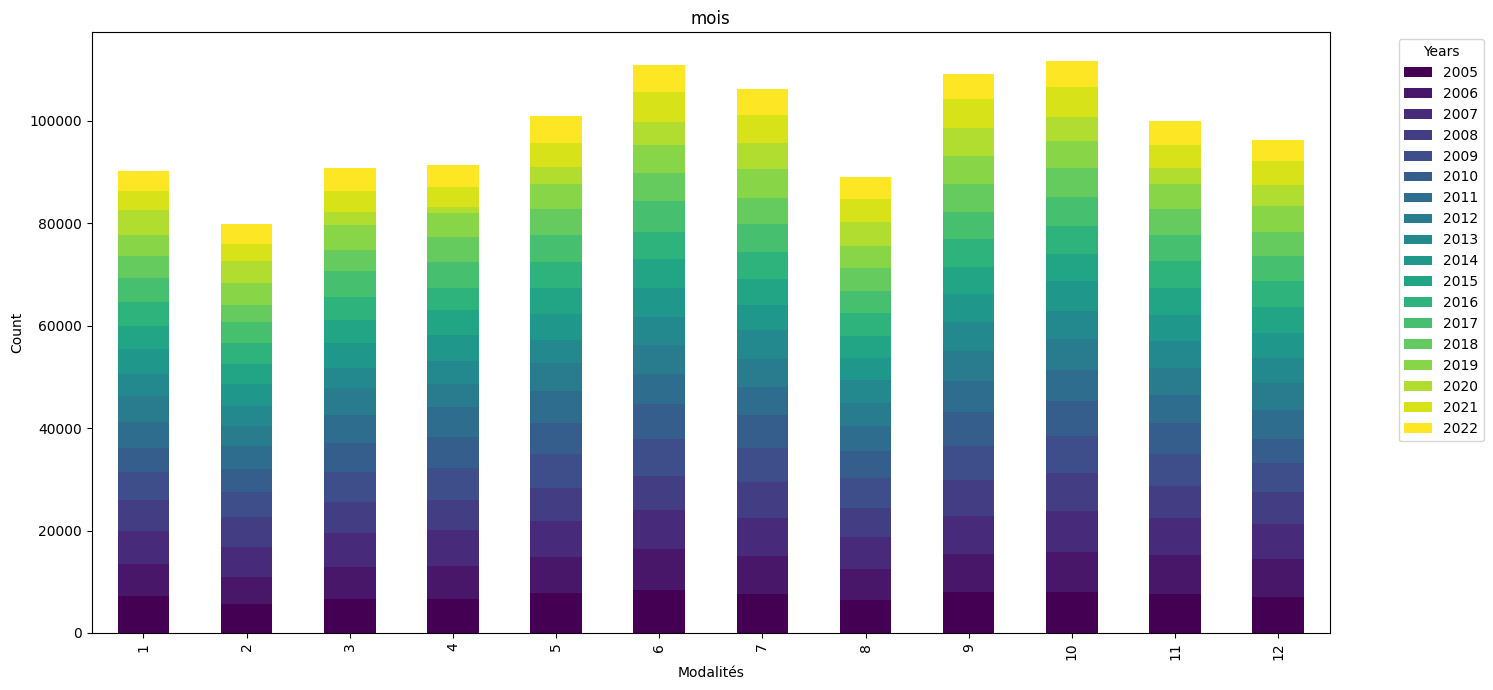

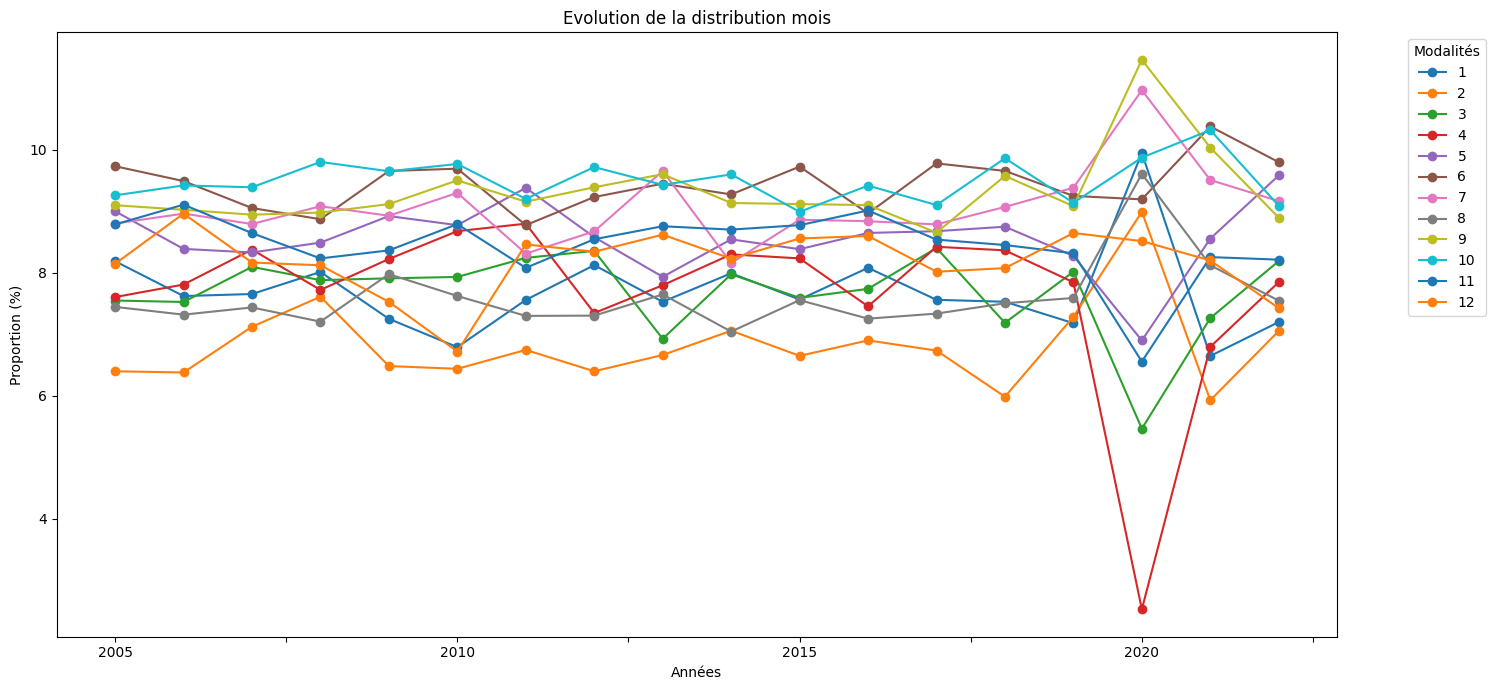

lignes: 1176873

Description: Heure et minutes de l'accident.
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64   1800                                        0                                    0
   2006  int64   1800                                        0                                    0
   2007  int64   1800                                        0                                    0
   2008  int64   1800                                        0                                    0
   2009  int64   1800                                        0                                    0
   2010  int64   1800                                        0                                    0
   2011  int64   1800                                        0                                    0
   2012  int64   1800                 

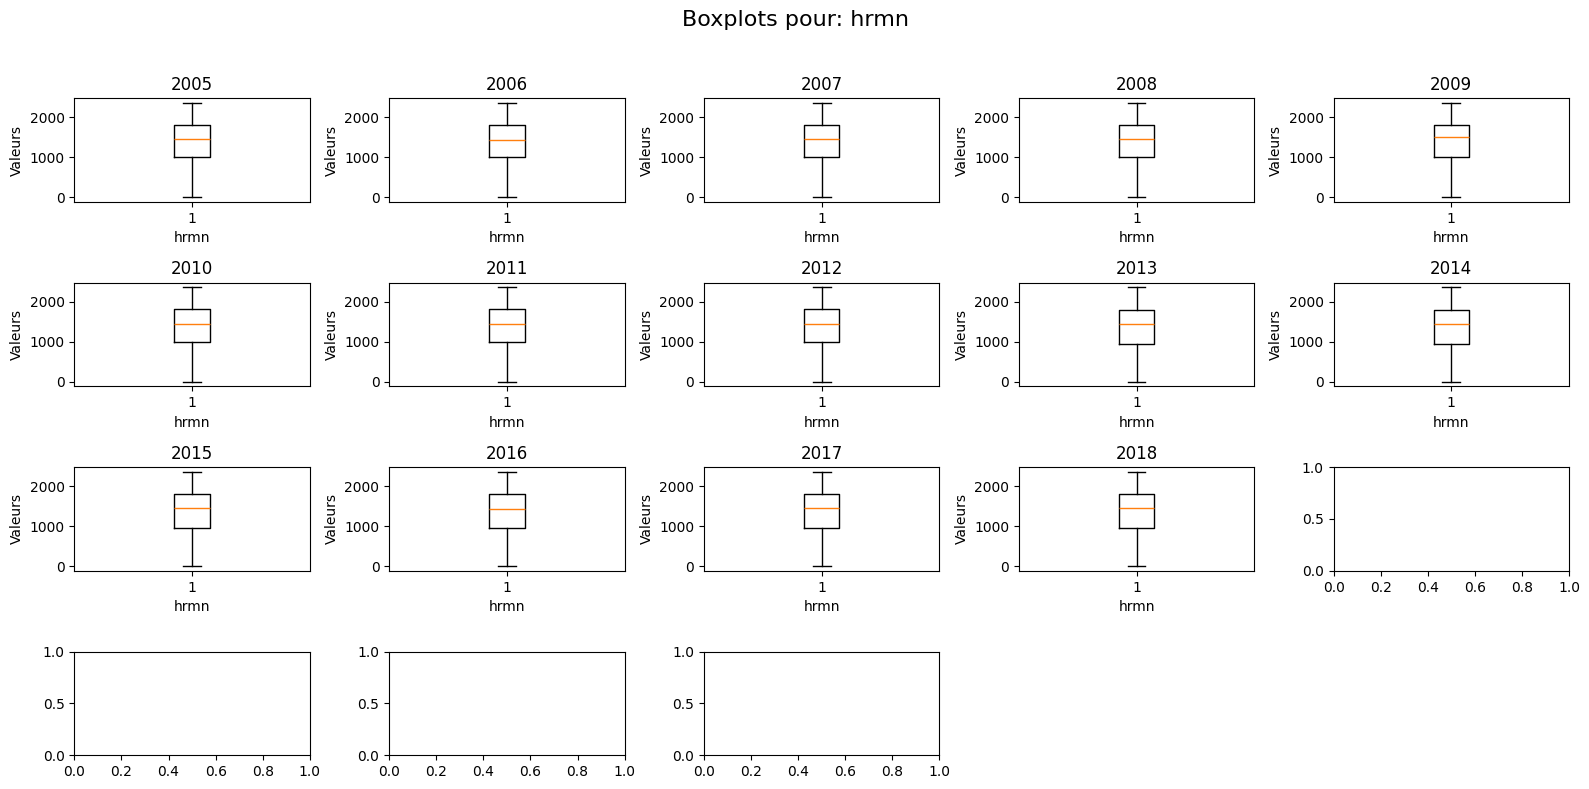

2024-11-25 11:20:23,910 - WARNING - Le nombre de modalités uniques dans la colonne hrmn excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:23,958 - WARNING - Le nombre de modalités uniques dans la colonne hrmn excède le seuil de 12. Aucun graphique en ligne généré.


Résumé pour lieux_data/raw\lieux_2005.csv:
Total Rows: 87026, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        8.65
v1          0.24
v2         97.55
circ        0.00
nbv         0.00
pr         45.40
pr1        45.40
vosp        0.00
prof        0.00
plan        0.00
lartpc      0.00
larrout     0.00
surf        0.00
infra       0.00
situ        0.00
env1        0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200500000001
catr                4.0
voie                0.0
v1                  0.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


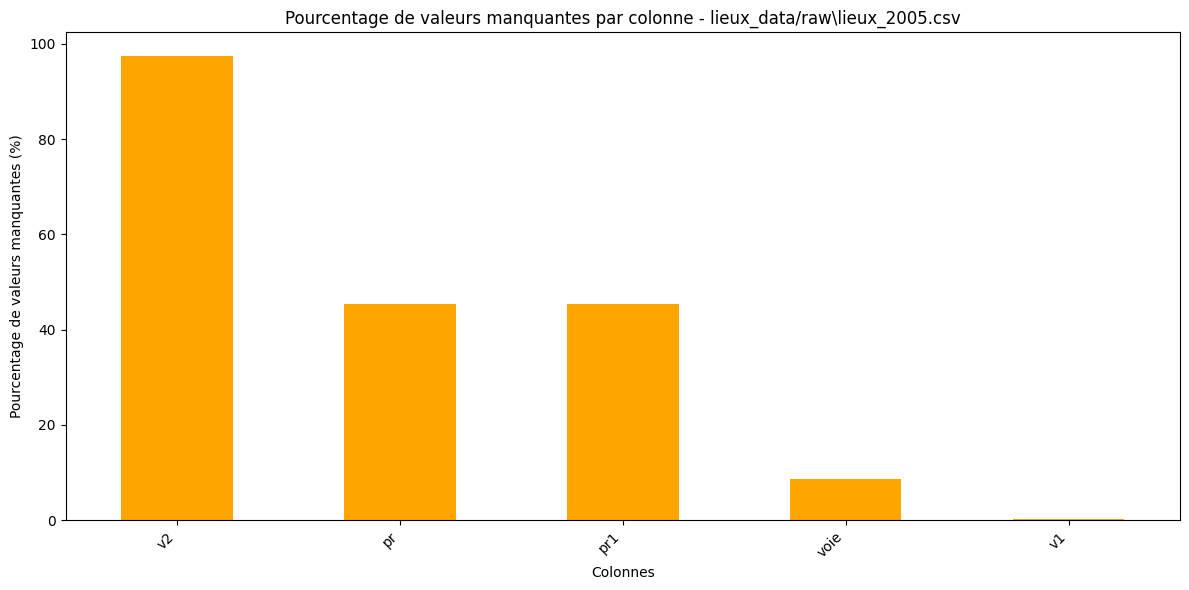

Résumé pour lieux_data/raw\lieux_2006.csv:
Total Rows: 82993, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        9.58
v1          0.04
v2         93.71
circ        0.00
nbv         0.00
pr         46.67
pr1        46.67
vosp        0.00
prof        0.00
plan        0.00
lartpc      0.00
larrout     0.00
surf        0.00
infra       0.00
situ        0.00
env1        0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200600000001
catr                4.0
voie                0.0
v1                  0.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


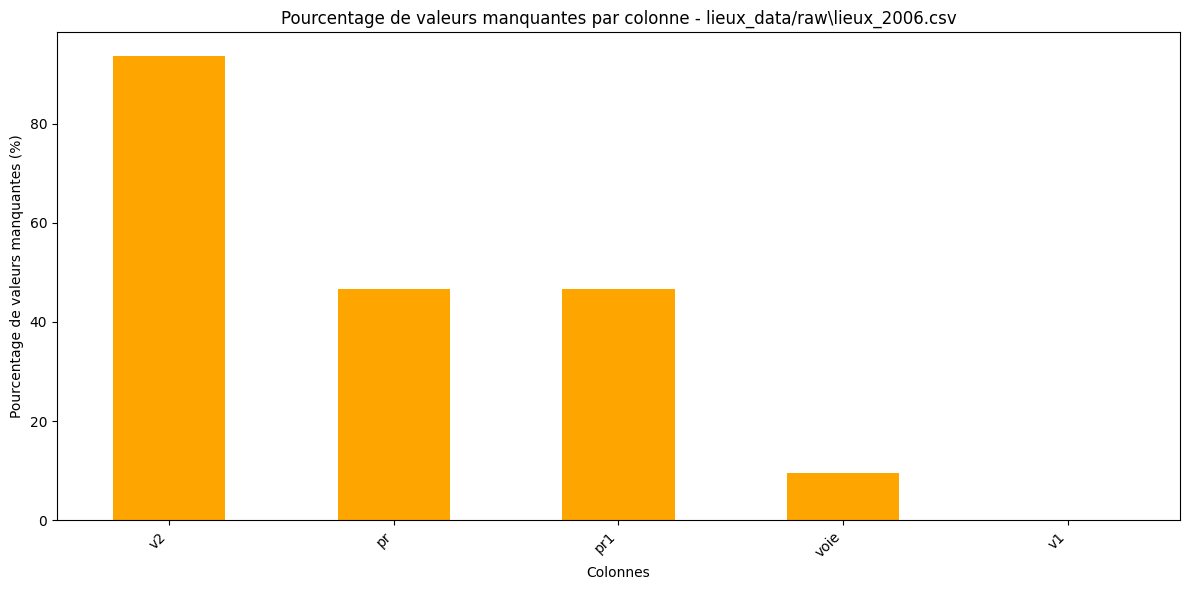

Résumé pour lieux_data/raw\lieux_2007.csv:
Total Rows: 83850, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        3.99
v1          0.01
v2         93.88
circ        0.00
nbv         0.00
pr         53.50
pr1        53.50
vosp        0.00
prof        0.00
plan        0.00
lartpc      0.00
larrout     0.00
surf        0.00
infra       0.00
situ        0.00
env1        0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200700000001
catr                4.0
voie                0.0
v1                  0.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


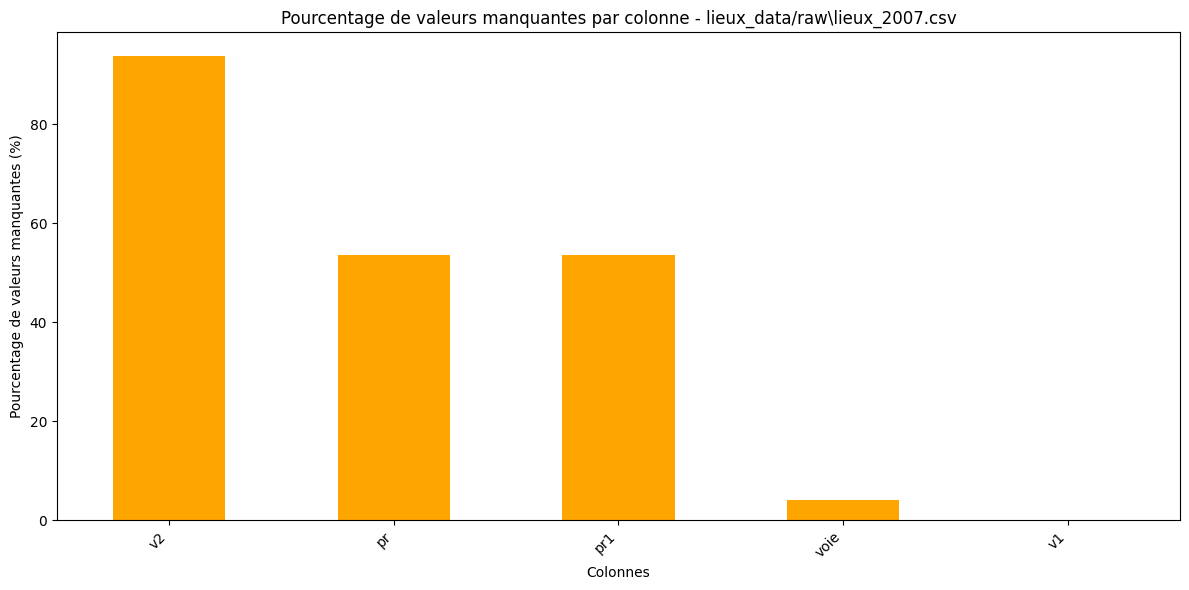

Résumé pour lieux_data/raw\lieux_2008.csv:
Total Rows: 76767, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        0.01
v1          0.01
v2         94.54
circ        0.00
nbv         0.00
pr         58.80
pr1        58.80
vosp        0.00
prof        0.00
plan        0.00
lartpc      0.00
larrout     0.00
surf        0.00
infra       0.00
situ        0.00
env1        0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200800000001
catr                4.0
voie                0.0
v1                  0.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


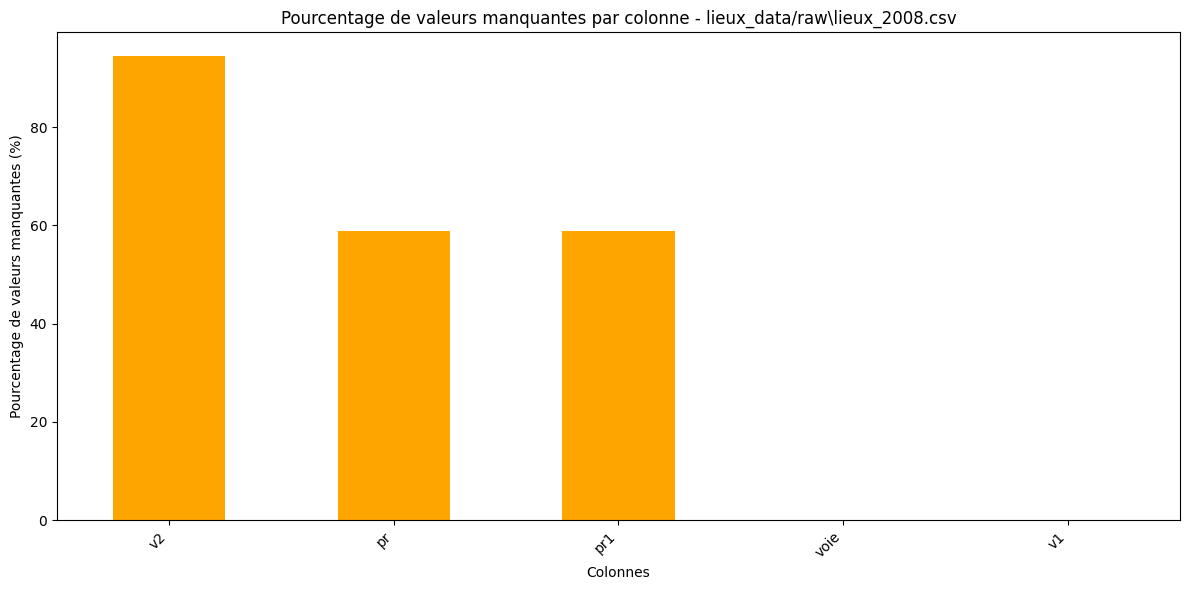

Résumé pour lieux_data/raw\lieux_2009.csv:
Total Rows: 74409, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        1.99
v1         99.55
v2         95.57
circ        0.08
nbv         0.86
pr         37.48
pr1        37.89
vosp        0.35
prof        0.11
plan        0.10
lartpc      0.73
larrout     0.48
surf        0.09
infra       0.23
situ        0.08
env1        0.20
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200900000001
catr                4.0
voie                0.0
v1                  2.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


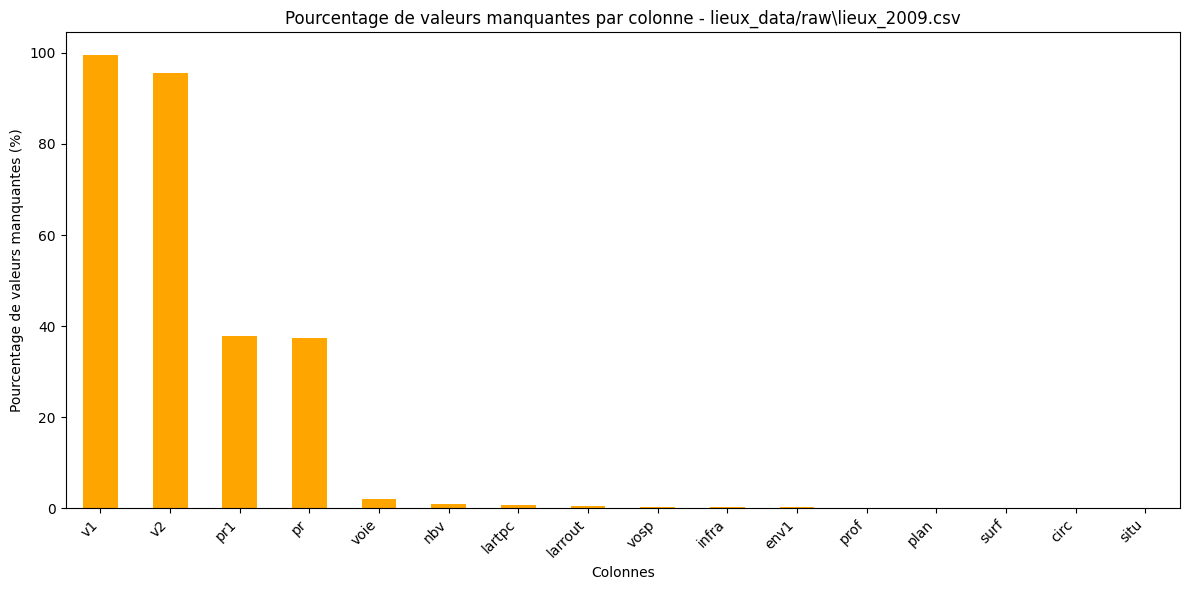

Résumé pour lieux_data/raw\lieux_2010.csv:
Total Rows: 69379, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        2.23
v1         99.64
v2         97.06
circ        0.06
nbv         0.15
pr         40.51
pr1        40.68
vosp        0.16
prof        0.06
plan        0.06
lartpc      0.67
larrout     0.53
surf        0.06
infra       0.08
situ        0.04
env1        0.10
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201000000001
catr                4.0
voie                0.0
v1                  2.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


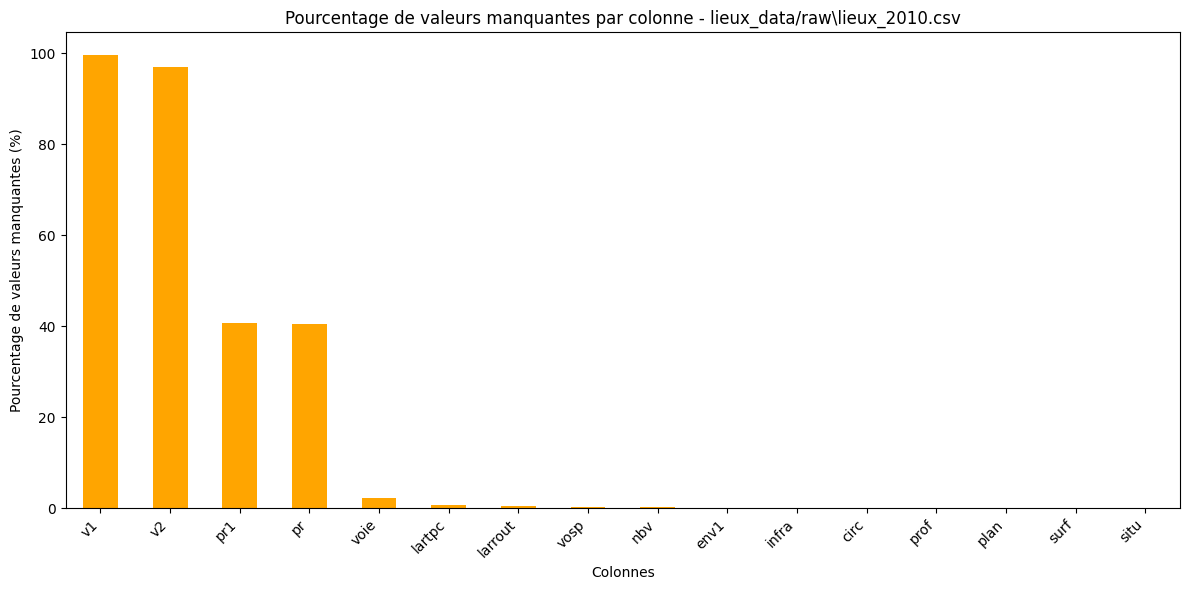

Résumé pour lieux_data/raw\lieux_2011.csv:
Total Rows: 66974, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        7.15
v1         99.63
v2         97.00
circ        0.17
nbv         0.27
pr         51.36
pr1        51.47
vosp        0.27
prof        0.19
plan        0.19
lartpc      1.03
larrout     0.89
surf        0.19
infra       0.19
situ        0.16
env1        0.19
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201100000001
catr                4.0
voie                0.0
v1                  2.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


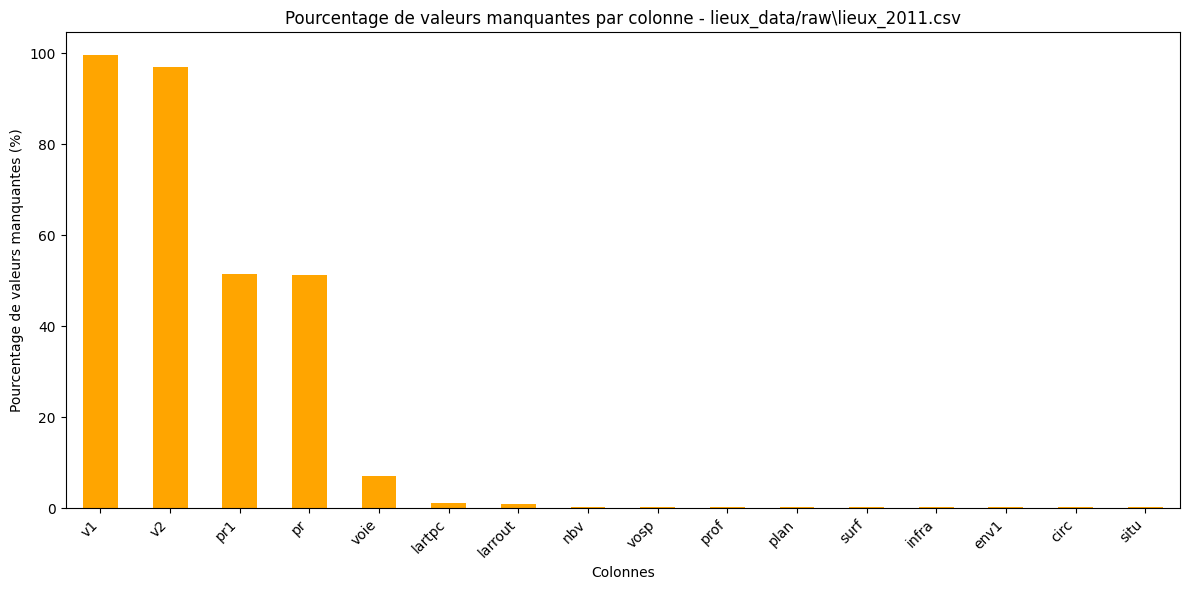

Résumé pour lieux_data/raw\lieux_2012.csv:
Total Rows: 62250, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie       11.29
v1         99.60
v2         96.10
circ        0.35
nbv         0.42
pr         54.22
pr1        54.52
vosp        0.51
prof        0.44
plan        0.44
lartpc      1.80
larrout     1.48
surf        0.45
infra       0.44
situ        0.39
env1        0.43
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201200000001
catr                4.0
voie                0.0
v1                  2.0
v2                    0
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


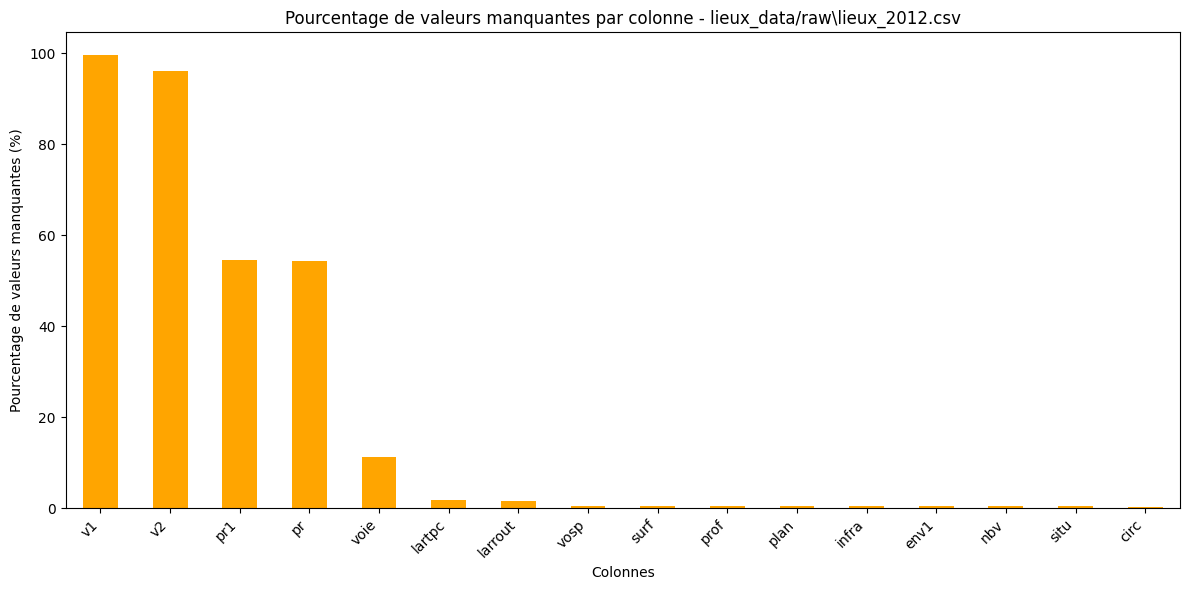

Résumé pour lieux_data/raw\lieux_2013.csv:
Total Rows: 58397, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        7.91
v1         99.64
v2         97.08
circ        0.11
nbv         0.18
pr         54.64
pr1        55.00
vosp        0.23
prof        0.16
plan        0.17
lartpc      2.41
larrout     2.14
surf        0.15
infra       0.14
situ        0.11
env1        0.15
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201300000001
catr                4.0
voie                0.0
v1                  2.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


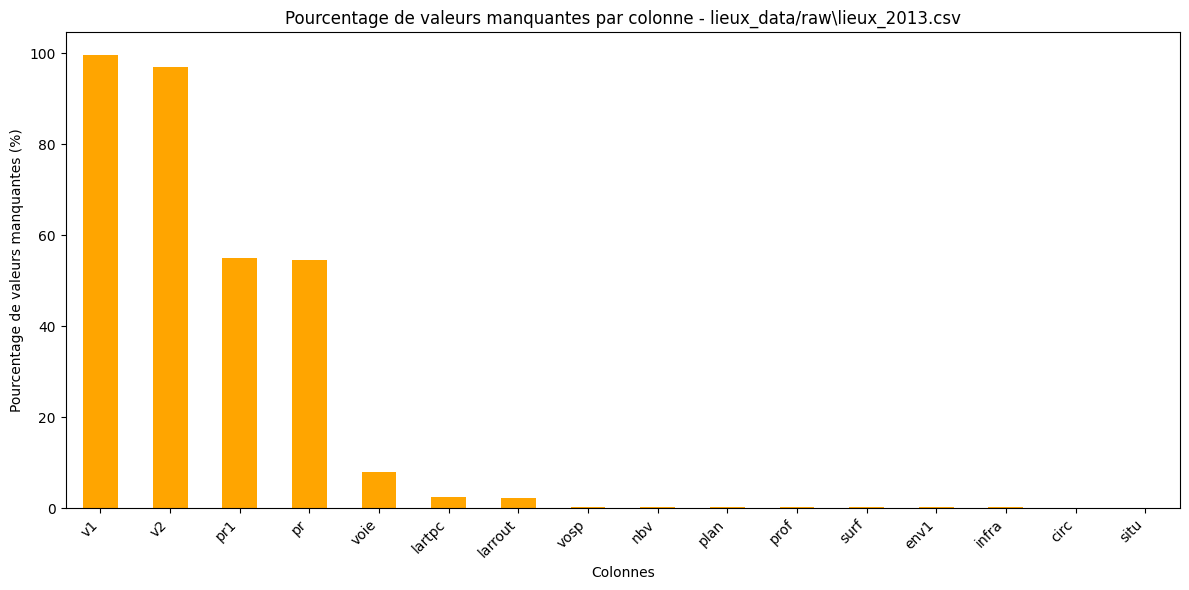

Résumé pour lieux_data/raw\lieux_2014.csv:
Total Rows: 59854, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        6.45
v1         99.59
v2         96.89
circ        0.13
nbv         0.24
pr         54.53
pr1        54.85
vosp        0.31
prof        0.24
plan        0.24
lartpc      2.79
larrout     2.56
surf        0.25
infra       0.19
situ        0.17
env1        0.21
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201400000001
catr                4.0
voie                0.0
v1                  2.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


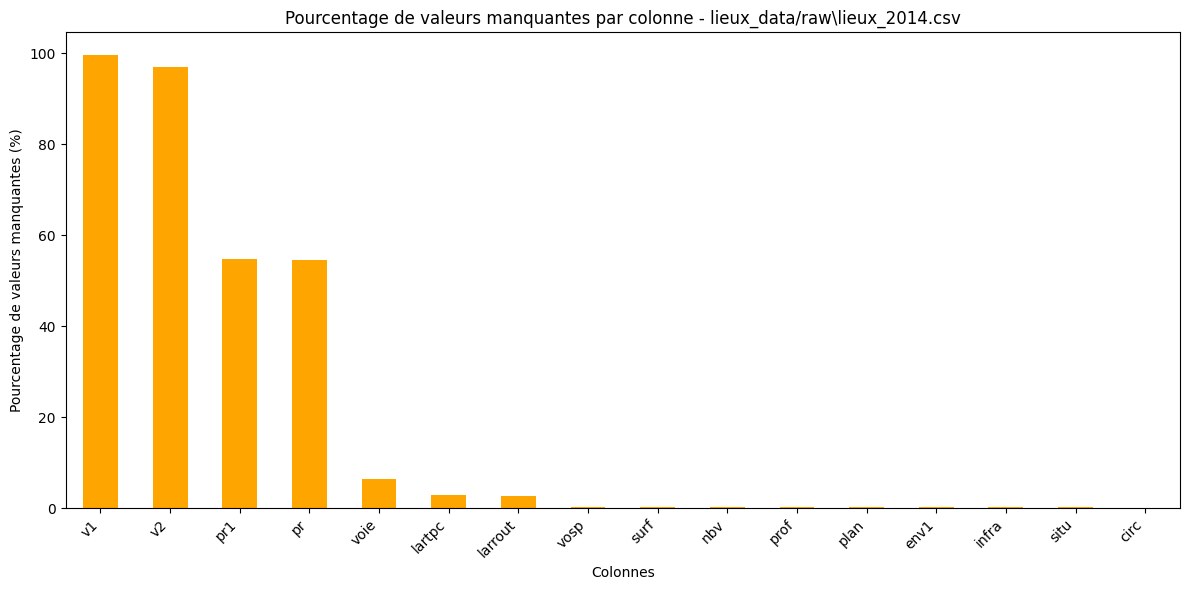

Résumé pour lieux_data/raw\lieux_2015.csv:
Total Rows: 58654, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        7.66
v1         99.26
v2         96.76
circ        0.17
nbv         0.32
pr         57.65
pr1        57.96
vosp        0.40
prof        0.25
plan        0.24
lartpc      3.08
larrout     2.78
surf        0.20
infra       0.25
situ        0.19
env1        0.24
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201500000001
catr                4.0
voie                0.0
v1                  2.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


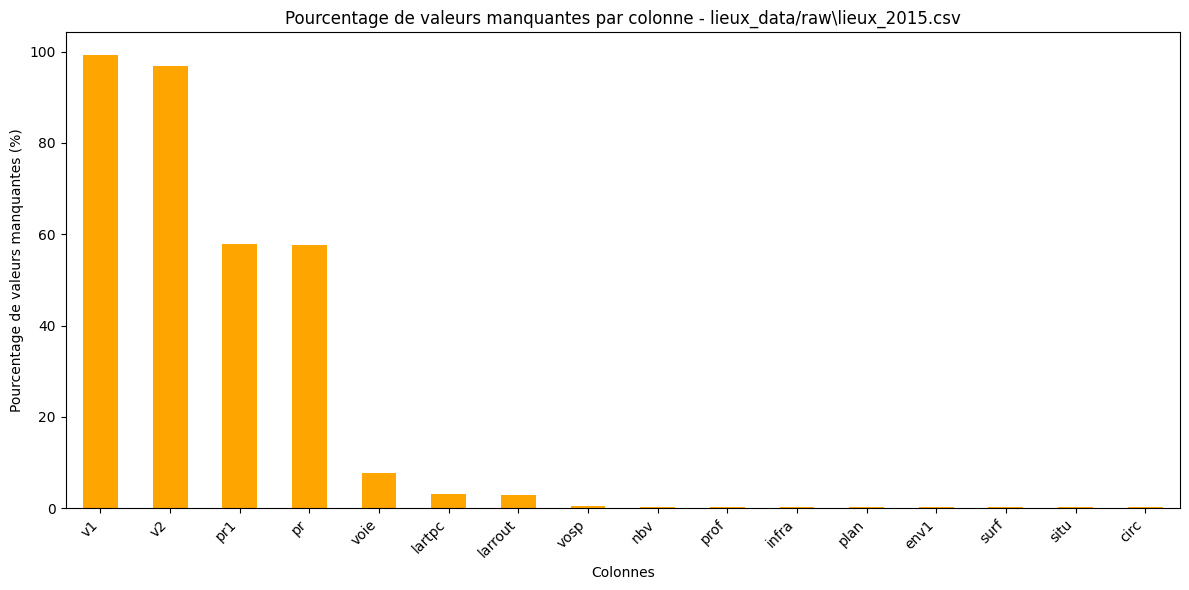

Résumé pour lieux_data/raw\lieux_2016.csv:
Total Rows: 59432, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie       17.80
v1         99.23
v2         96.56
circ        0.19
nbv         0.28
pr         58.00
pr1        58.07
vosp        0.35
prof        0.26
plan        0.30
lartpc      3.09
larrout     2.73
surf        0.25
infra       0.51
situ        0.49
env1        0.52
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201600000001
catr                4.0
voie                  0
v1                  2.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1               99.0
Name: 0, dtype: object


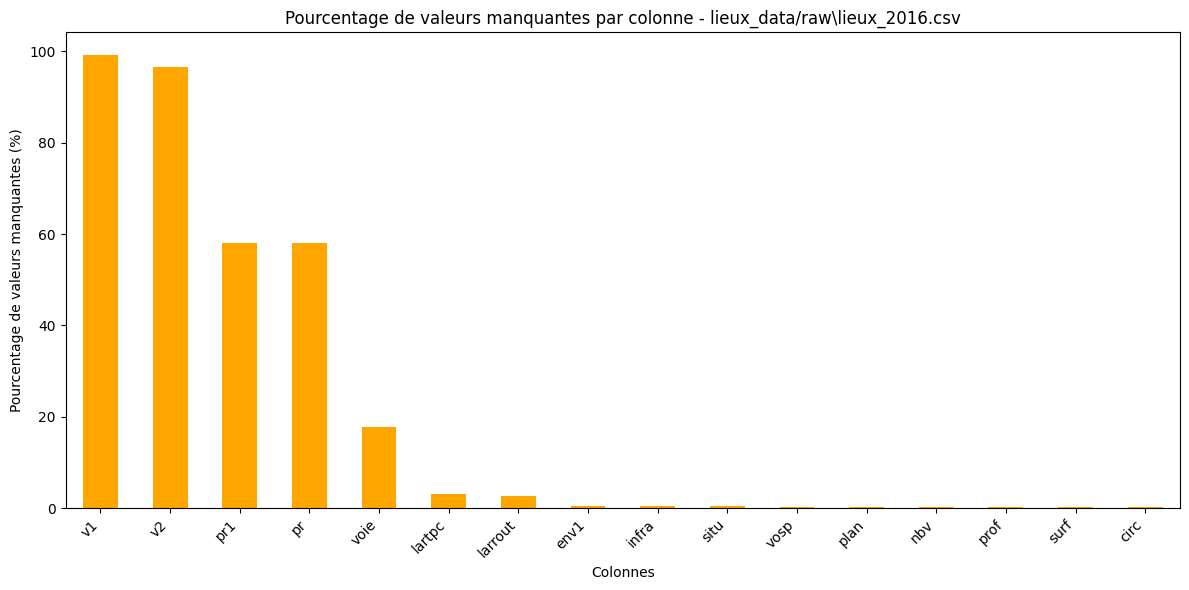

Résumé pour lieux_data/raw\lieux-2017.csv:
Total Rows: 60701, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie       16.12
v1         99.33
v2         95.56
circ        0.61
nbv         0.71
pr         56.83
pr1        57.22
vosp        0.98
prof        0.74
plan        1.29
lartpc      3.56
larrout     3.33
surf        0.77
infra       6.04
situ        5.72
env1        6.10
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201700000001
catr                4.0
voie                  0
v1                  2.0
v2                    A
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1               99.0
Name: 0, dtype: object


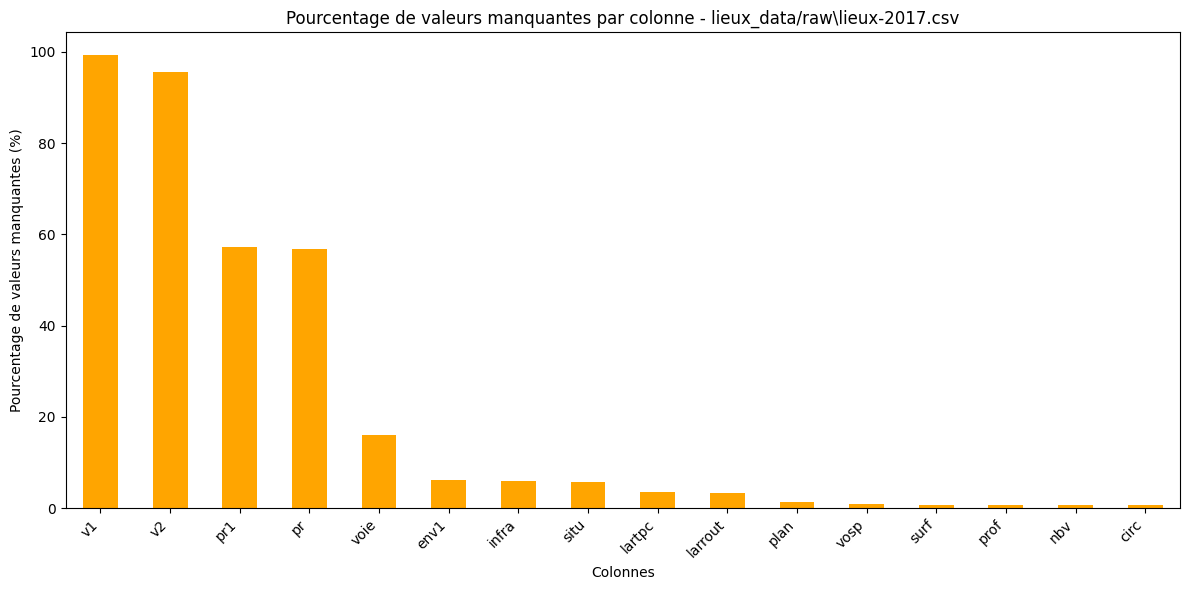

Résumé pour lieux_data/raw\lieux-2018.csv:
Total Rows: 57783, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie       37.89
v1         99.71
v2         95.33
circ        0.70
nbv         0.88
pr         27.30
pr1        27.77
vosp        0.91
prof        0.76
plan        0.73
lartpc     76.99
larrout    76.28
surf        0.76
infra       0.81
situ        0.85
env1        0.79
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201800000001
catr                4.0
voie                  0
v1                  2.0
v2                    D
circ                2.0
nbv                 2.0
pr                  0.0
pr1                 0.0
vosp                0.0
prof                1.0
plan                1.0
lartpc              0.0
larrout             0.0
surf                1.0
infra               0.0
situ                1.0
env1                0.0
Name: 0, dtype: object


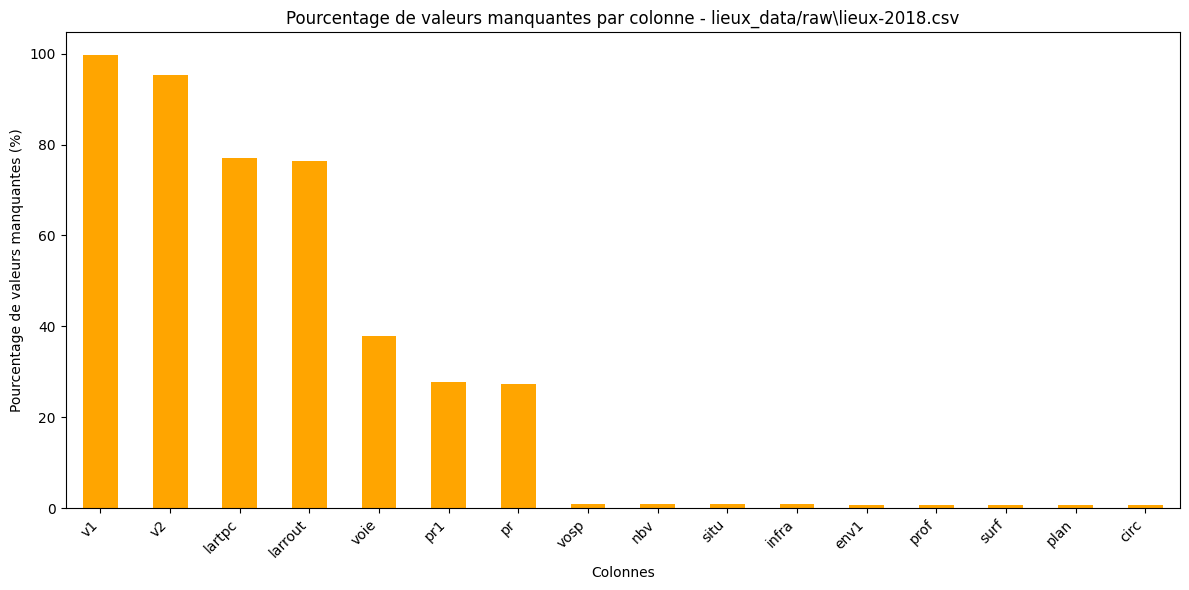

Résumé pour lieux_data/raw\lieux-2019.csv:
Total Rows: 58840, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        4.99
v1         18.26
v2         92.92
circ        0.00
nbv         0.00
vosp        0.00
prof        0.00
pr          0.00
pr1         0.00
plan        0.00
lartpc     99.64
larrout    99.37
surf        0.00
infra       0.00
situ        0.00
vma         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201900000001
catr                4.0
voie                  1
v1                  0.0
v2                    D
circ                2.0
nbv                 2.0
vosp                0.0
prof                1.0
pr                    0
pr1                   0
plan                1.0
lartpc              0.0
larrout             7.0
surf                1.0
infra               0.0
situ                1.0
vma                50.0
Name: 0, dtype: object


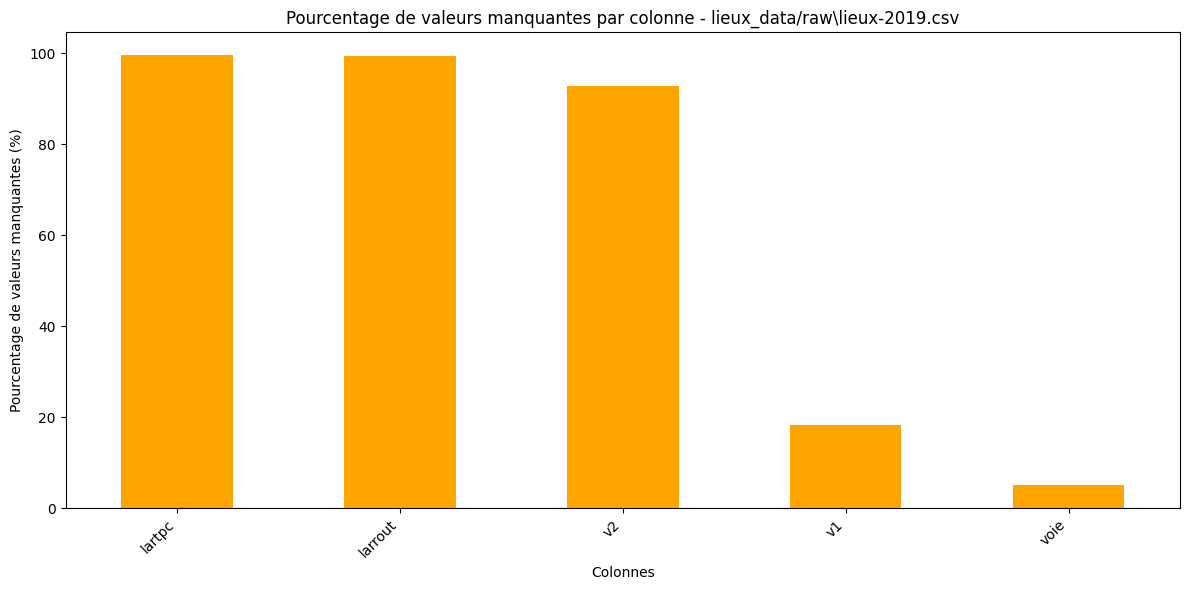

Résumé pour lieux_data/raw\lieux-2020.csv:
Total Rows: 47744, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie       22.89
v1          0.00
v2         94.00
circ        0.00
nbv         0.00
vosp        0.00
prof        0.00
pr          0.00
pr1         0.00
plan        0.00
lartpc     99.69
larrout     0.00
surf        0.00
infra       0.00
situ        0.00
vma         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    202000000001
catr                4.0
voie                  1
v1                  0.0
v2                    D
circ                2.0
nbv                 2.0
vosp                0.0
prof                1.0
pr                    0
pr1                   0
plan                1.0
lartpc                0
larrout              -1
surf                1.0
infra               0.0
situ                1.0
vma                50.0
Name: 0, dtype: object


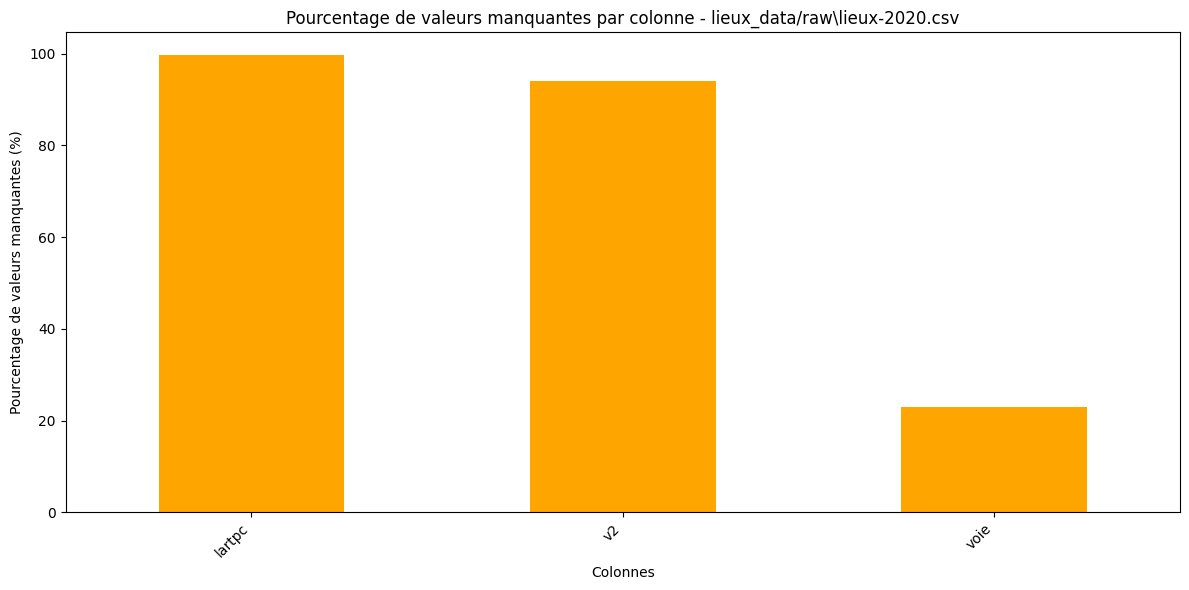

Résumé pour lieux_data/raw\lieux-2021.csv:
Total Rows: 56518, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        7.80
v1          0.00
v2         91.17
circ        0.00
nbv         0.00
vosp        0.00
prof        0.00
pr          0.00
pr1         0.00
plan        0.00
lartpc     99.81
larrout     0.00
surf        0.00
infra       0.00
situ        0.00
vma         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    202100000001
catr                4.0
voie                  1
v1                  0.0
v2                    D
circ                2.0
nbv                 2.0
vosp                0.0
prof                1.0
pr                  (1)
pr1                 (1)
plan                1.0
lartpc                0
larrout              -1
surf                1.0
infra               0.0
situ                1.0
vma                50.0
Name: 0, dtype: object


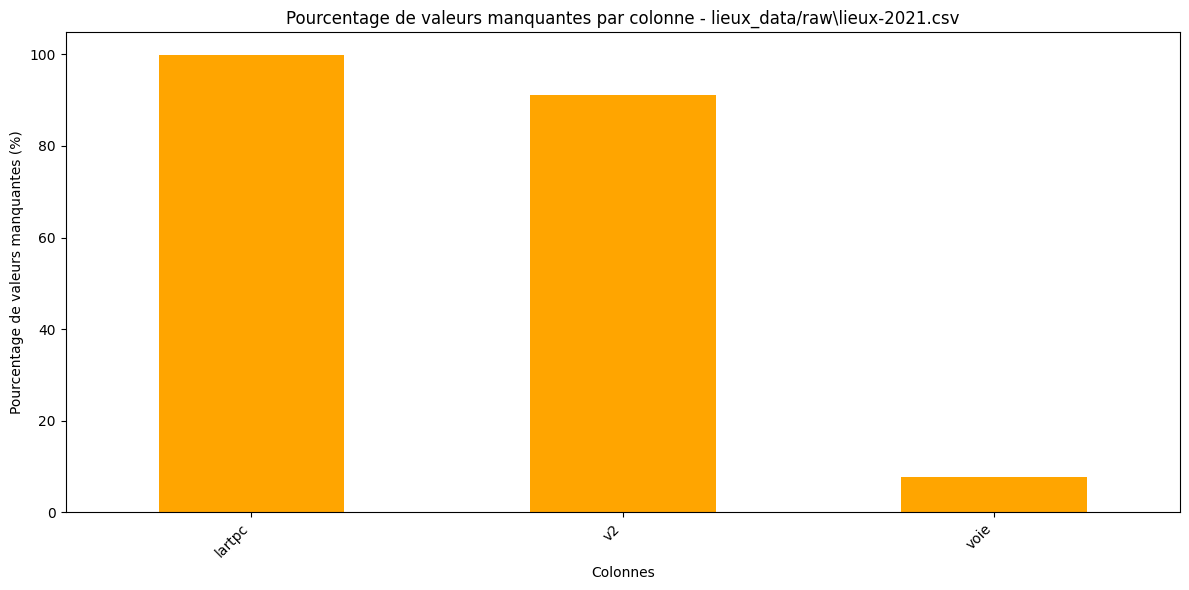

Résumé pour lieux_data/raw\lieux-2022.csv:
Total Rows: 55302, Total Columns: 18
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
catr        0.00
voie        8.69
v1          0.00
v2         90.50
circ        0.00
nbv         0.00
vosp        0.00
prof        0.00
pr          0.00
pr1         0.00
plan        0.00
lartpc     99.95
larrout     0.00
surf        0.00
infra       0.00
situ        0.00
vma         0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    202200000001
catr                4.0
voie                  1
v1                  0.0
v2                    D
circ                2.0
nbv                   2
vosp                0.0
prof                1.0
pr                  (1)
pr1                 (1)
plan                1.0
lartpc                3
larrout              -1
surf                1.0
infra               0.0
situ                1.0
vma                50.0
Name: 0, dtype: object


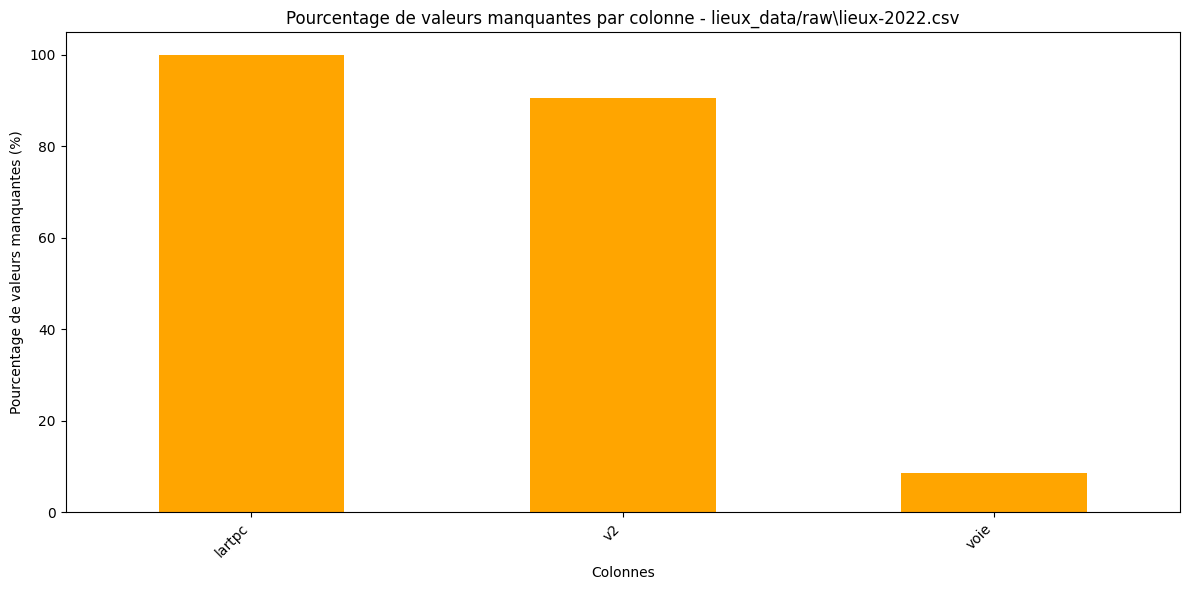

2024-11-25 11:20:28,477 - INFO - Chargement de lieux.


lignes: 1176873

Description: Identifiant de l’accident identique à celui du fichier "rubrique CARACTERISTIQUES" repris dans l’accident.
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11             

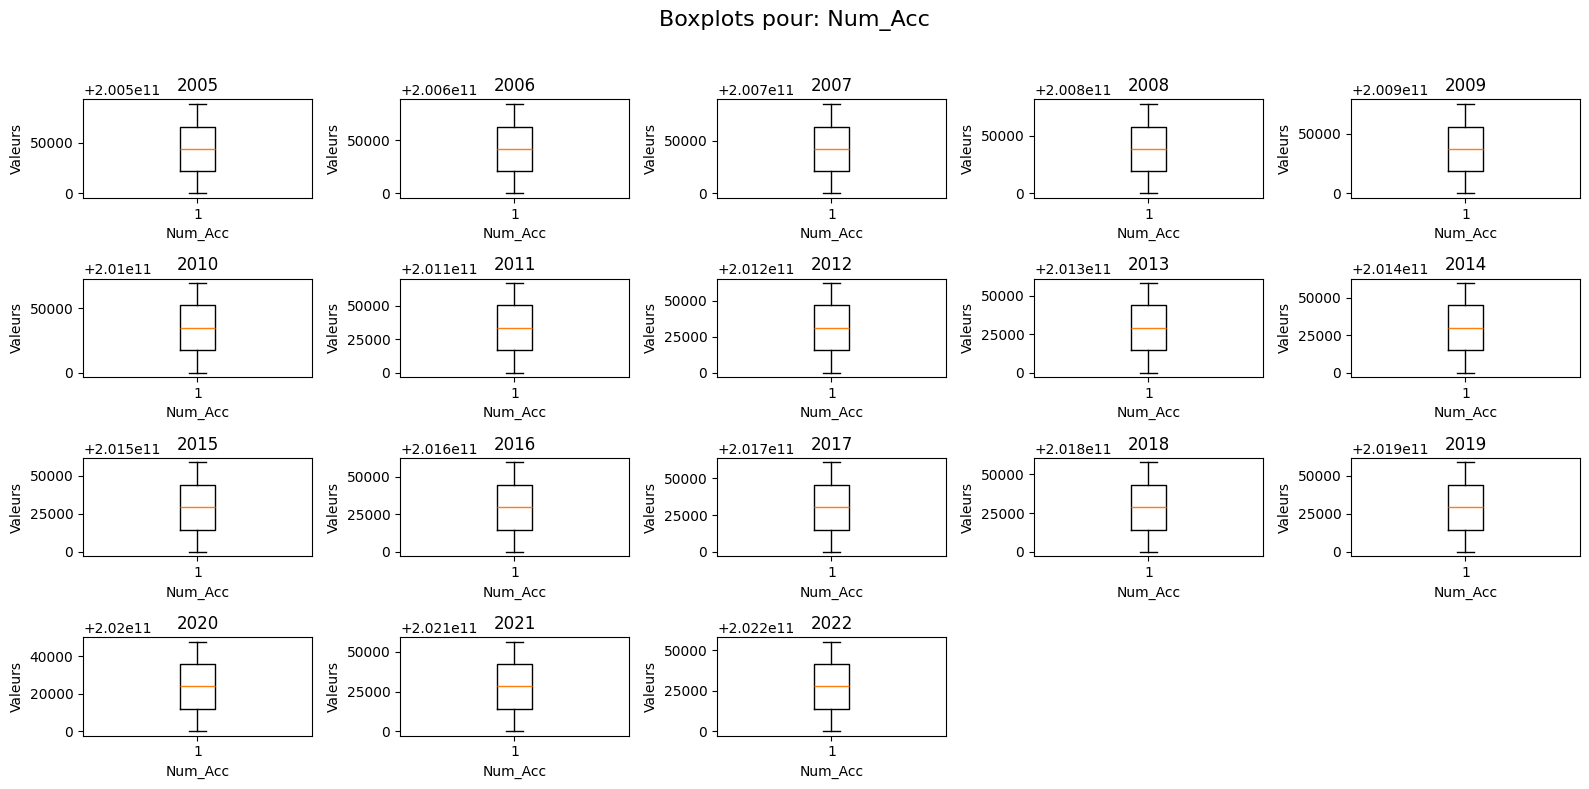

2024-11-25 11:20:30,585 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:30,812 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Tracé en plan :

Modalités:
- -1: Non renseigné
- 1: Partie rectiligne
- 2: En courbe à gauche
- 3: En courbe à droite
- 4: En « S »
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.100794                           6.37282e-05
   2010  float64       1                              0.0619784                          3.65375e-05
   2011  float64       1                              0.191119       

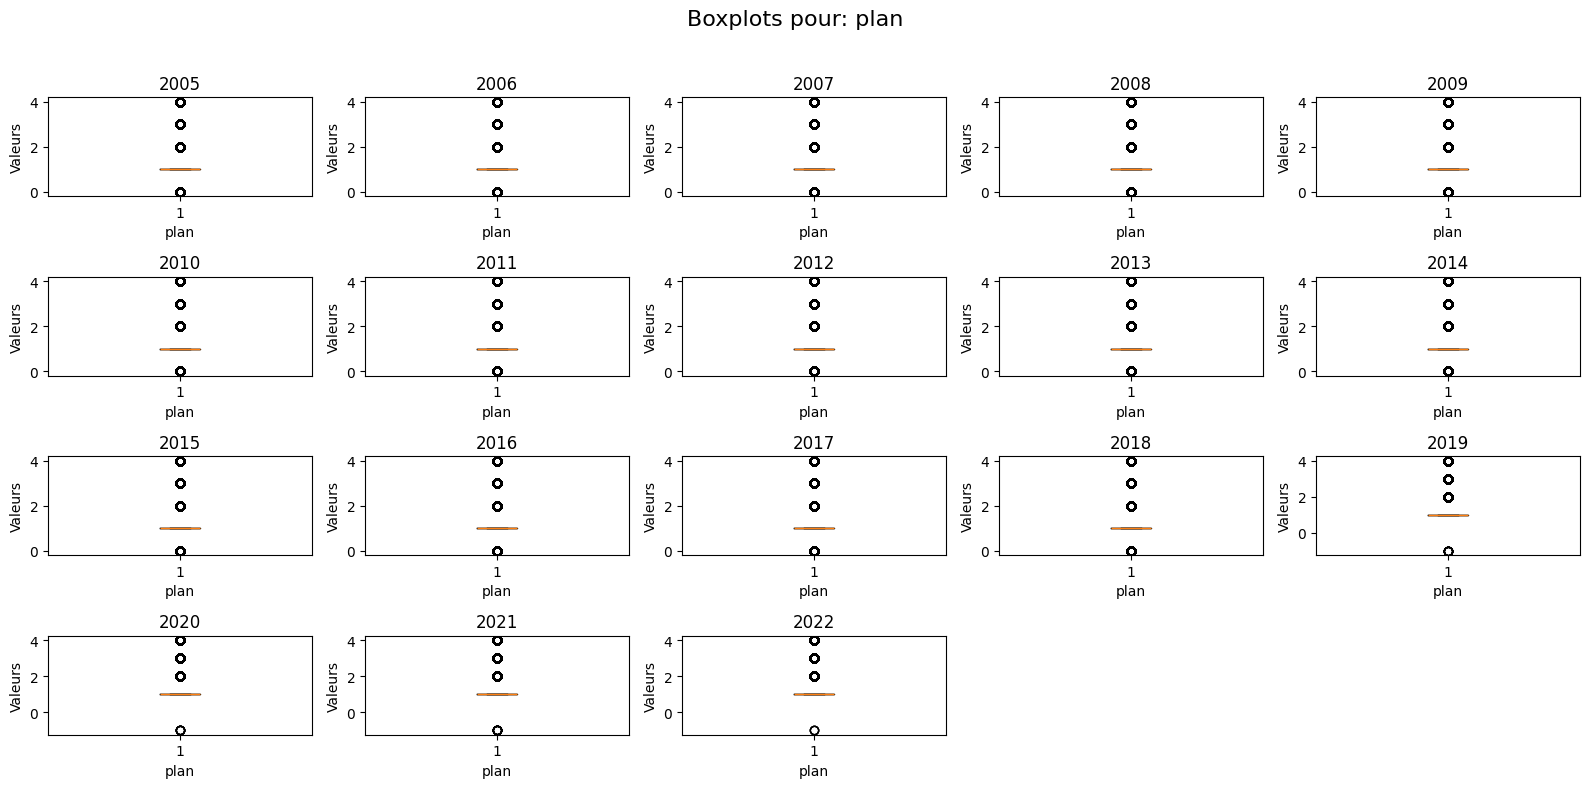

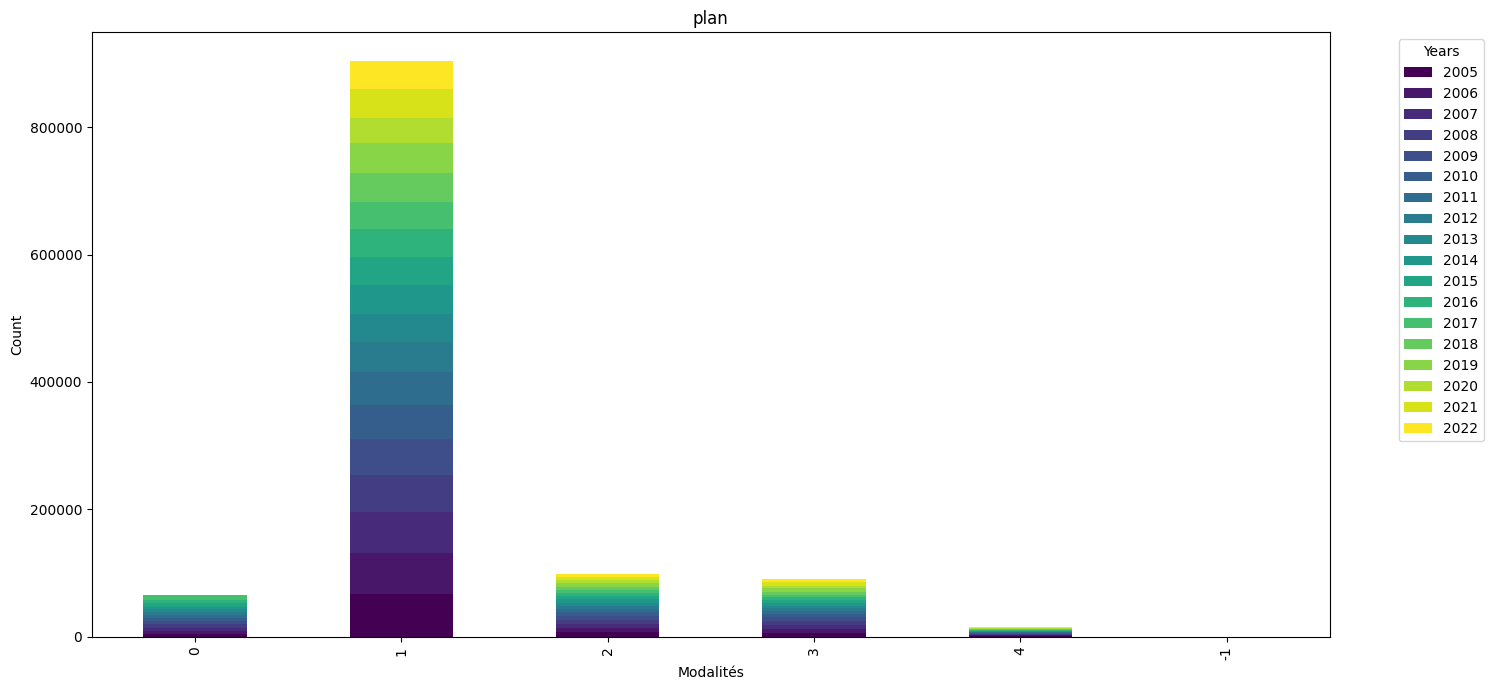

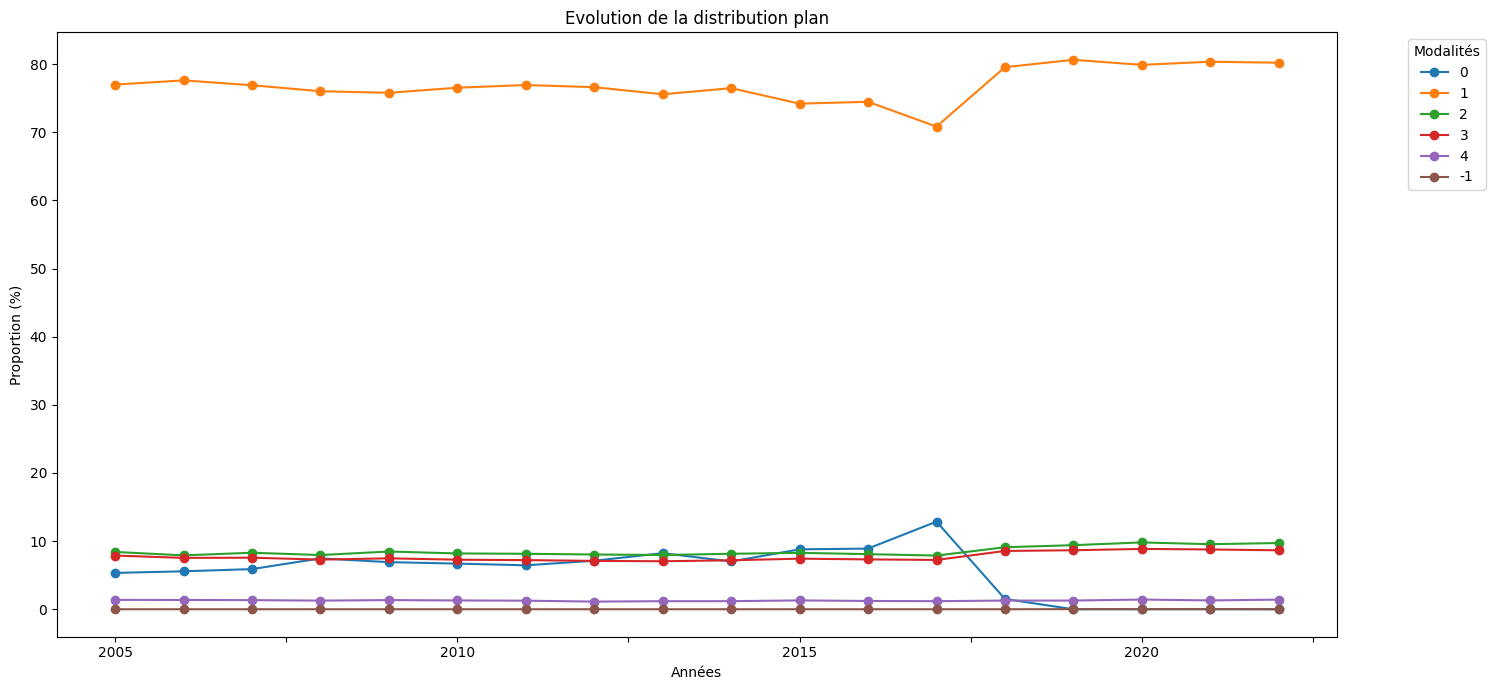

lignes: 1176873

Description: Nombre total de voies de circulation.
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                               0                                 0
   2006  int64         2                               0                                 0
   2007  int64         2                               0                                 0
   2008  int64         2                               0                                 0
   2009  float64       2                               0.862799                          0.000545513
   2010  float64       2                               0.147019                          8.66704e-05
   2011  float64       2                               0.267268                          0.000152098
   2012  float64       2                               0.424096

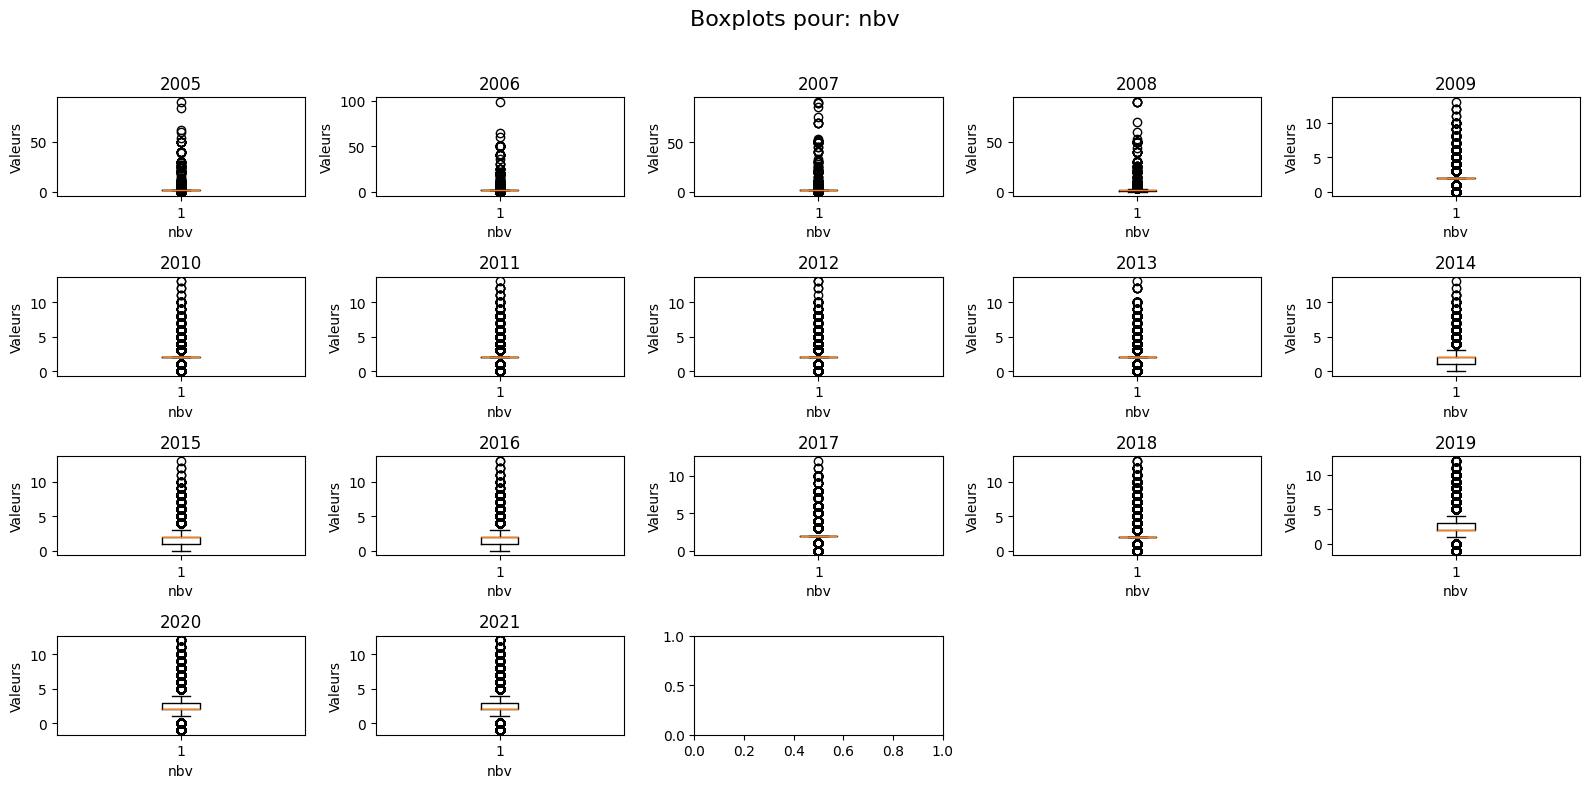

2024-11-25 11:20:35,657 - WARNING - Le nombre de modalités uniques dans la colonne nbv excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:35,677 - WARNING - Le nombre de modalités uniques dans la colonne nbv excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Numéro du PR de rattachement (numéro de la borne amont). La valeur -1 signifie que le PR n’est pas renseigné.
  Année  Type     Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                   45.4014                            0.0335729
   2006  float64  0.0                                   46.6678                            0.0329101
   2007  float64  0.0                                   53.5015                            0.0381188
   2008  float64  0.0                                   58.8039                            0.0383576
   2009  float64  0.0                                   37.4753                            0.0236941
   2010  float64  0.0                                   40.5137                            0.0238836
   2011  float64  0.0                               

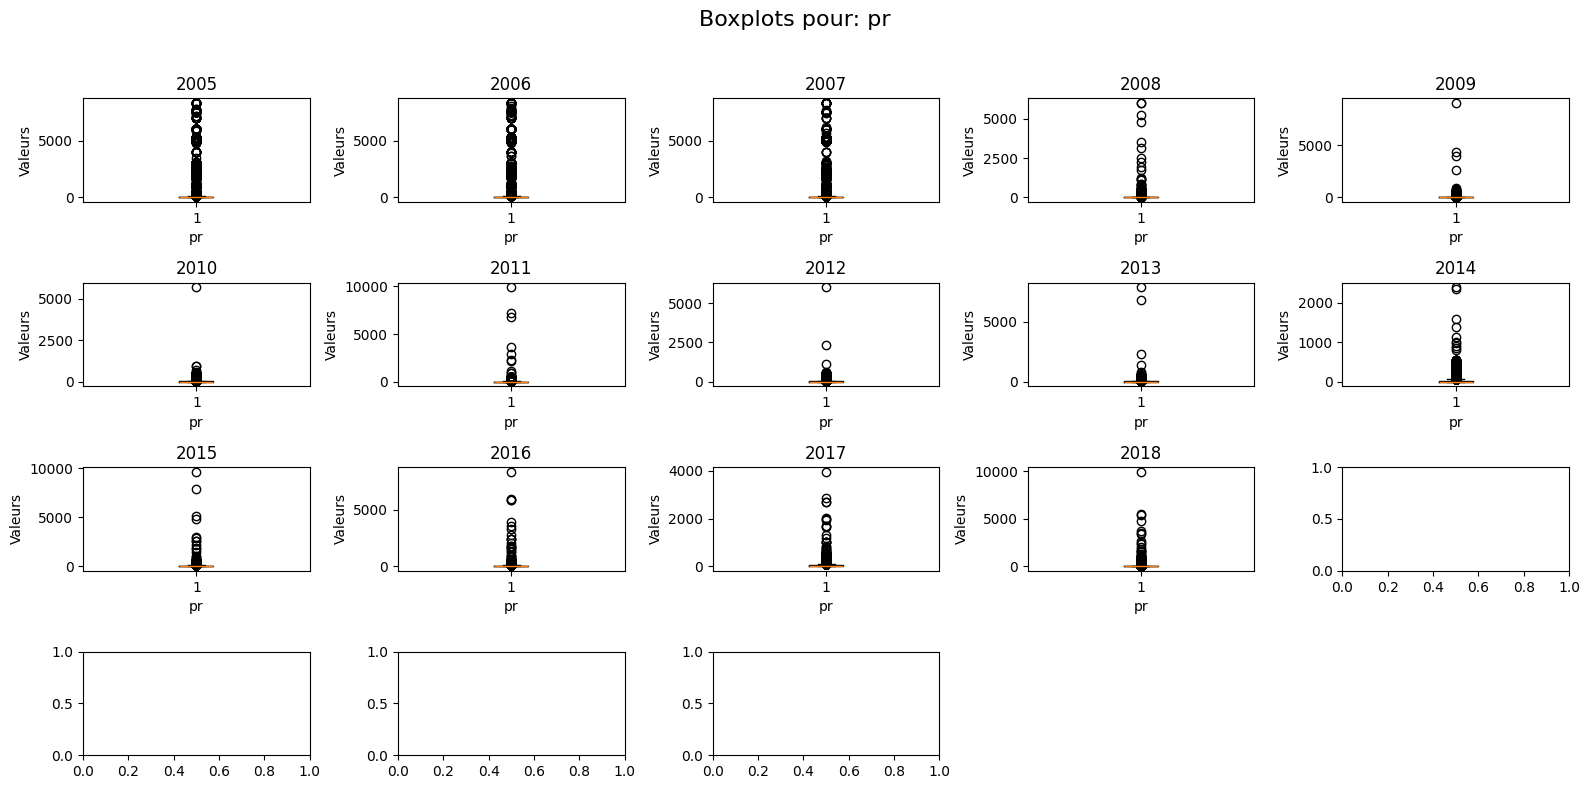

2024-11-25 11:20:37,426 - WARNING - Le nombre de modalités uniques dans la colonne pr excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:37,468 - WARNING - Le nombre de modalités uniques dans la colonne pr excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Situation de l’accident :

Modalités:
- -1: Non renseigné
- 0: Aucun
- 1: Sur chaussée
- 2: Sur bande d’arrêt d’urgence
- 3: Sur accotement
- 4: Sur trottoir
- 5: Sur piste cyclable
- 6: Sur autre voie spéciale
- 8: Autres
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0792915                          5.01329e-05
   2010  float64       1                              0.0446821                 

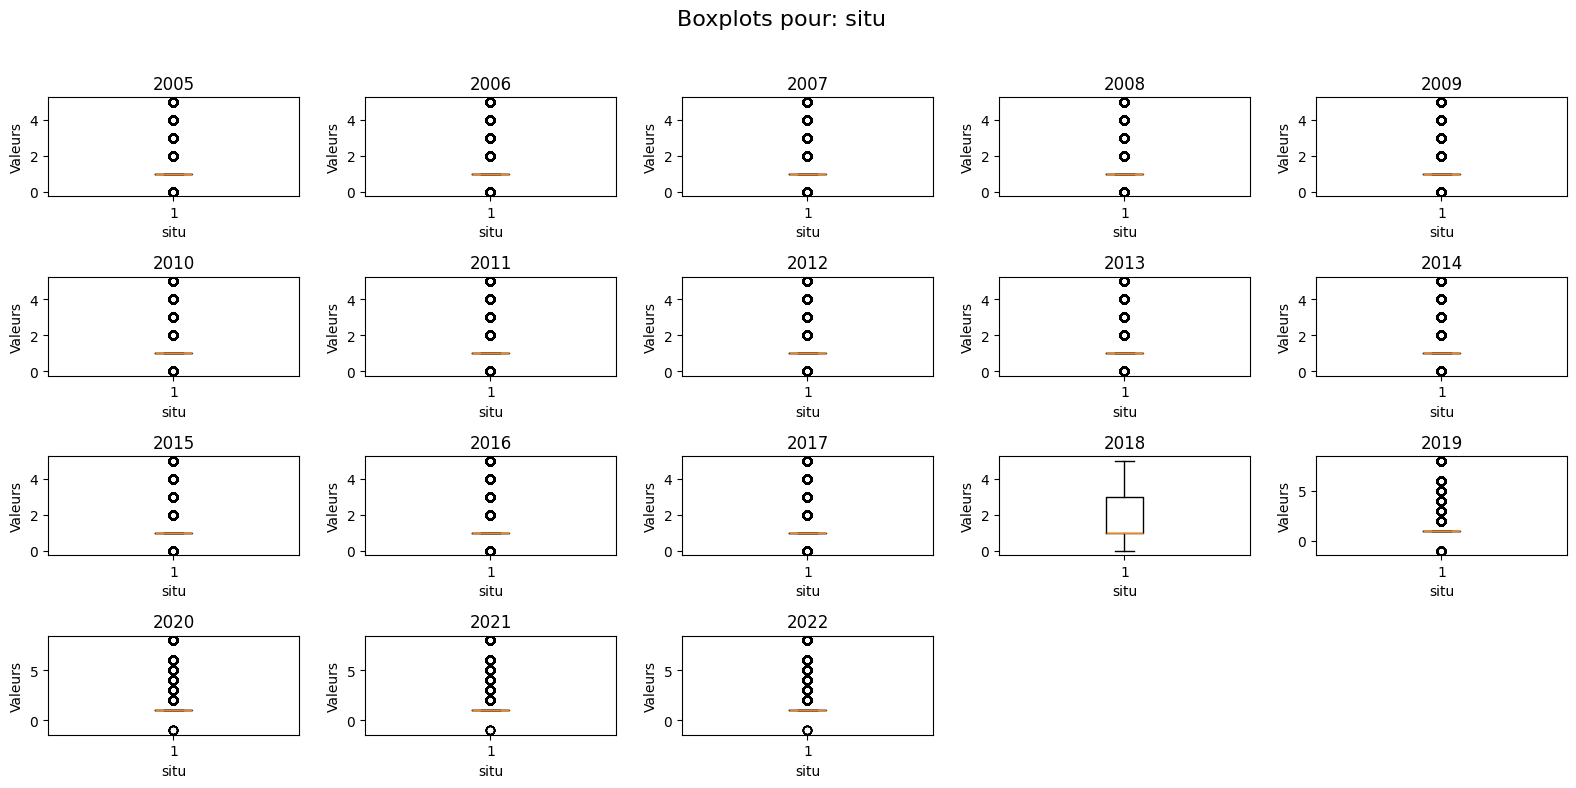

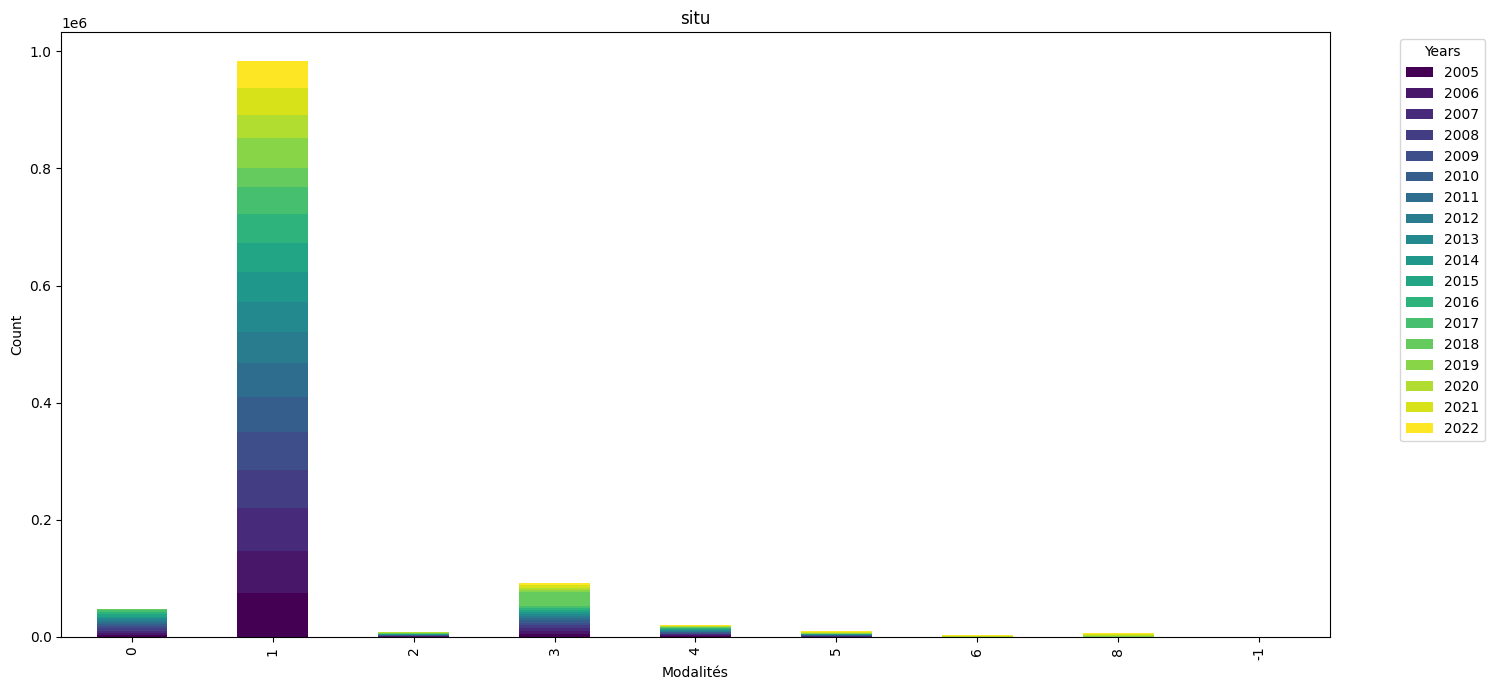

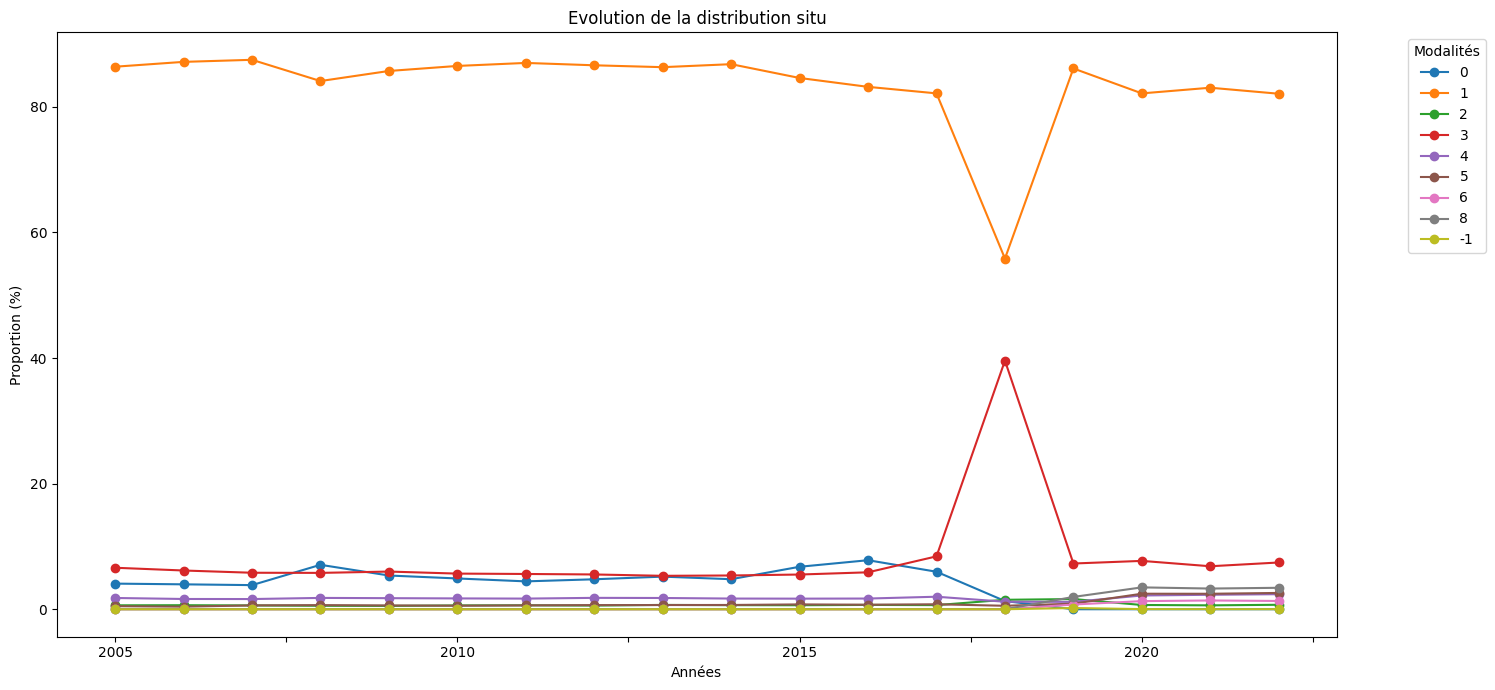

2024-11-25 11:20:40,107 - INFO - Pas de description pour `env1` dans la section `LIEUX`.


lignes: 1176873

  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.200245                          0.000126607
   2010  float64       0                               0.102336                          6.03294e-05
   2011  float64       0                               0.192612                          0.000109613
   2012  float64       0                               0.432129                          0.000228572
   2013  floa

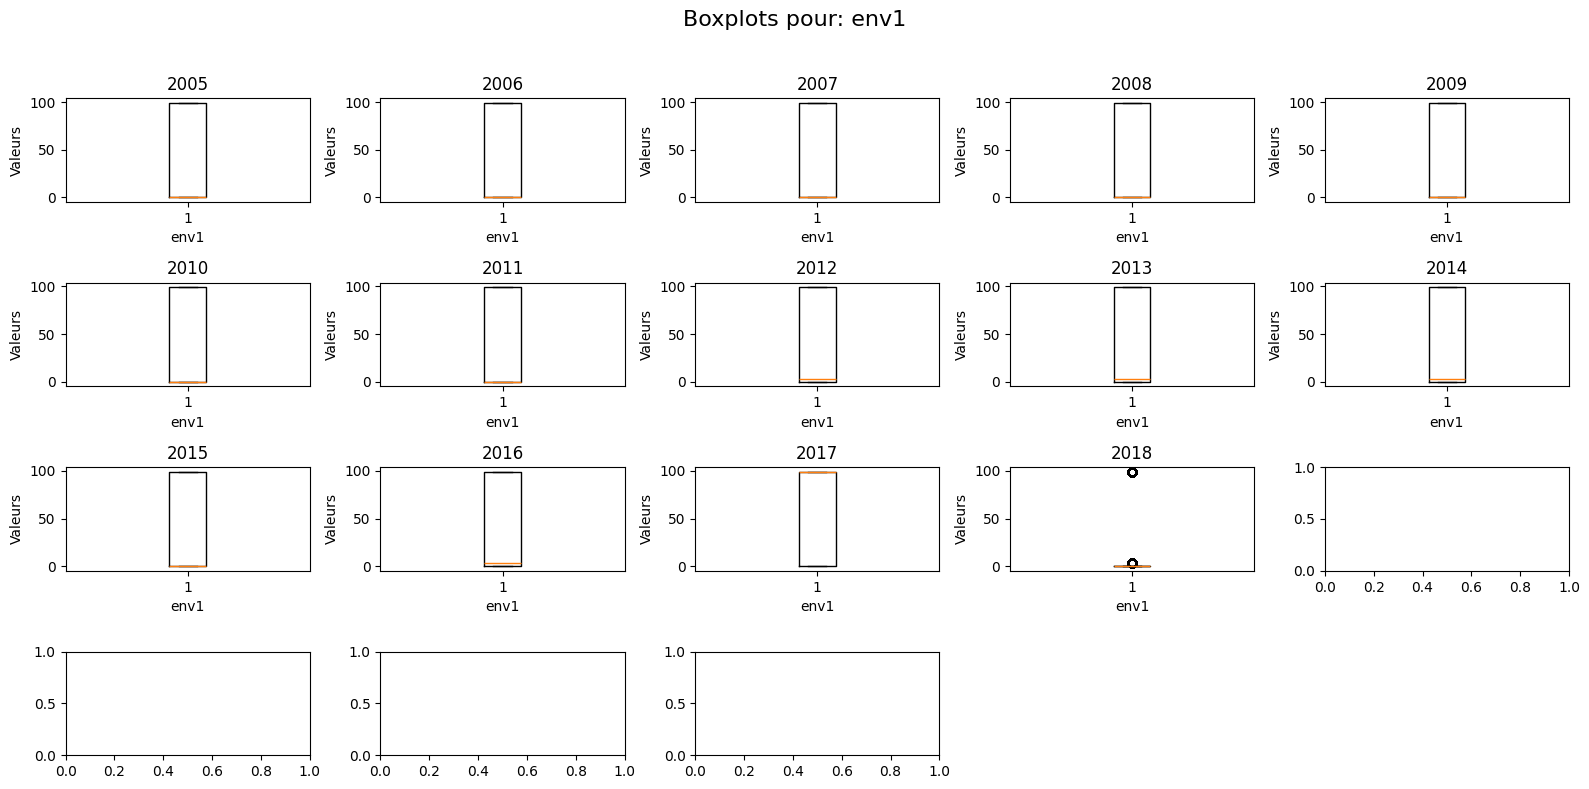

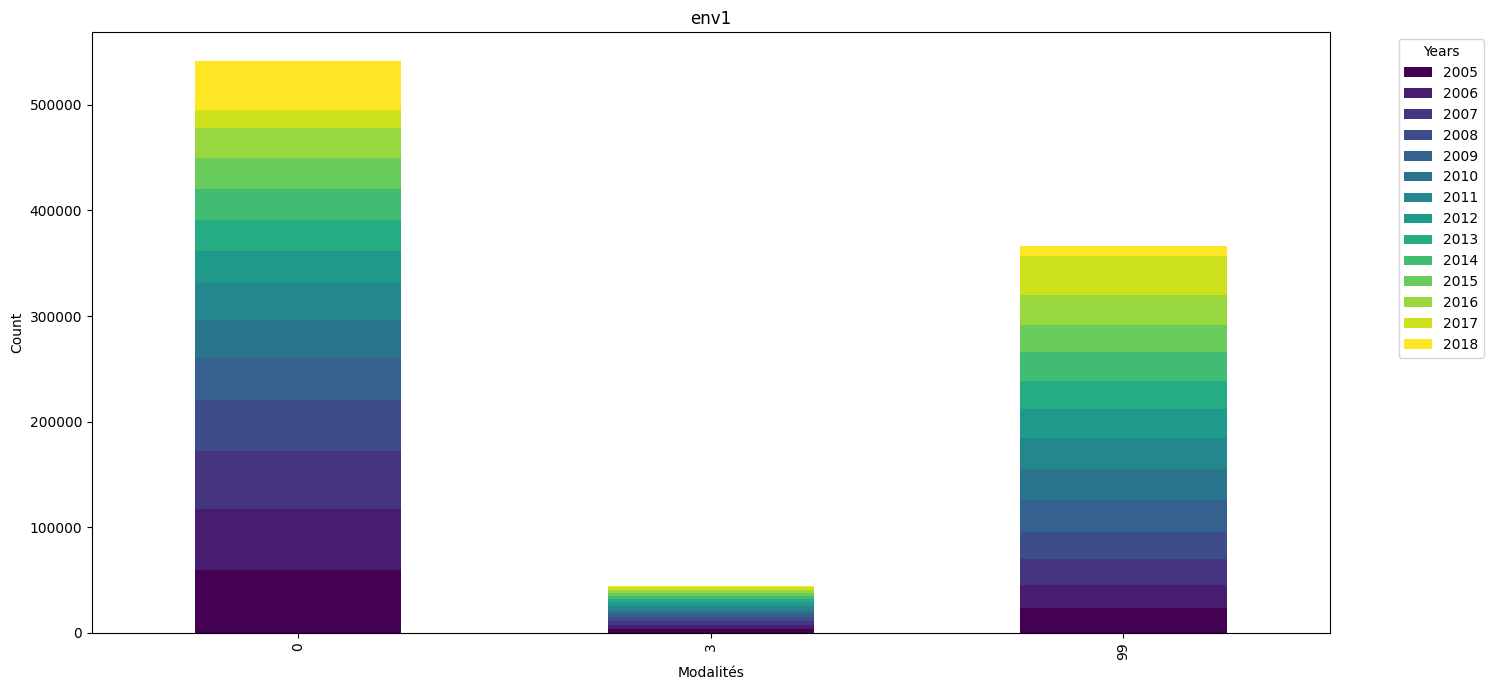

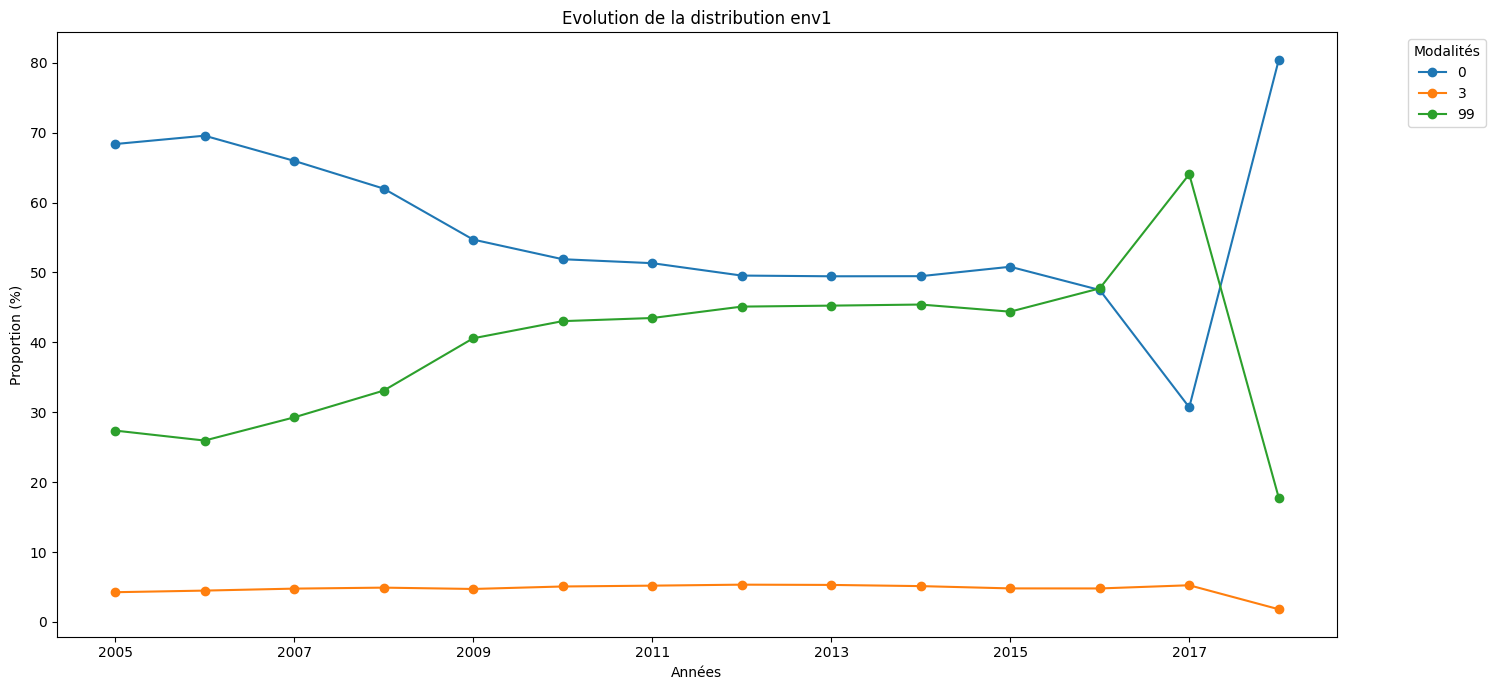

lignes: 1176873

Description: Profil en long décrit la déclivité de la route à l'endroit de l'accident :

Modalités:
- -1: Non renseigné
- 1: Plat
- 2: Pente
- 3: Sommet de côte
- 4: Bas de côte
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.10617                            6.7127e-05
   2010  float64       1                              0.0619784                          3.65375e-05
   2011  float64       1              

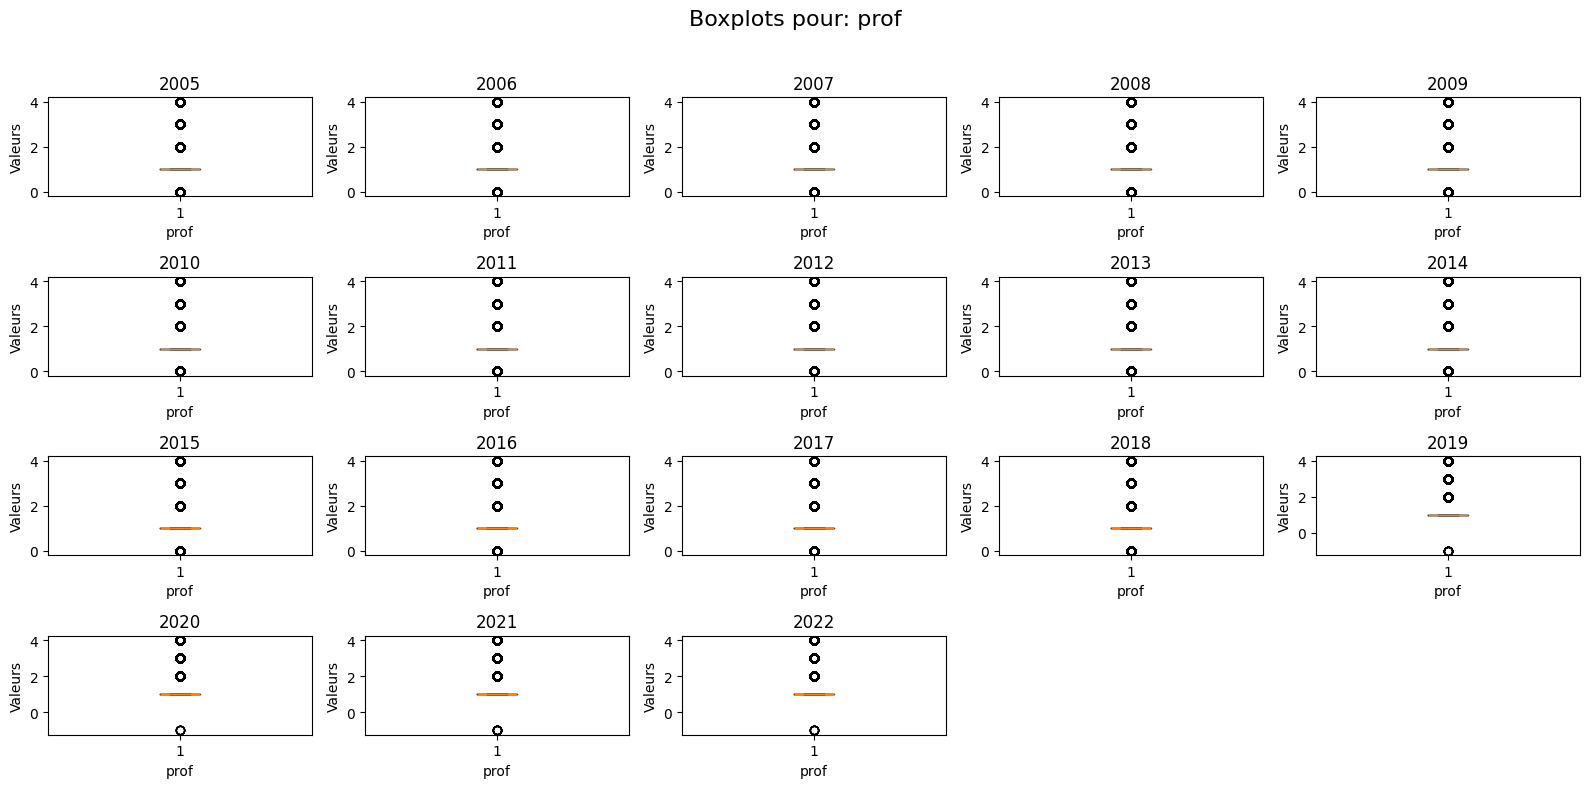

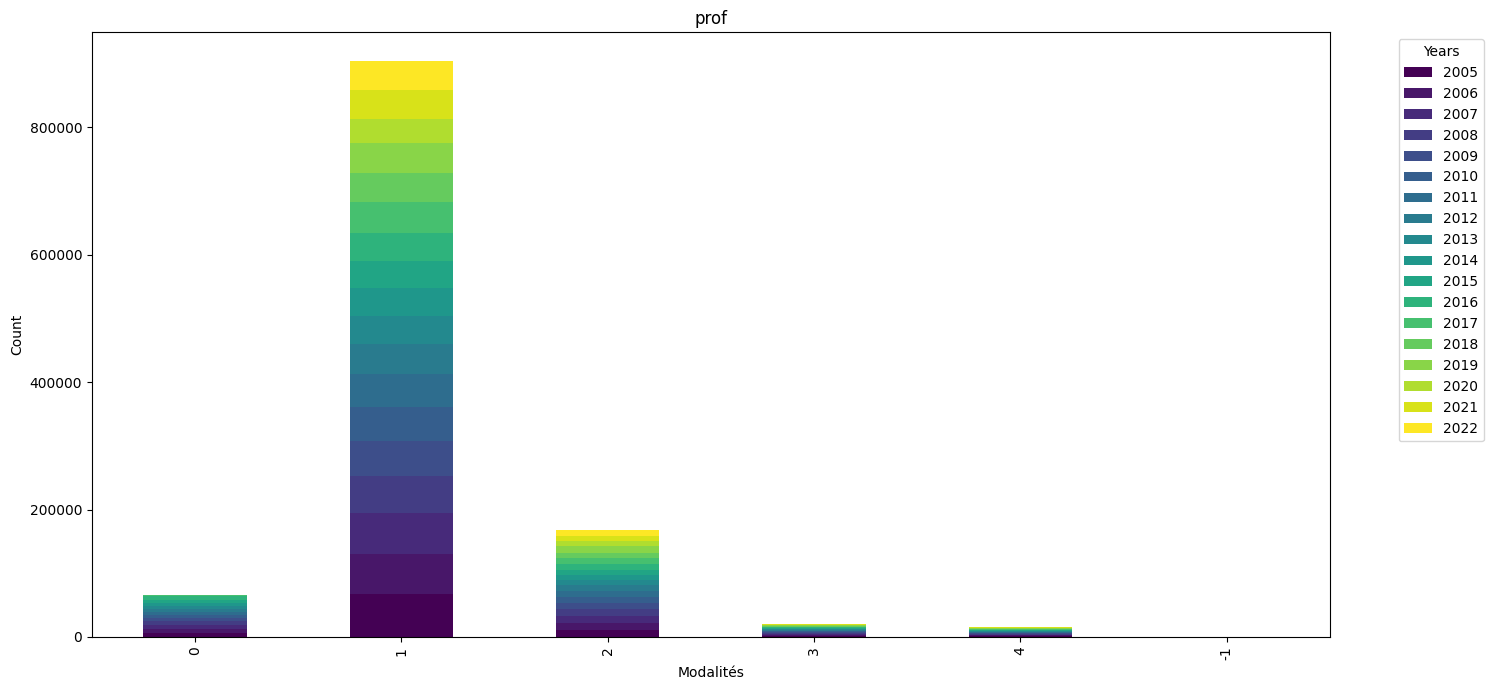

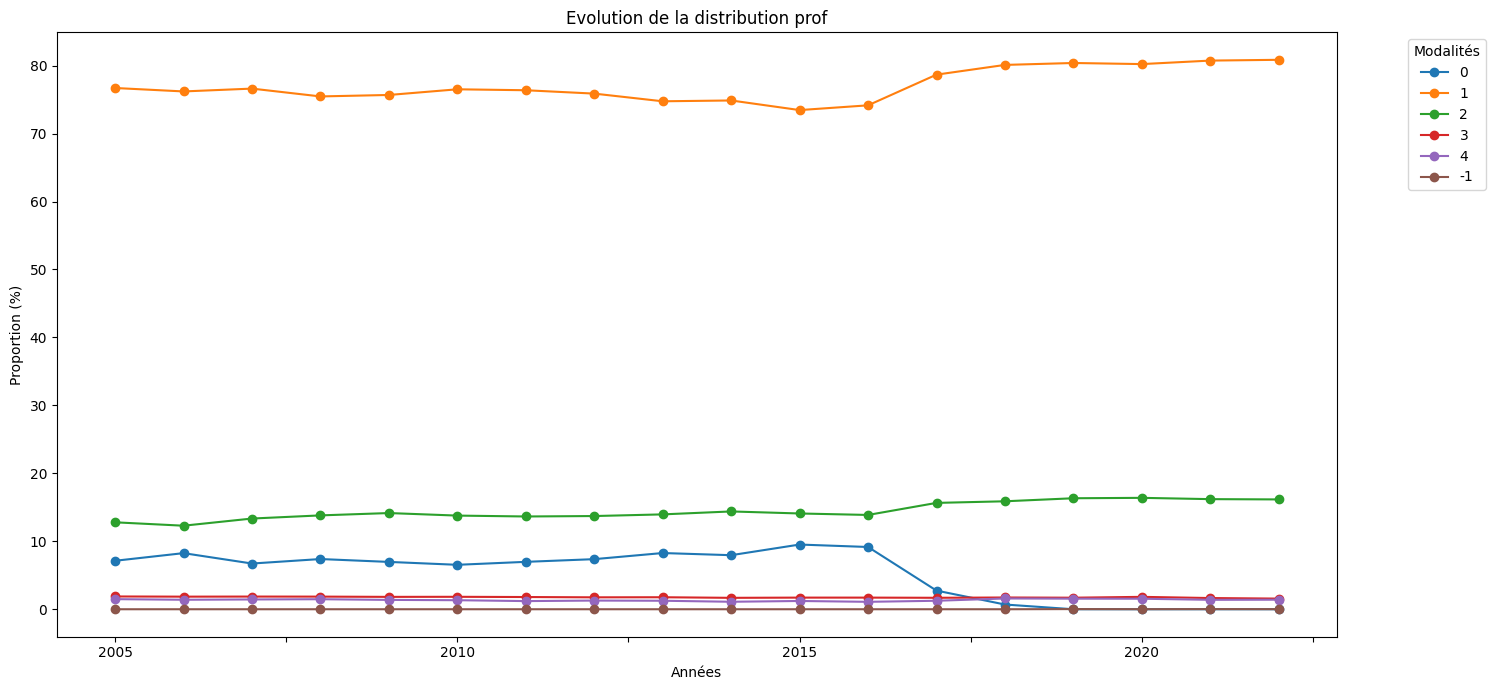

lignes: 1176873

Description: Régime de circulation :

Modalités:
- -1: Non renseigné
- 1: A sens unique
- 2: Bidirectionnelle
- 3: A chaussées séparées
- 4: Avec voies d’affectation variable
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                              0                                  0
   2006  int64         2                              0                                  0
   2007  int64         2                              0                                  0
   2008  int64         2                              0                                  0
   2009  float64       2                              0.0819793                          5.18323e-05
   2010  float64       2                              0.0634198                          3.73872e-05
   2011  float64       2                

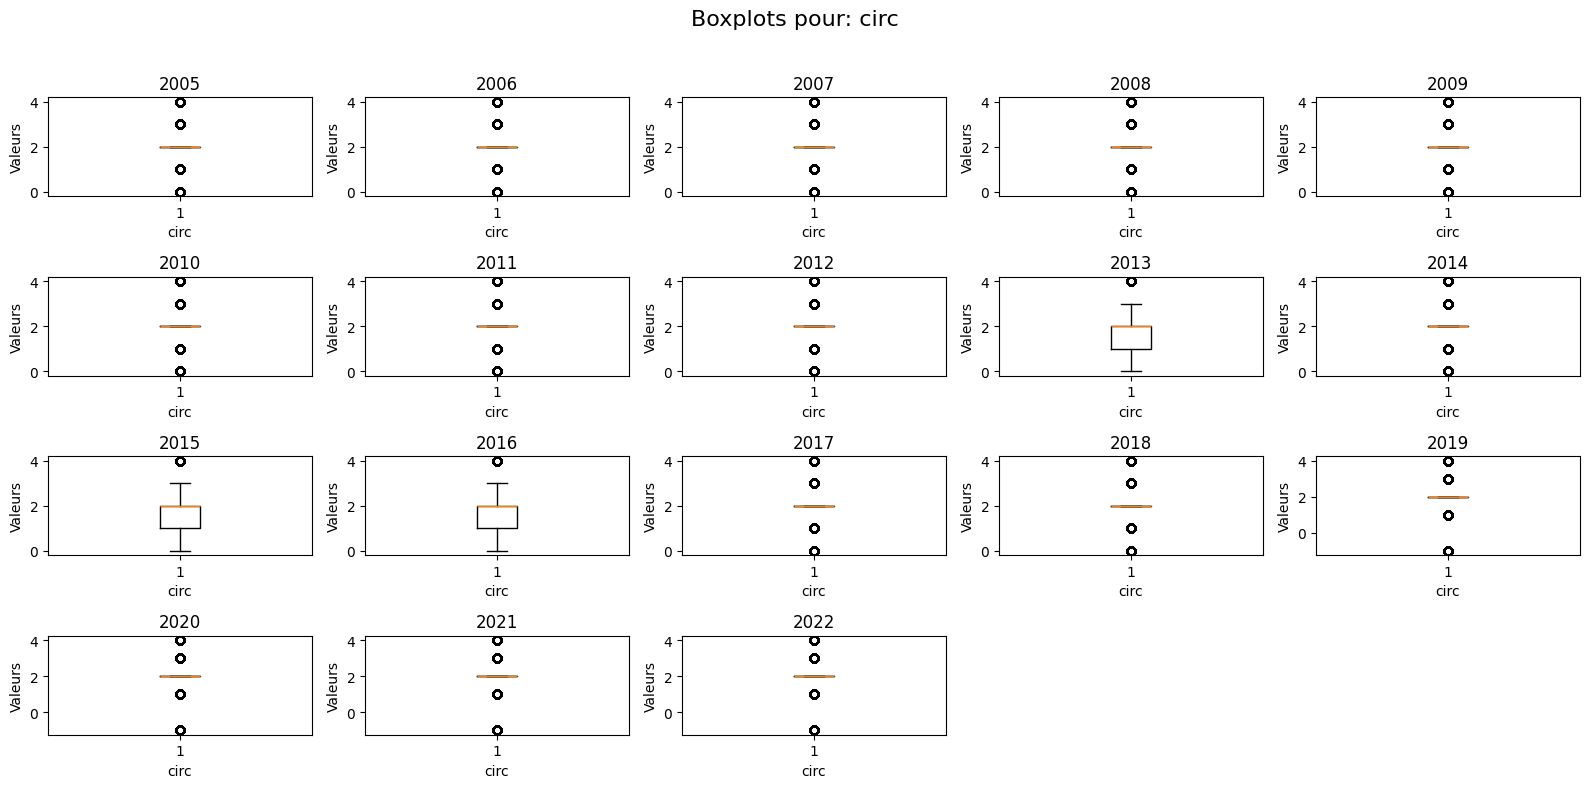

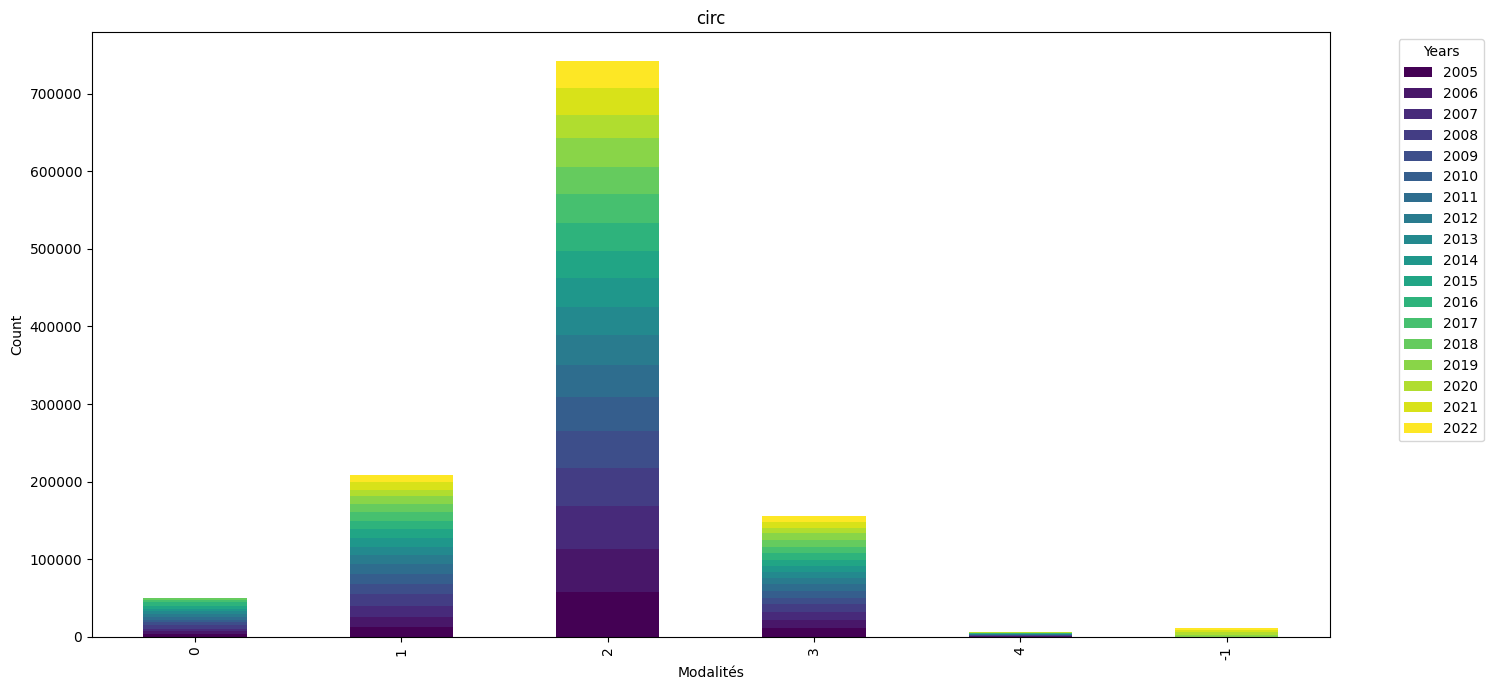

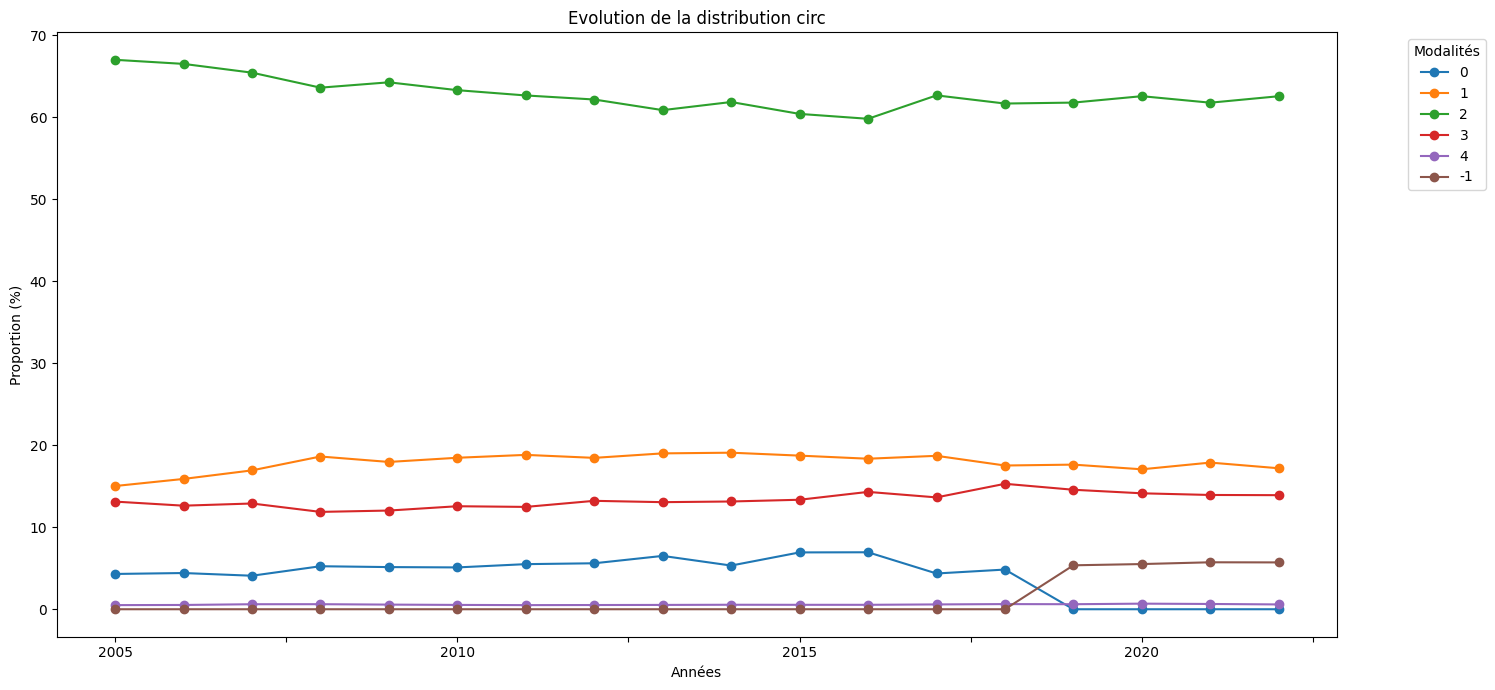

lignes: 1176873

Description: Vitesse maximale autorisée sur le lieu et au moment de l’accident.
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64       50                                      0                                    0
   2020  int64       50                                      0                                    0
   2021  int64       50                                      0                                    0
   2022  int64       50                                      0                                    0


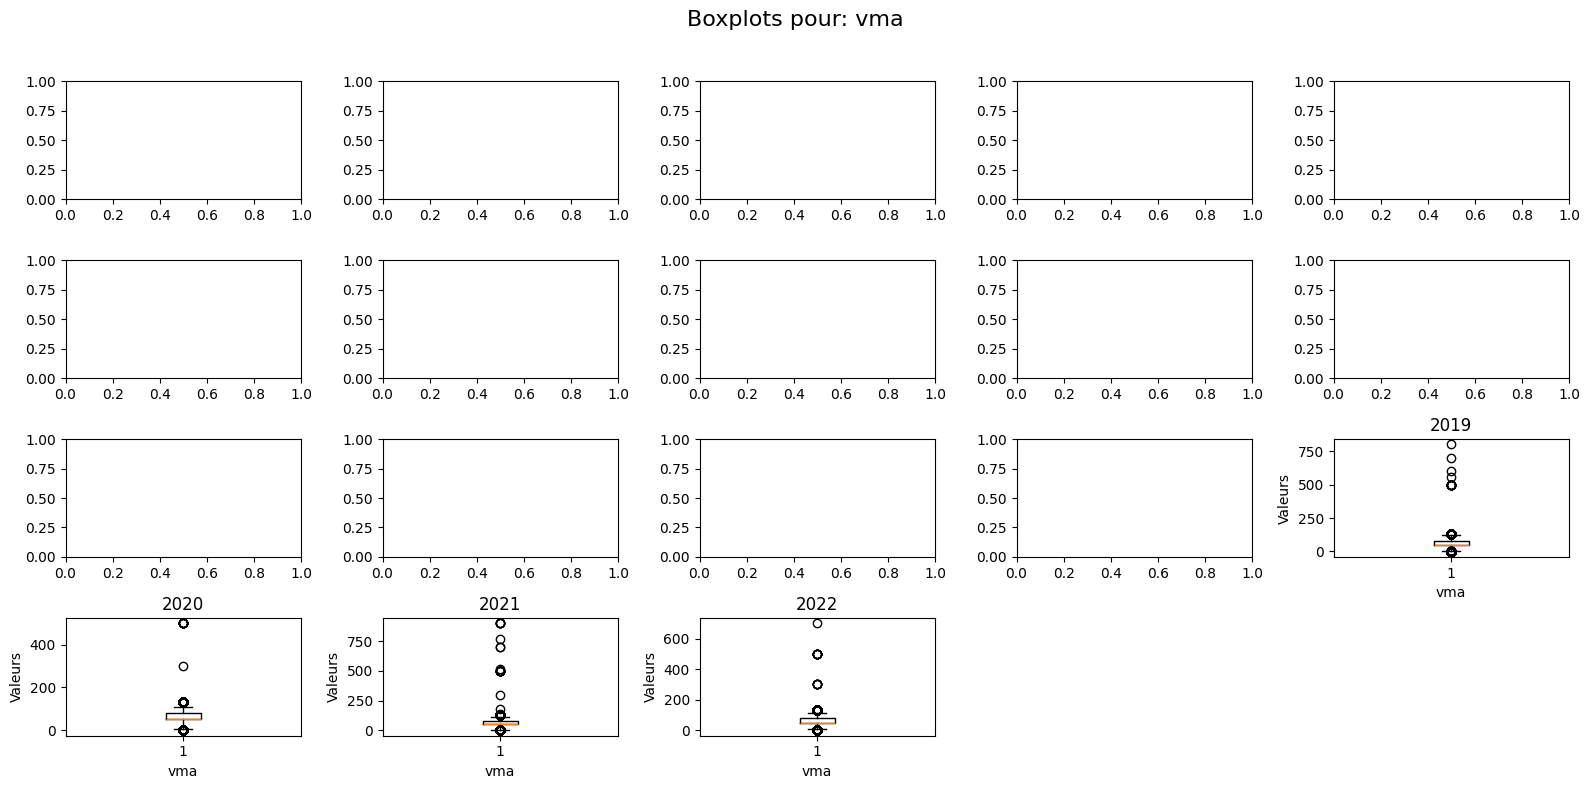

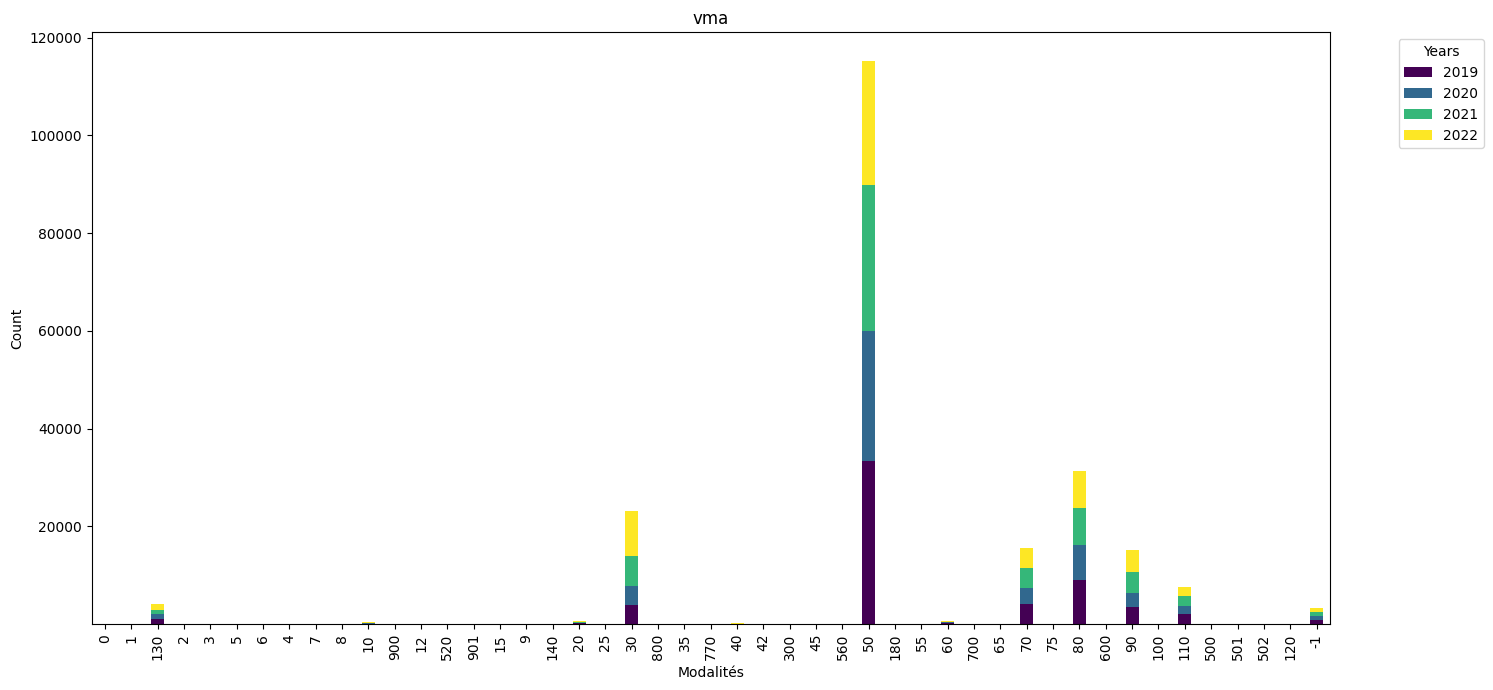

2024-11-25 11:20:50,146 - WARNING - Le nombre de modalités uniques dans la colonne vma excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Largeur du terre-plein central (TPC) s'il existe (en m).
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.725719                          0.000458843
   2010  float64       0                               0.671673                          0.000395965
   2011  float64       0                               1.03324                           0.000587999
   2012  float64       0                    

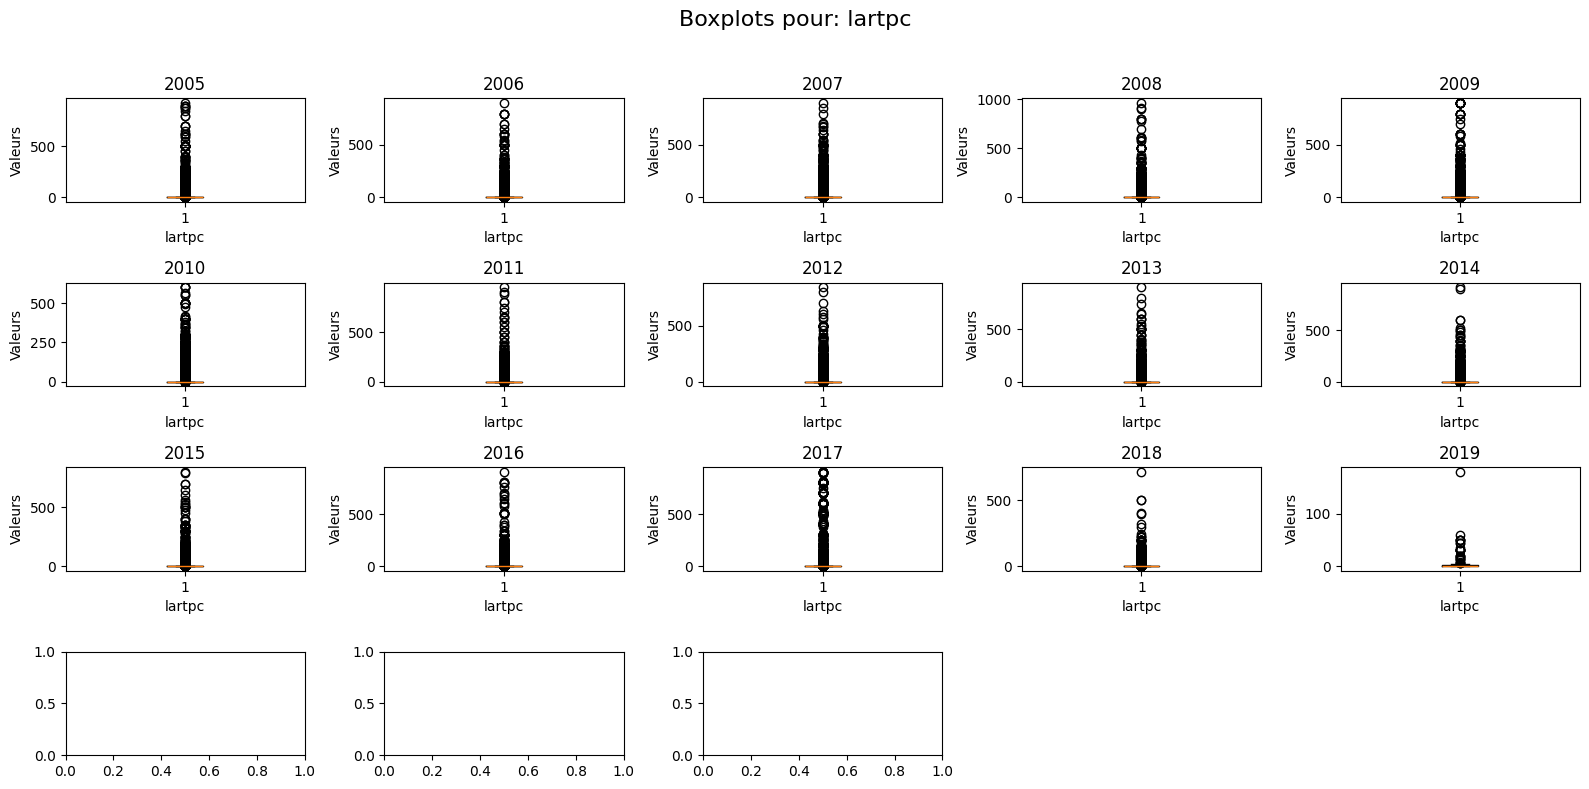

2024-11-25 11:20:51,982 - WARNING - Le nombre de modalités uniques dans la colonne lartpc excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:52,010 - WARNING - Le nombre de modalités uniques dans la colonne lartpc excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Distance en mètres au PR (par rapport à la borne amont). La valeur -1 signifie que le PR n’est pas renseigné.
  Année  Type     Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                   45.4014                            0.0335729
   2006  float64  0.0                                   46.6678                            0.0329101
   2007  float64  0.0                                   53.5015                            0.0381188
   2008  float64  0.0                                   58.8026                            0.0383567
   2009  float64  0.0                                   37.8892                            0.0239559
   2010  float64  0.0                                   40.6809                            0.0239822
   2011  float64  0.0                               

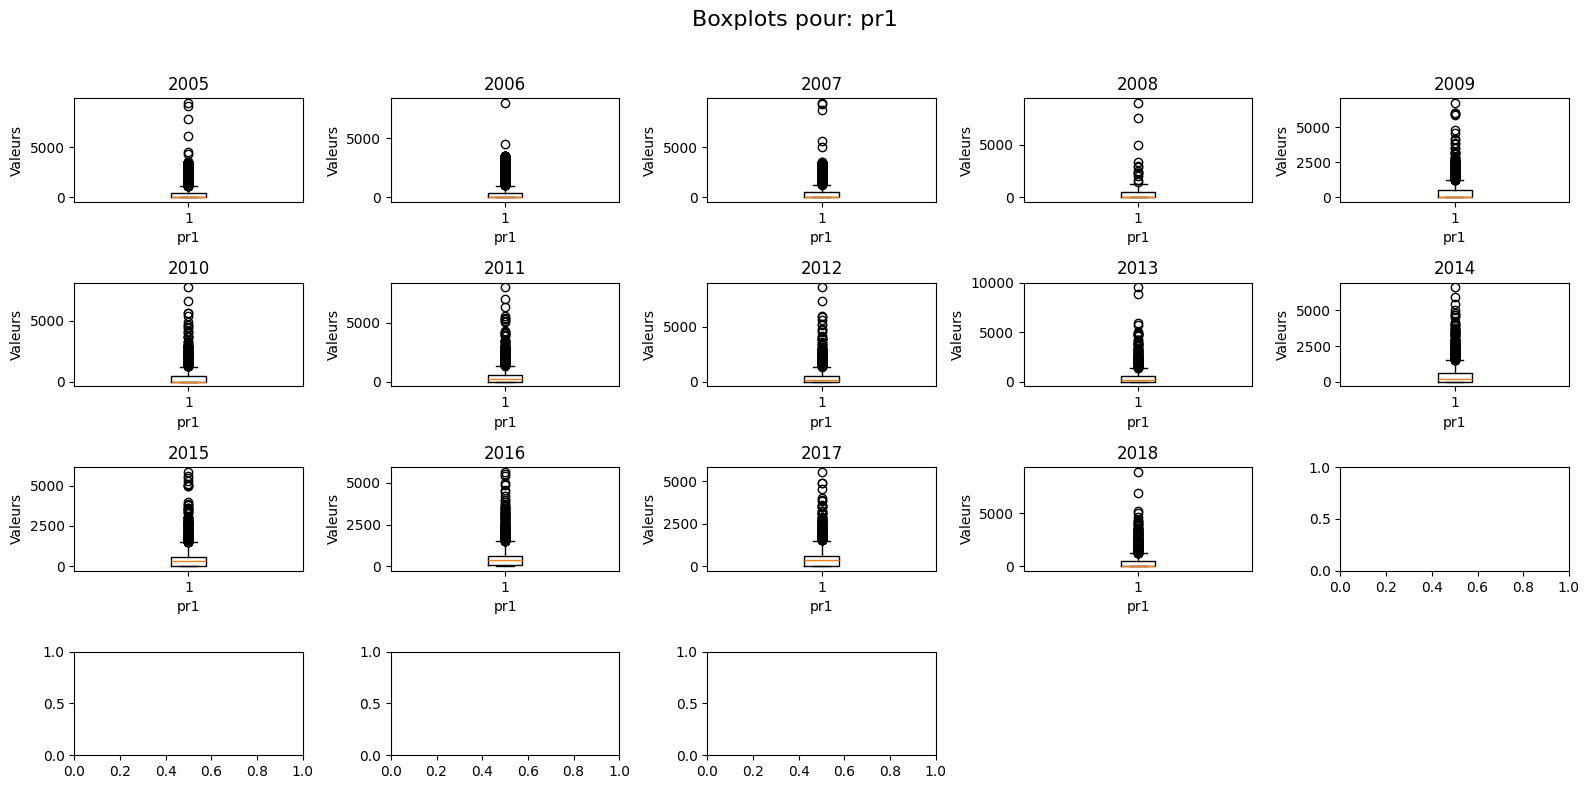

2024-11-25 11:20:53,782 - WARNING - Le nombre de modalités uniques dans la colonne pr1 excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:53,832 - WARNING - Le nombre de modalités uniques dans la colonne pr1 excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Catégorie de route :

Modalités:
- 1: Autoroute
- 2: Route nationale
- 3: Route Départementale
- 4: Voie Communales
- 5: Hors réseau public
- 6: Parc de stationnement ouvert à la circulation publique
- 7: Routes de métropole urbaine
- 9: Autre
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       4                             0.00114908                          8.49709e-07
   2006  int64         4                             0                                   0
   2007  int64         4                             0                                   0
   2008  int64         4                             0                                   0
   2009  int64         4                             0                                   0
   2010  int64         4                             0     

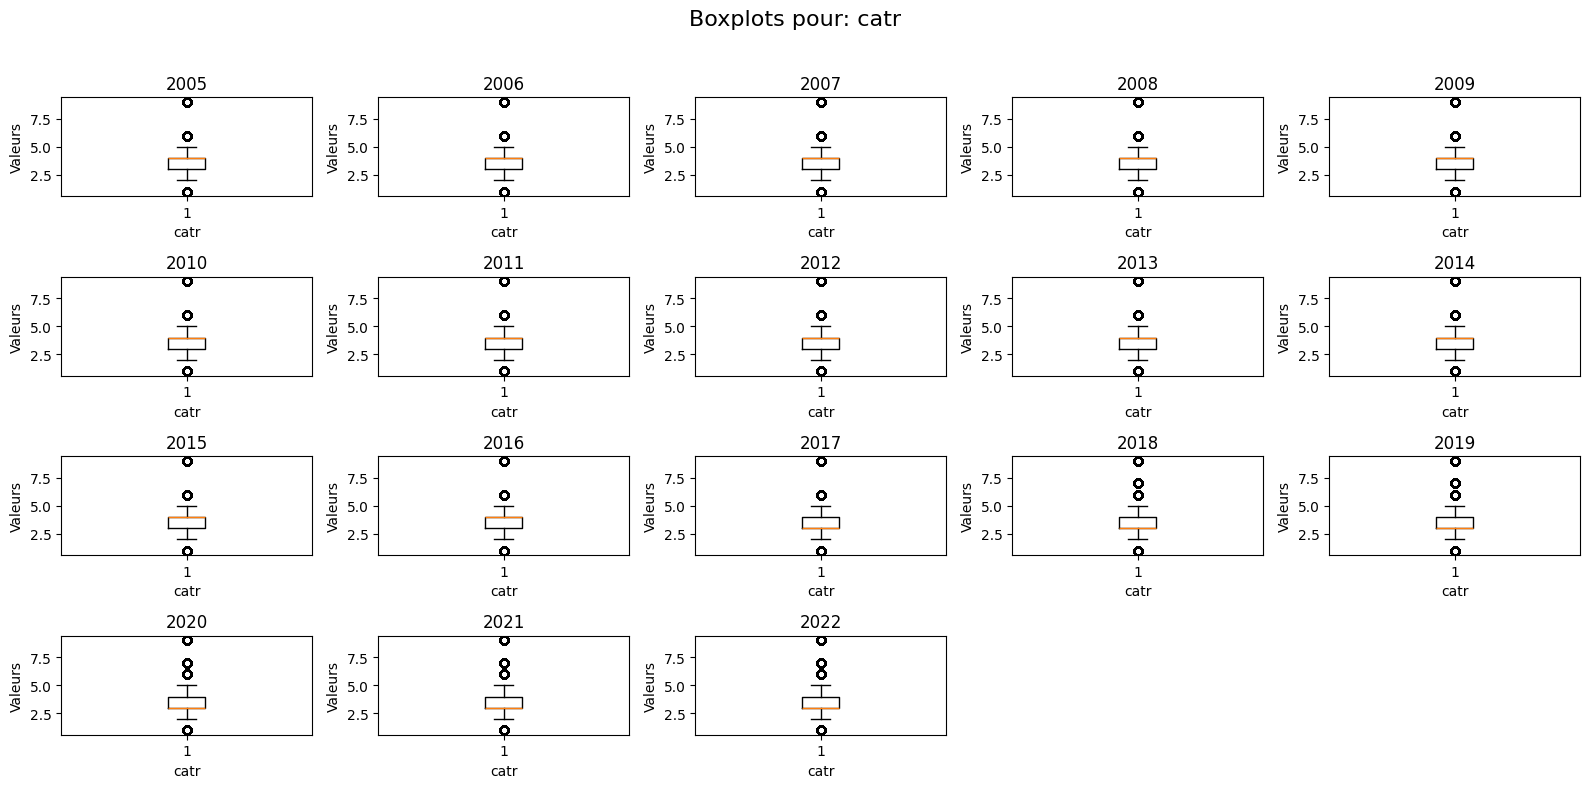

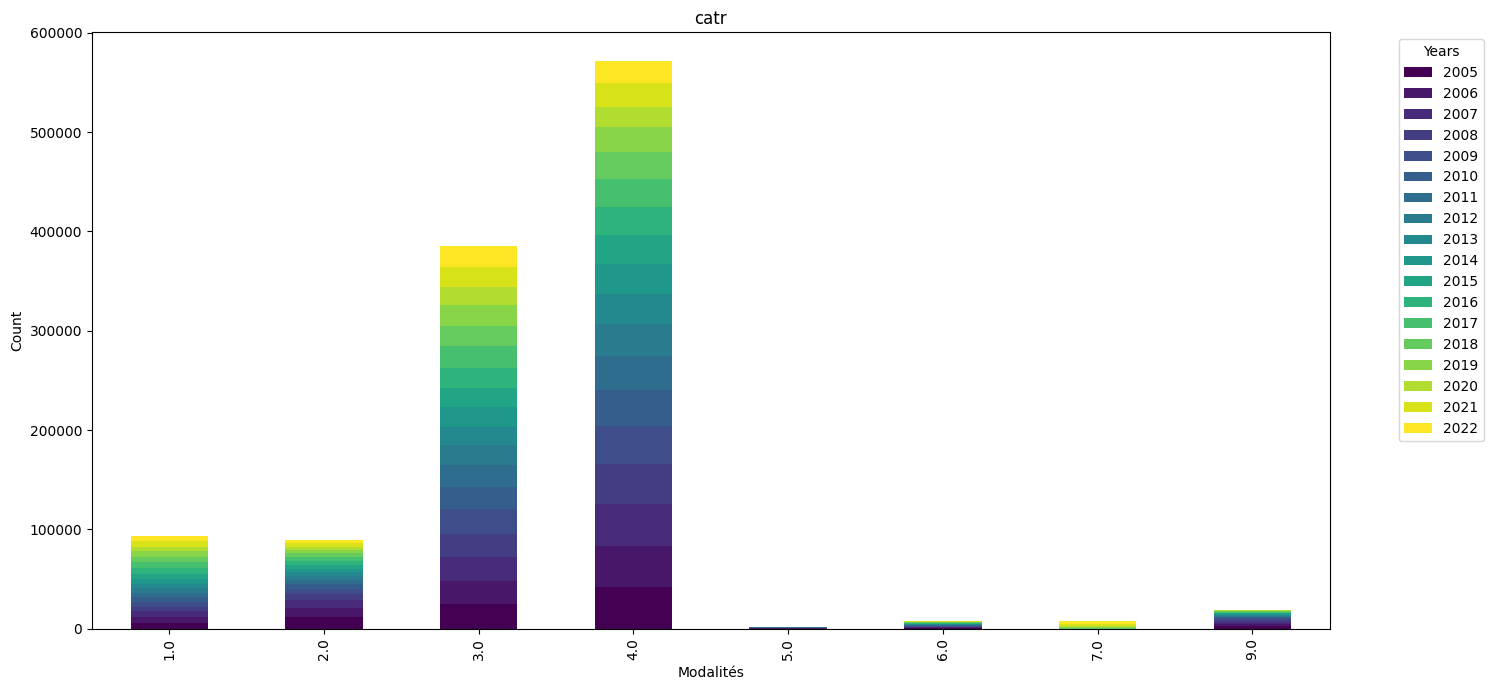

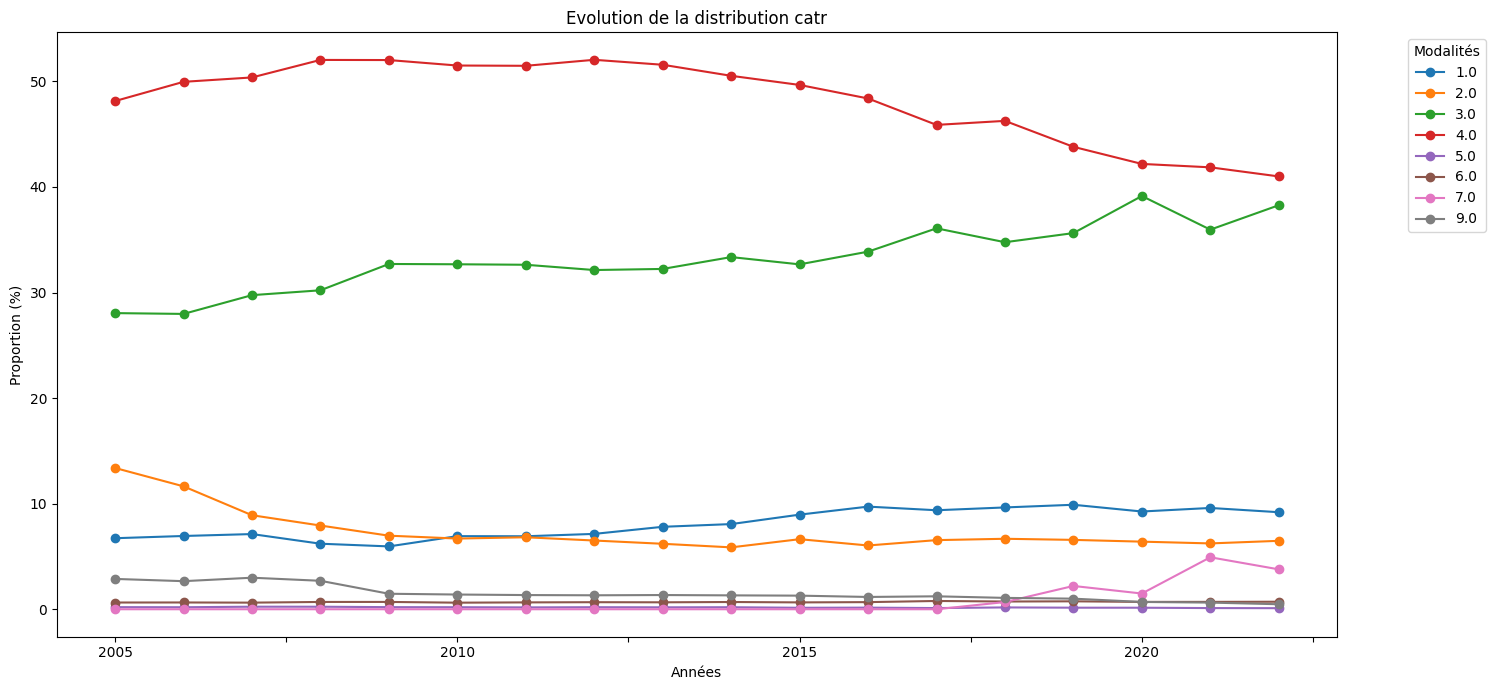

lignes: 1176873

Description: Largeur de la chaussée affectée à la circulation des véhicules ne sont pas compris les bandes d'arrêt d'urgence, les TPC et les places de stationnement (en m).
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.482469                          0.000305046
   2010  float64       0                               0.531861                          0.000313543
   2011  float64       0                  

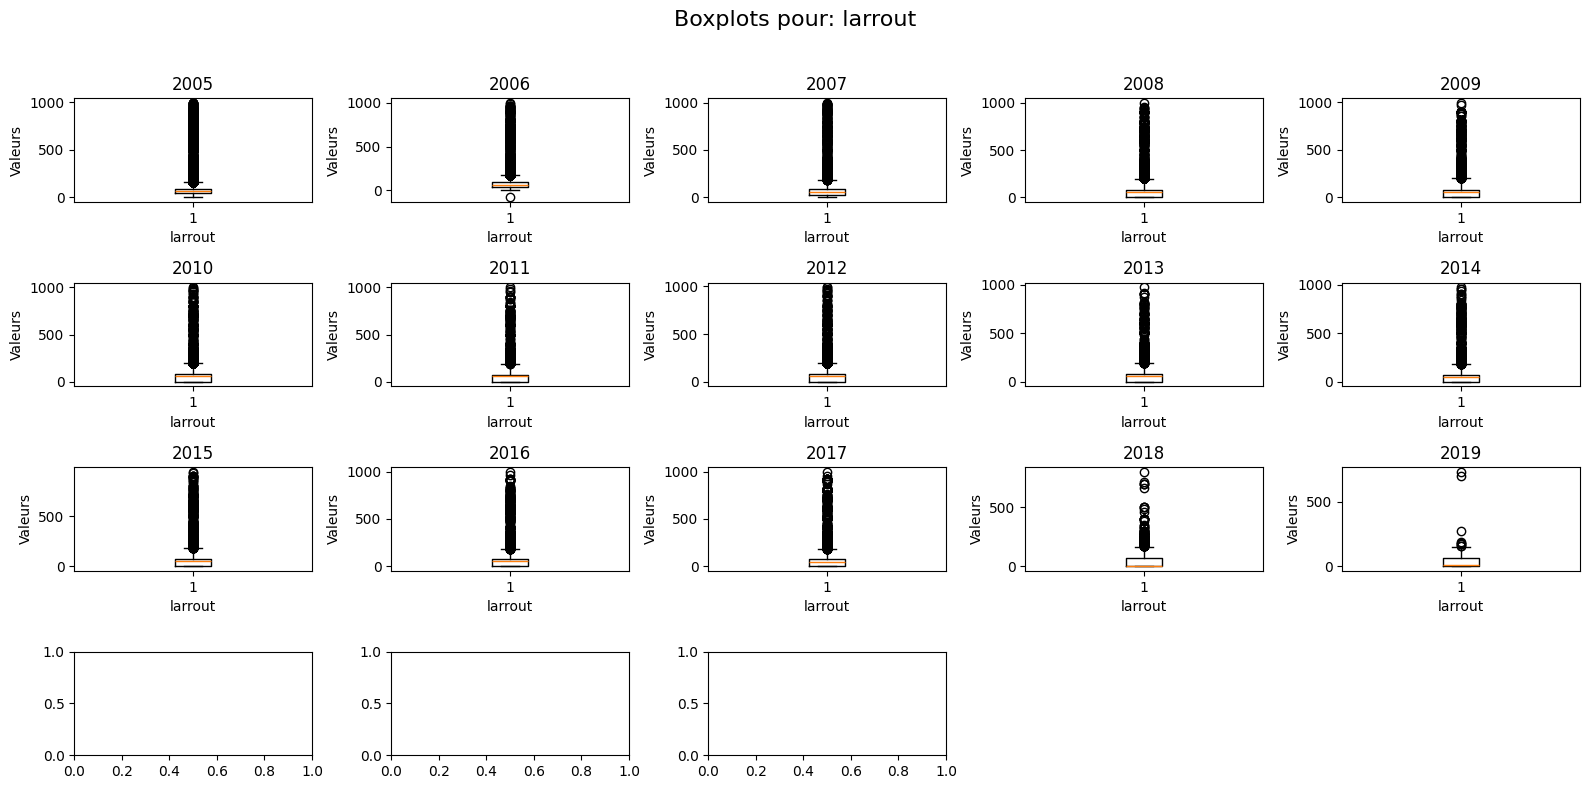

2024-11-25 11:20:58,175 - WARNING - Le nombre de modalités uniques dans la colonne larrout excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:20:58,199 - WARNING - Le nombre de modalités uniques dans la colonne larrout excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Etat de la surface :

Modalités:
- -1: Non renseigné
- 1: Normale
- 2: Mouillée
- 3: Flaques
- 4: Inondée
- 5: Enneigée
- 6: Boue
- 7: Verglacée
- 8: Corps gras – huile
- 9: Autre
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0913868                          5.77802e-05
   2010  float64       1                              0.0605371                          3.56878e-05
   2011  float64      

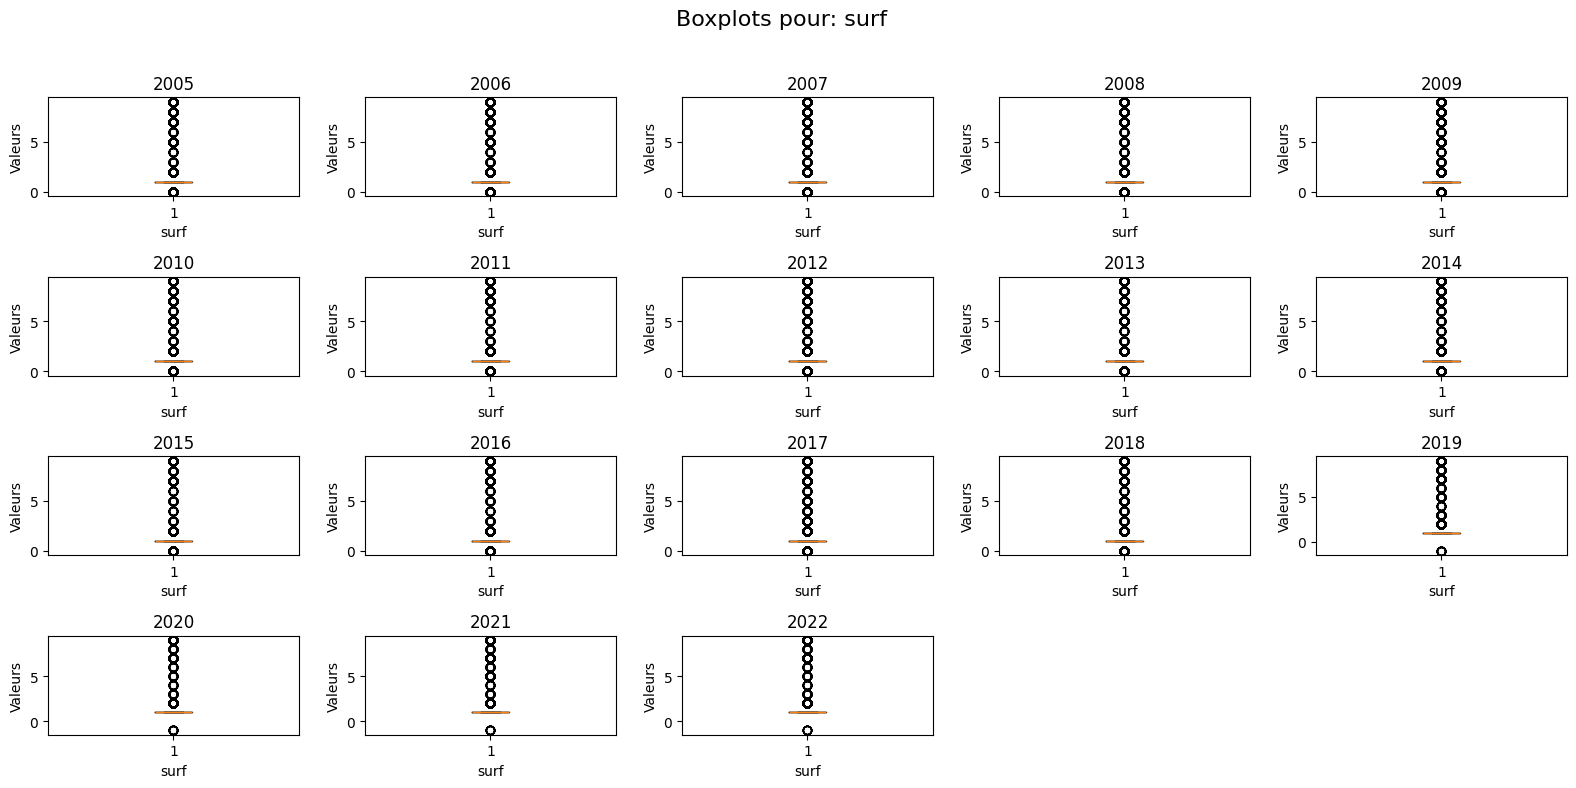

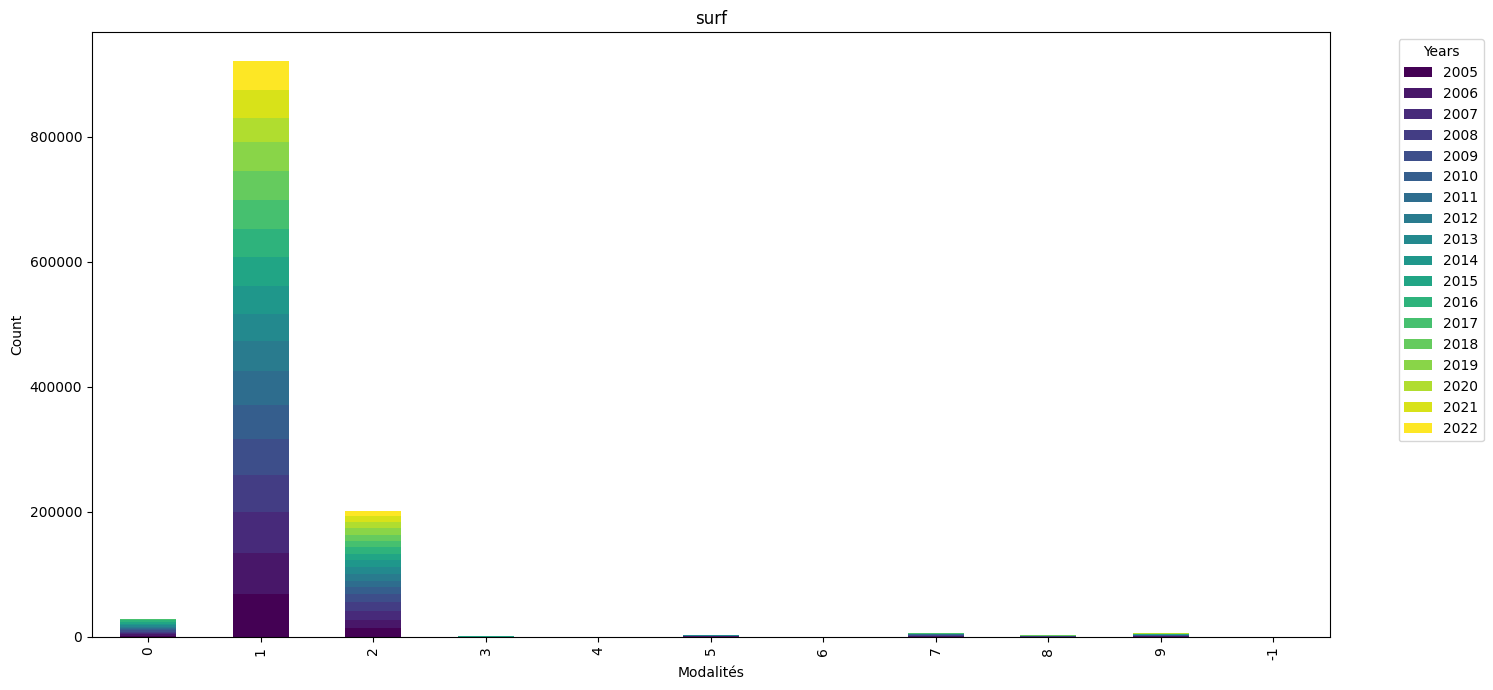

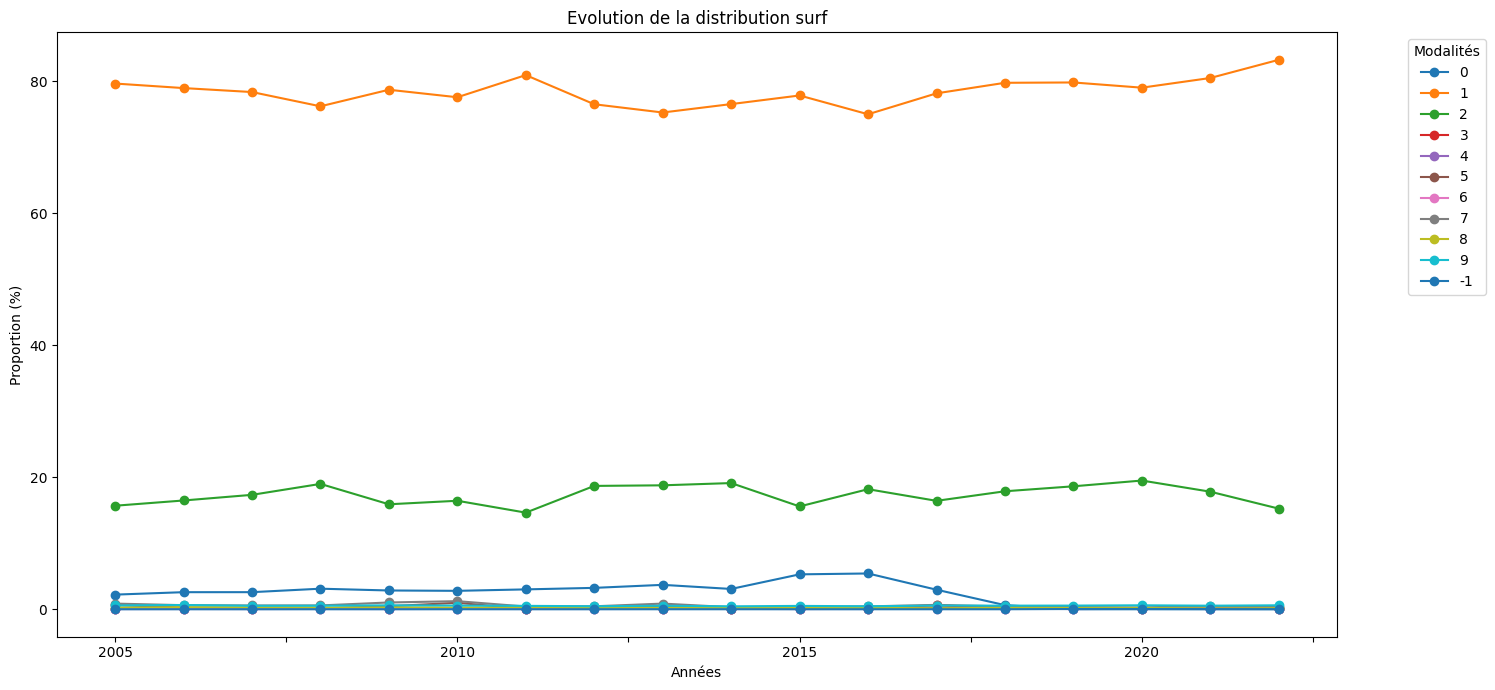

2024-11-25 11:21:01,002 - INFO - Pas de description pour `v1` dans la section `LIEUX`.


lignes: 1176873

  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       0                             0.235562                            0.00017419
   2006  float64       0                             0.0385575                           2.71907e-05
   2007  float64       0                             0.00715564                          5.09826e-06
   2008  float64       0                             0.0130264                           8.49709e-06
   2009  float64       2                            99.5511                              0.0629422
   2010  float64       2                            99.6353                              0.058737
   2011  float64       2                            99.6297                              0.0566977
   2012  float64       2                            99.5984                       

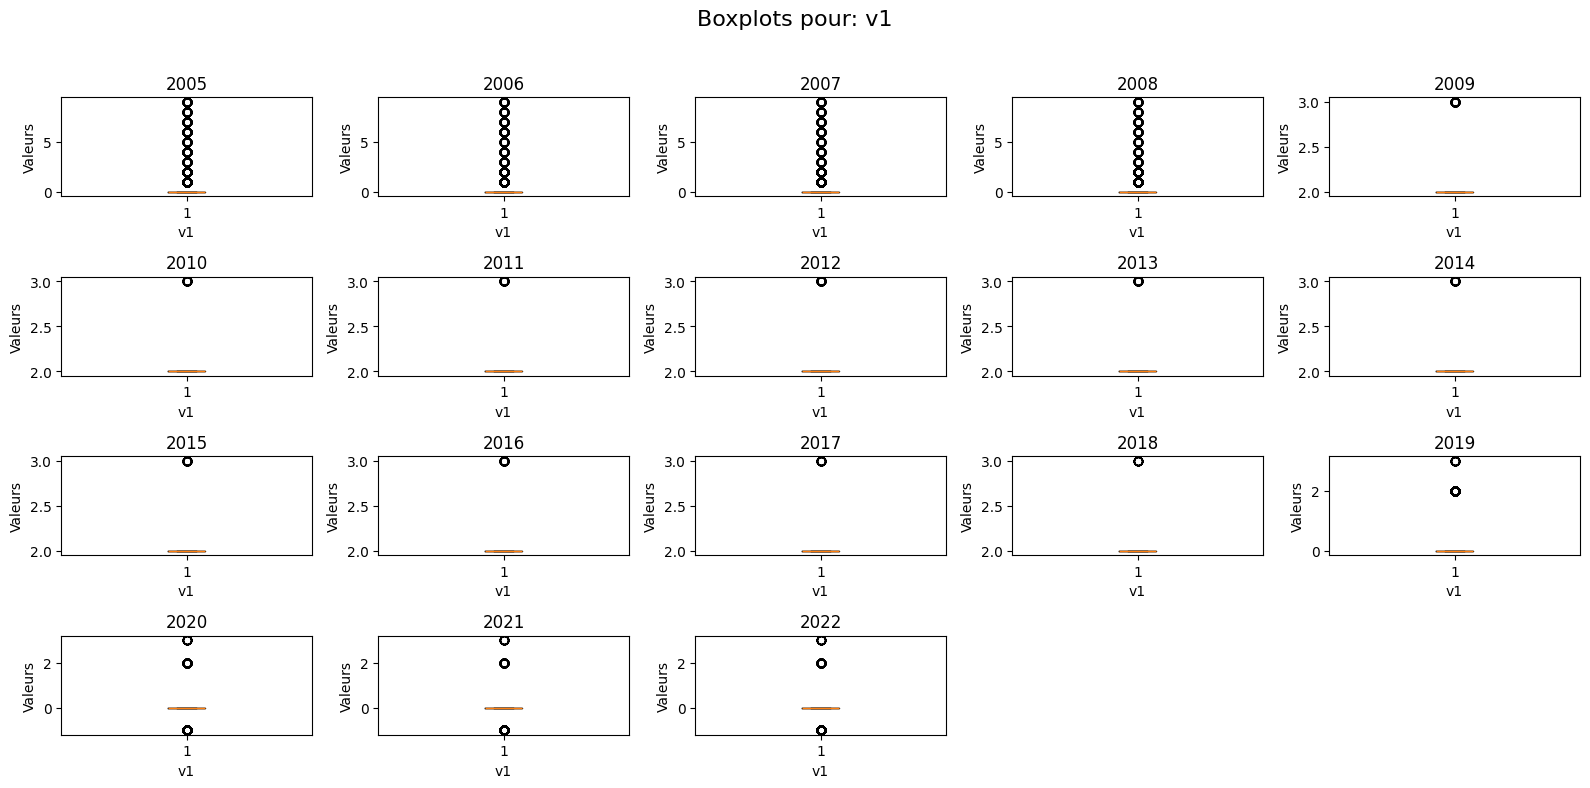

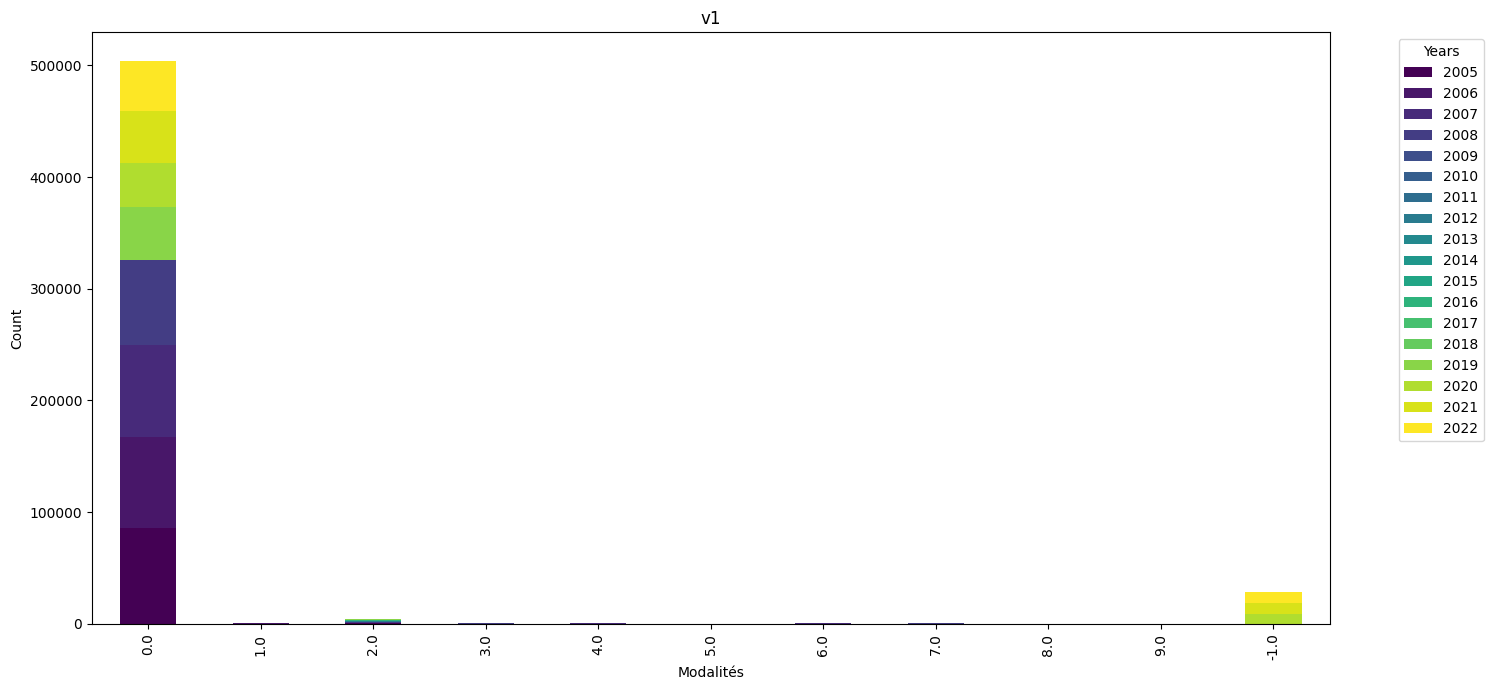

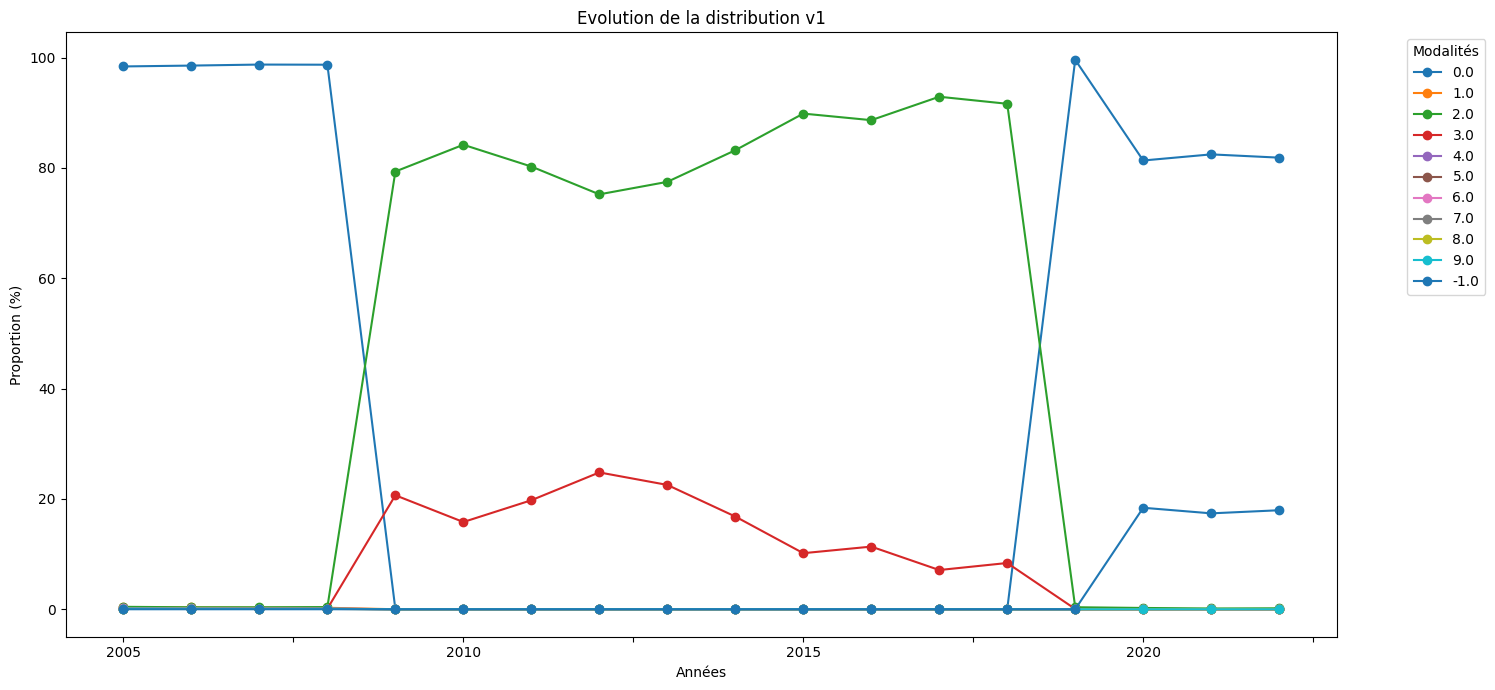

lignes: 1176873

Description: Numéro de la route.
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       0                             8.65144                             0.00639746
   2006  float64       0                             9.57671                             0.00675349
   2007  float64       0                             3.99165                             0.00284398
   2008  float64       0                             0.00651322                          4.24855e-06
   2009  float64       0                             1.98632                             0.00125587
   2010  float64       0                             2.23266                             0.0013162
   2011  float64       0                             7.15352                             0.00407096
   2012  float64       0                        

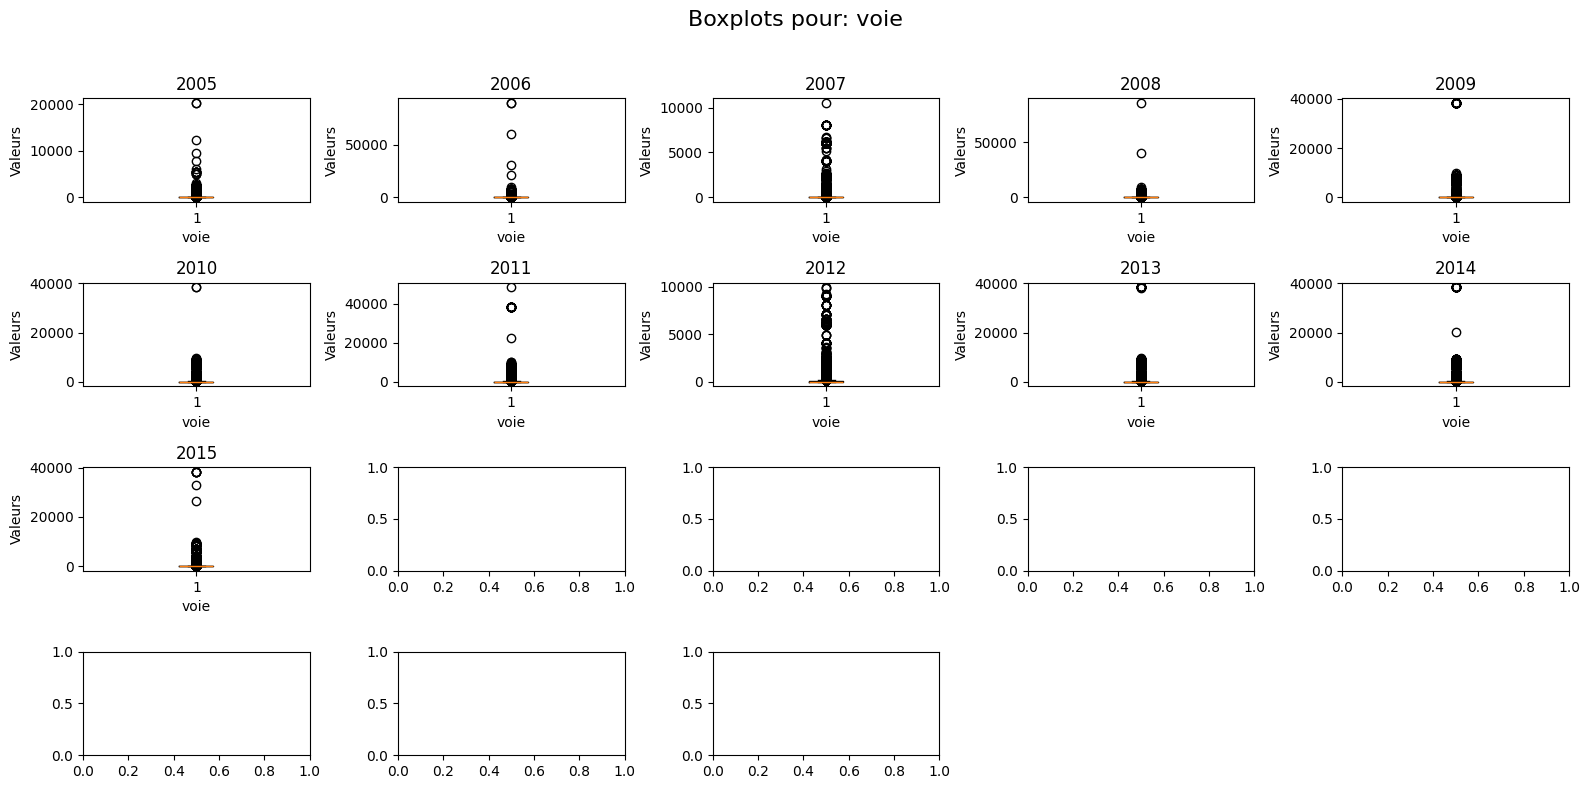

2024-11-25 11:21:05,560 - WARNING - Le nombre de modalités uniques dans la colonne voie excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:21:05,665 - WARNING - Le nombre de modalités uniques dans la colonne voie excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Signale l’existence d’une voie réservée, indépendamment du fait que l’accident ait lieu ou non sur cette voie.

Modalités:
- -1: Non renseigné
- 0: Sans objet
- 1: Piste cyclable
- 2: Bande cyclable
- 3: Voie réservée
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.346732                          0.000219225
   2010  float64       0                               0.159991                      

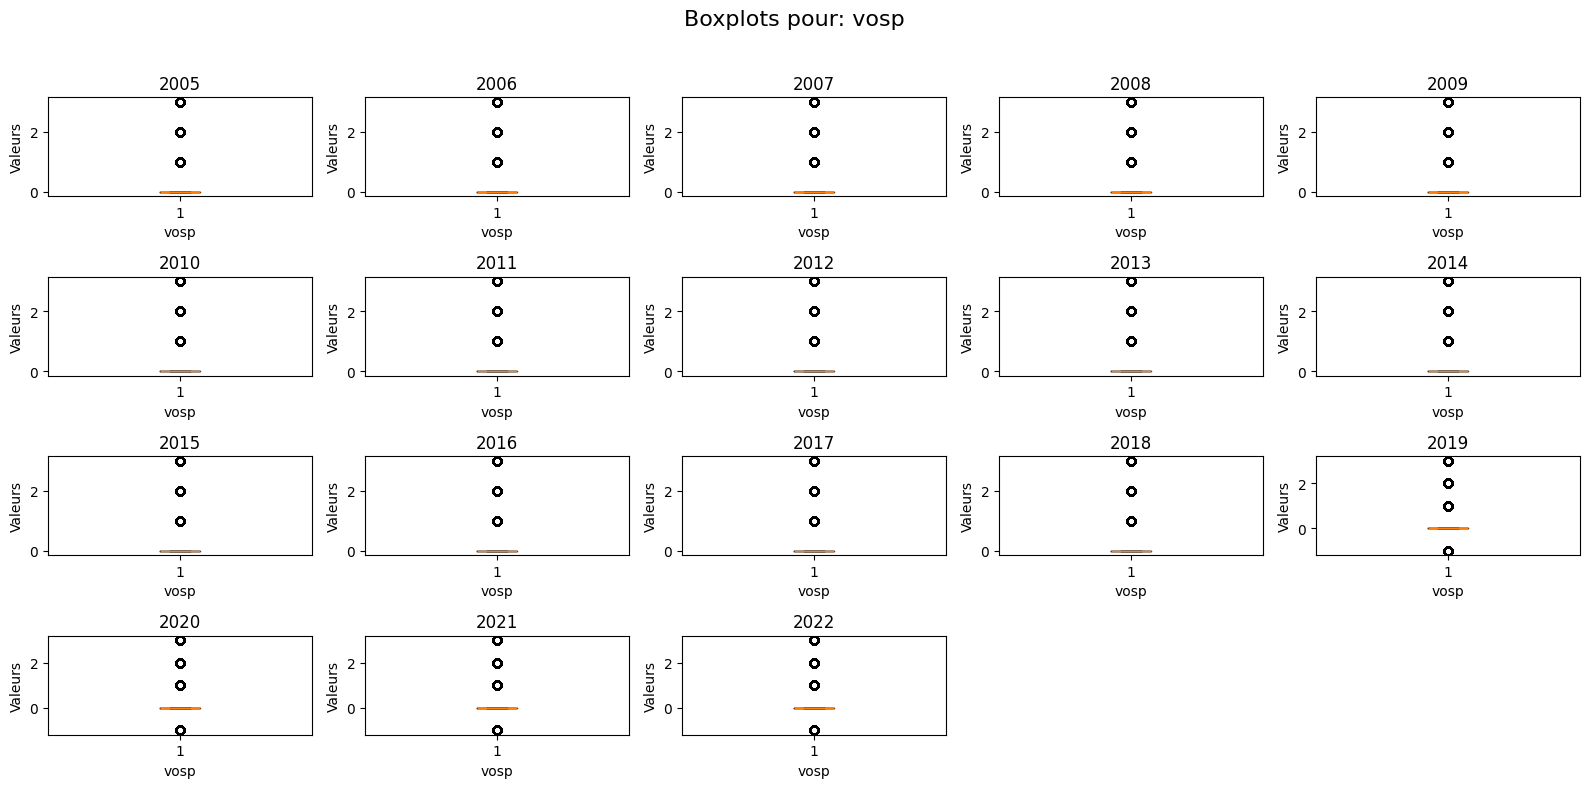

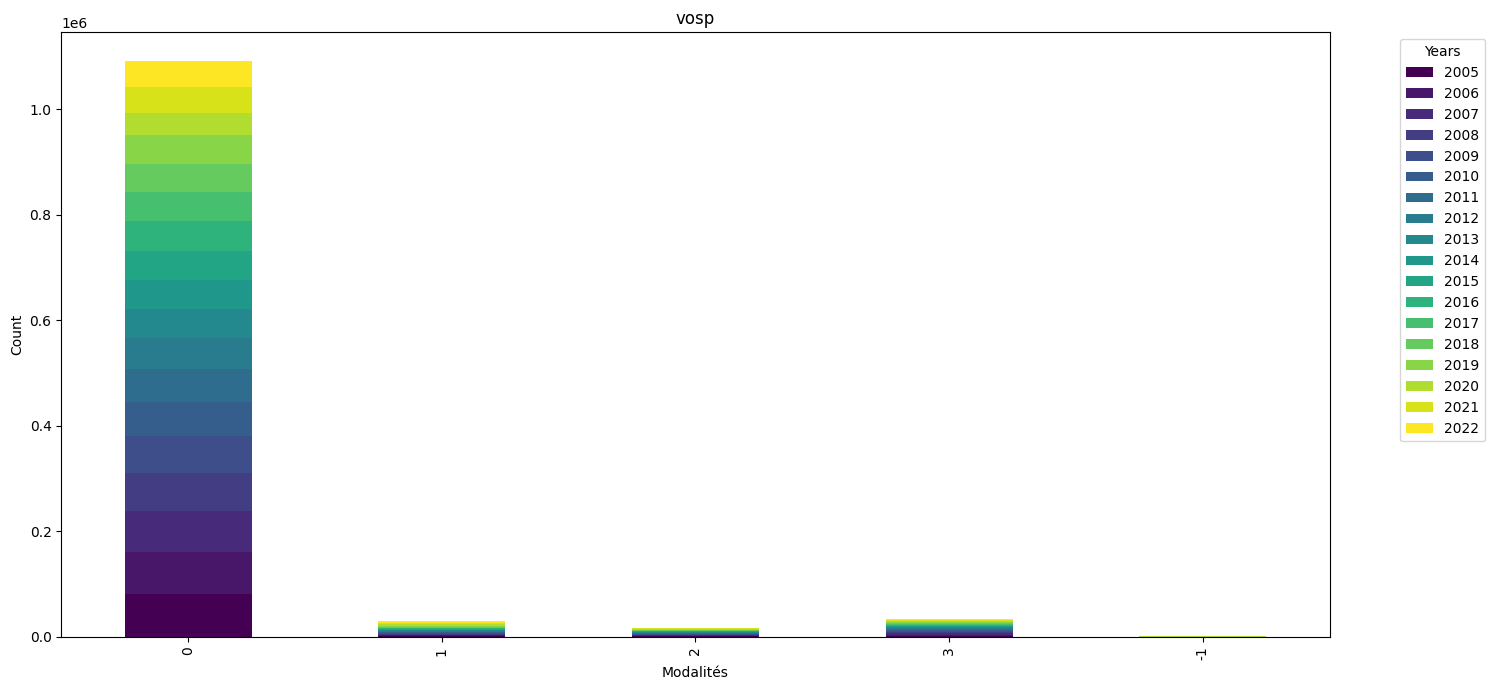

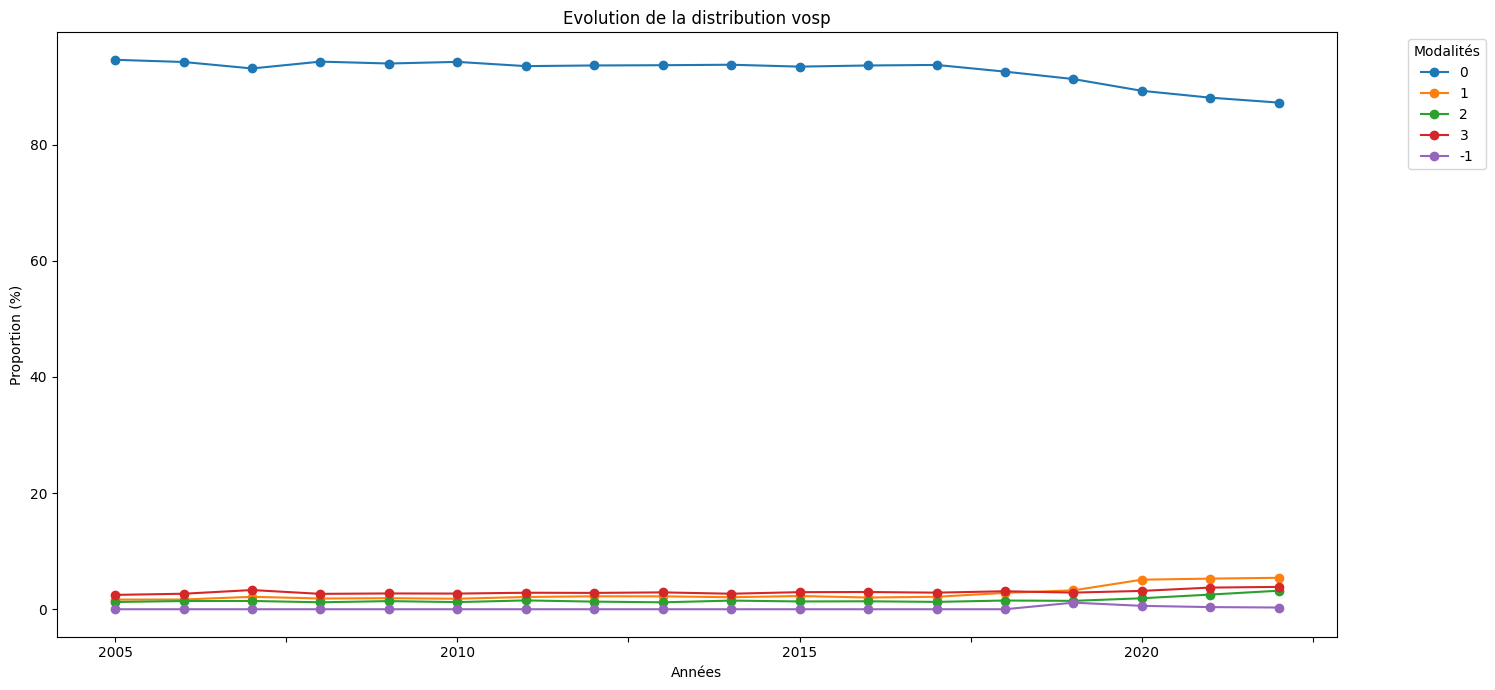

lignes: 1176873

Description: Aménagement - Infrastructure :

Modalités:
- -1: Non renseigné
- 0: Aucun
- 1: Souterrain - tunnel
- 2: Pont - autopont
- 3: Bretelle d’échangeur ou de raccordement
- 4: Voie ferrée
- 5: Carrefour aménagé
- 6: Zone piétonne
- 7: Zone de péage
- 8: Chantier
- 9: Autres
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.225779                           0.000142751
   2010  float64       0          

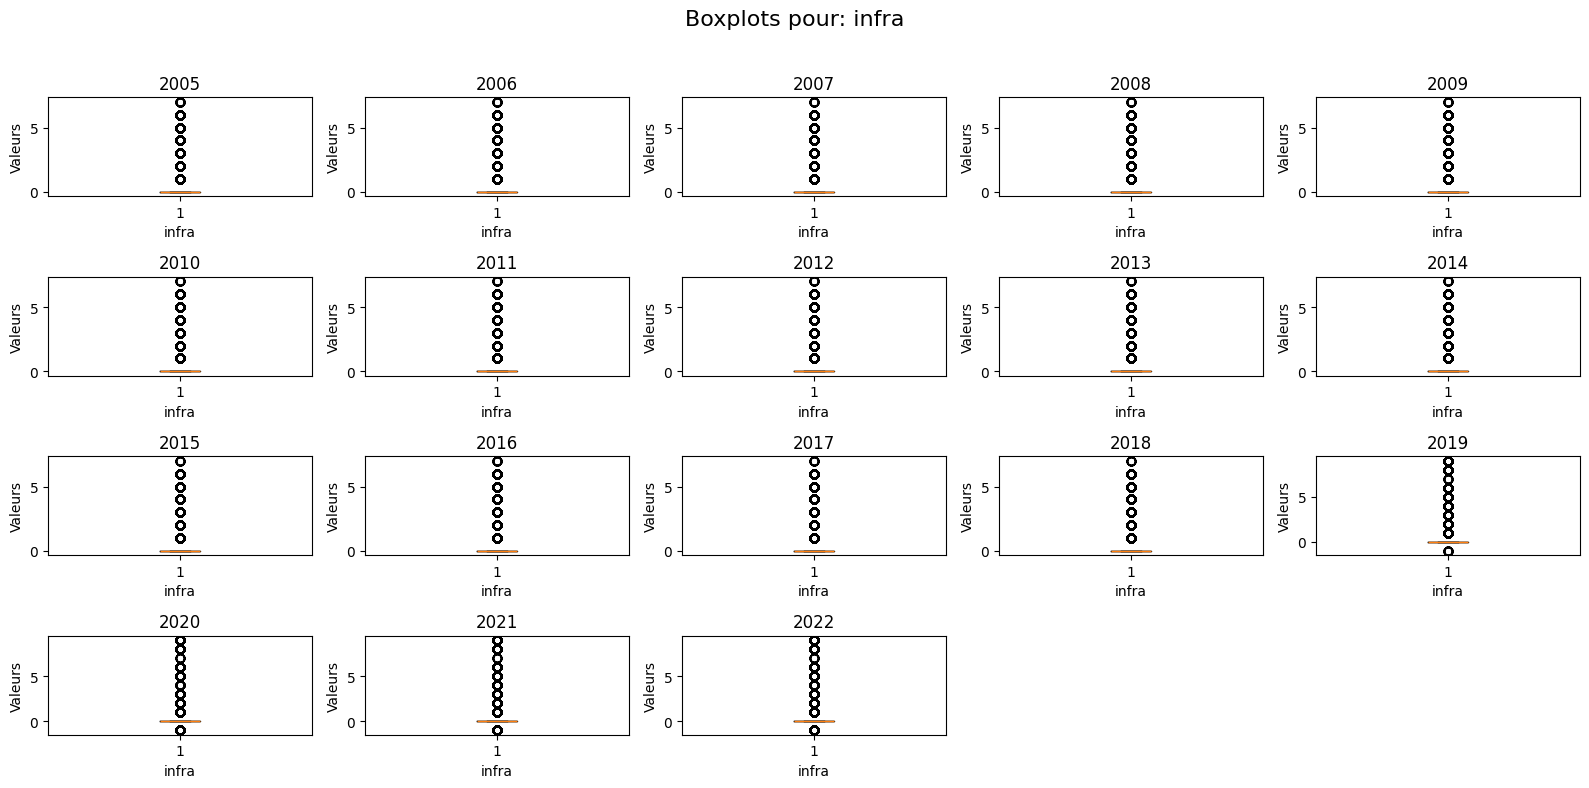

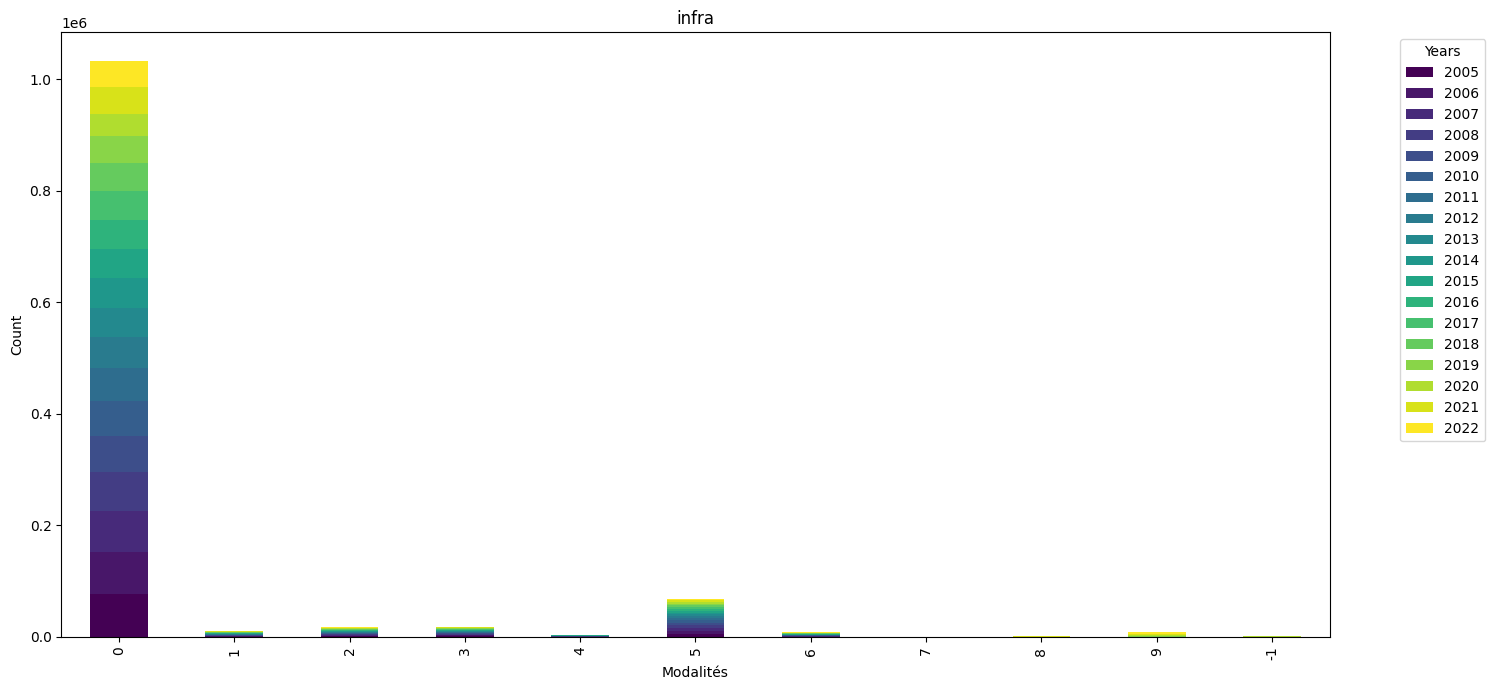

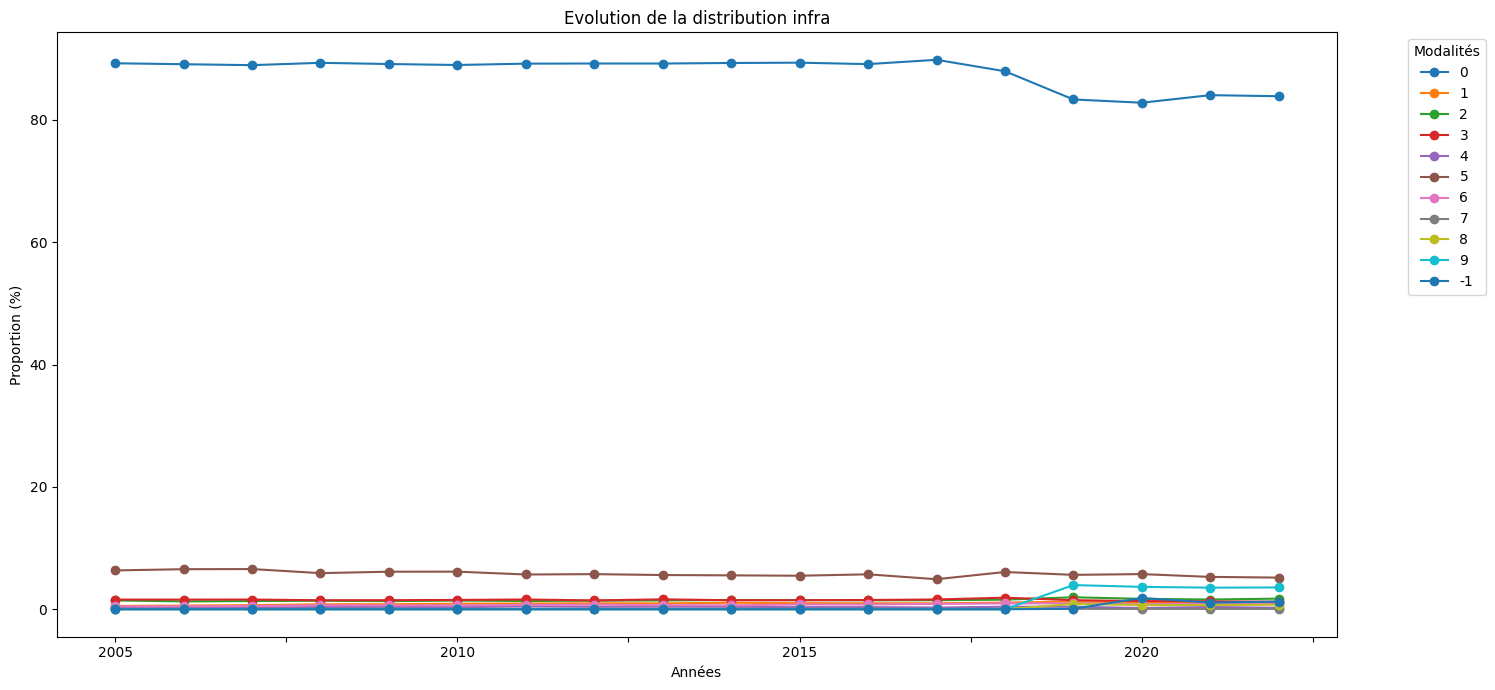

2024-11-25 11:21:10,916 - INFO - Pas de description pour `v2` dans la section `LIEUX`.
2024-11-25 11:21:10,919 - INFO - La colonne v2 n'est pas numérique.
2024-11-25 11:21:10,946 - WARNING - Le nombre de modalités uniques dans la colonne v2 excède le seuil de 50. Auncun bar plot généré.
2024-11-25 11:21:11,018 - WARNING - Le nombre de modalités uniques dans la colonne v2 excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  A                                     97.5456                            0.0721318
   2006  object  A                                     93.7127                            0.0660861
   2007  object  A                                     93.8831                            0.06689
   2008  object  A                                     94.5419                            0.0616694
   2009  object  A                                     95.5731                            0.0604271
   2010  object  A                                     97.0596                            0.0572186
   2011  object  A                                     96.9988                            0.0552005
   2012  object  0                                     96.1012                       

Résumé pour usagers_data/raw\usagers_2005.csv:
Total Rows: 197498, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      0.00
catu       0.00
grav       0.00
sexe       0.00
trajet     0.00
secu       0.00
locp       0.00
actp       0.00
etatp      0.00
an_nais    0.35
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200500043044
place                 1
catu                  1
grav                  1
sexe                  1
trajet                5
secu                 11
locp                  0
actp                  0
etatp                 0
an_nais          1985.0
num_veh             A01
Name: 0, dtype: object


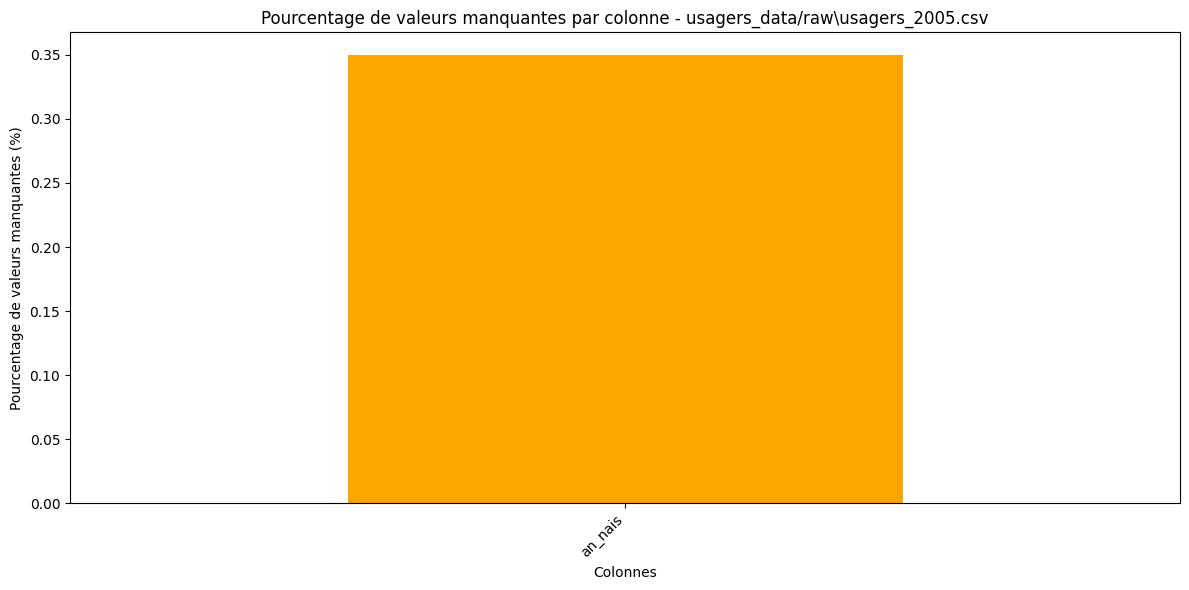

Résumé pour usagers_data/raw\usagers_2006.csv:
Total Rows: 187085, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      0.00
catu       0.00
grav       0.00
sexe       0.00
trajet     0.00
secu       0.00
locp       0.00
actp       0.00
etatp      0.00
an_nais    0.56
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200600016834
place                 1
catu                  1
grav                  1
sexe                  1
trajet                5
secu               11.0
locp                  0
actp                  0
etatp                 0
an_nais          1986.0
num_veh             A01
Name: 0, dtype: object


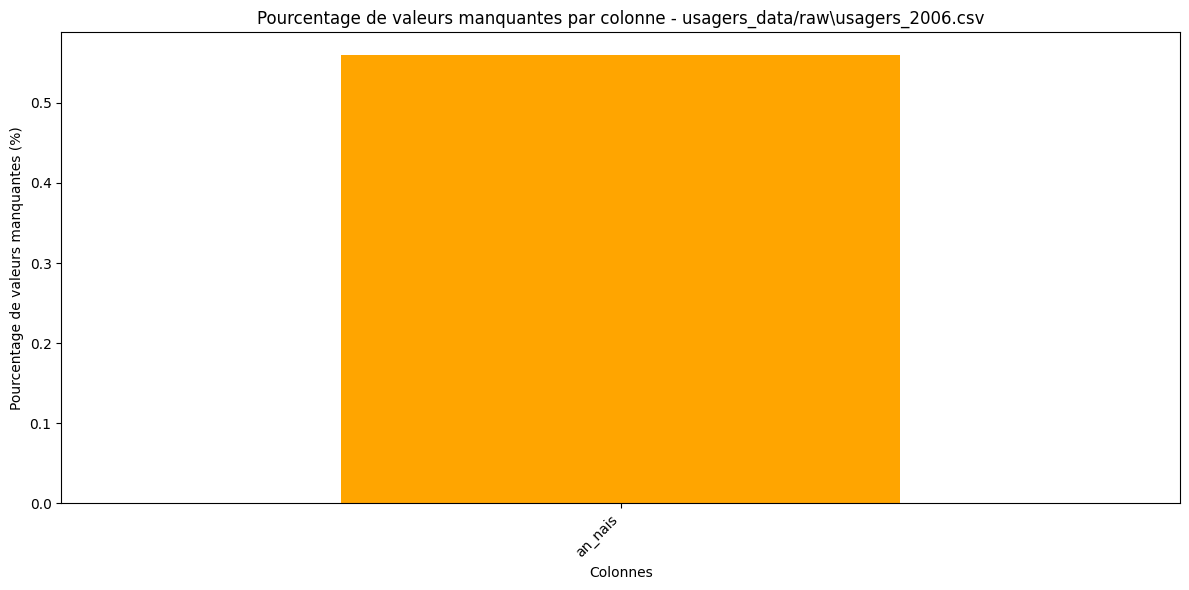

Résumé pour usagers_data/raw\usagers_2007.csv:
Total Rows: 188457, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      0.00
catu       0.00
grav       0.00
sexe       0.00
trajet     0.00
secu       0.00
locp       0.00
actp       0.00
etatp      0.00
an_nais    0.16
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200700051728
place                 1
catu                  1
grav                  1
sexe                  1
trajet                0
secu                 11
locp                  0
actp                  0
etatp                 0
an_nais          1987.0
num_veh             A01
Name: 0, dtype: object


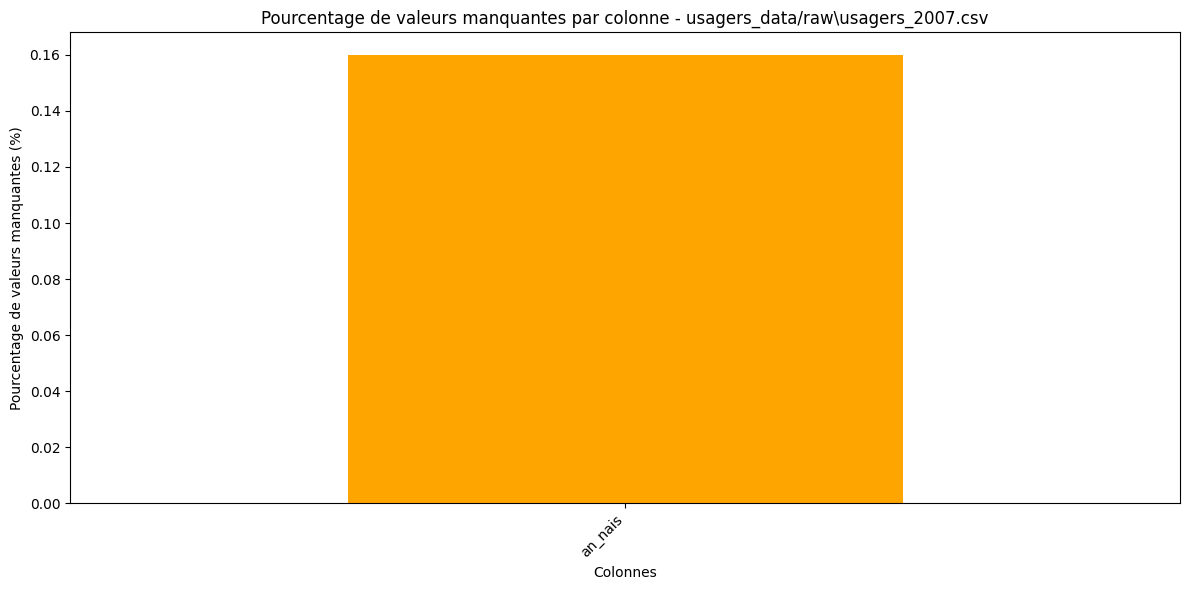

Résumé pour usagers_data/raw\usagers_2008.csv:
Total Rows: 170960, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      0.00
catu       0.00
grav       0.00
sexe       0.00
trajet     0.00
secu       0.00
locp       0.00
actp       0.00
etatp      0.00
an_nais    0.03
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200800007145
place                 1
catu                  1
grav                  1
sexe                  1
trajet                0
secu                 11
locp                  0
actp                  0
etatp                 0
an_nais          1989.0
num_veh             A01
Name: 0, dtype: object


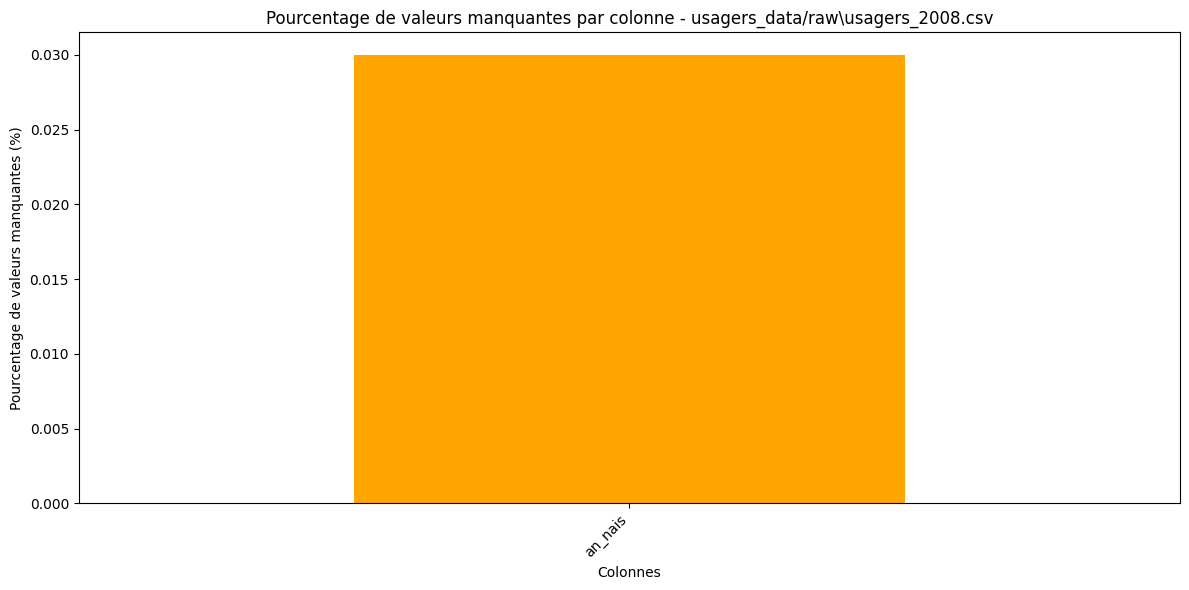

Résumé pour usagers_data/raw\usagers_2009.csv:
Total Rows: 165962, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      8.21
catu       0.00
grav       0.00
sexe       0.00
trajet     0.06
secu       3.02
locp       0.36
actp       0.36
etatp      0.34
an_nais    0.01
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    200900015540
place               1.0
catu                1.0
grav                1.0
sexe                1.0
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1988.0
num_veh             A01
Name: 0, dtype: object


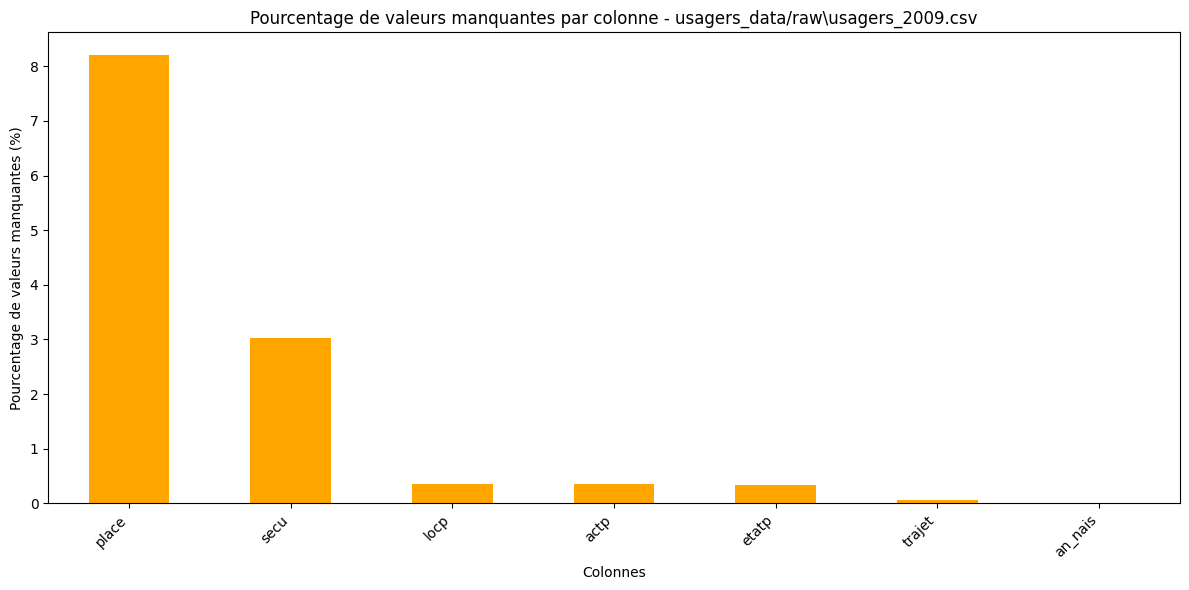

Résumé pour usagers_data/raw\usagers_2010.csv:
Total Rows: 154192, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      8.58
catu       0.00
grav       0.00
sexe       0.00
trajet     0.04
secu       2.72
locp       0.15
actp       0.16
etatp      0.14
an_nais    0.03
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201000004616
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1989.0
num_veh             A01
Name: 0, dtype: object


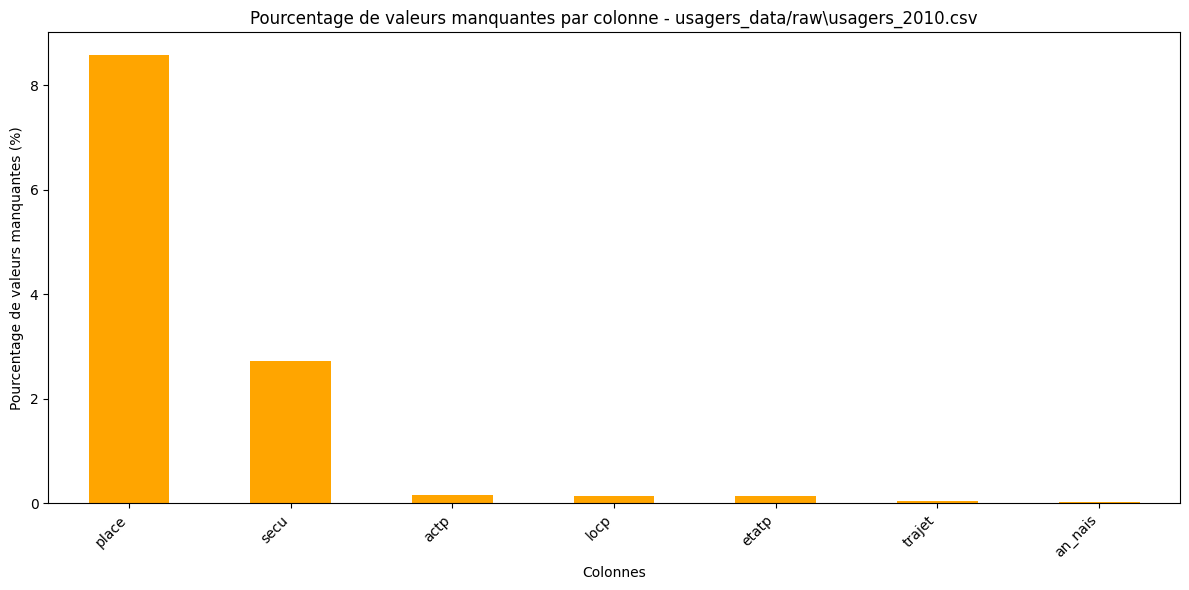

Résumé pour usagers_data/raw\usagers_2011.csv:
Total Rows: 148543, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      8.81
catu       0.00
grav       0.00
sexe       0.00
trajet     0.04
secu       3.03
locp       0.15
actp       0.16
etatp      0.15
an_nais    0.04
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201100052545
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1990.0
num_veh             A01
Name: 0, dtype: object


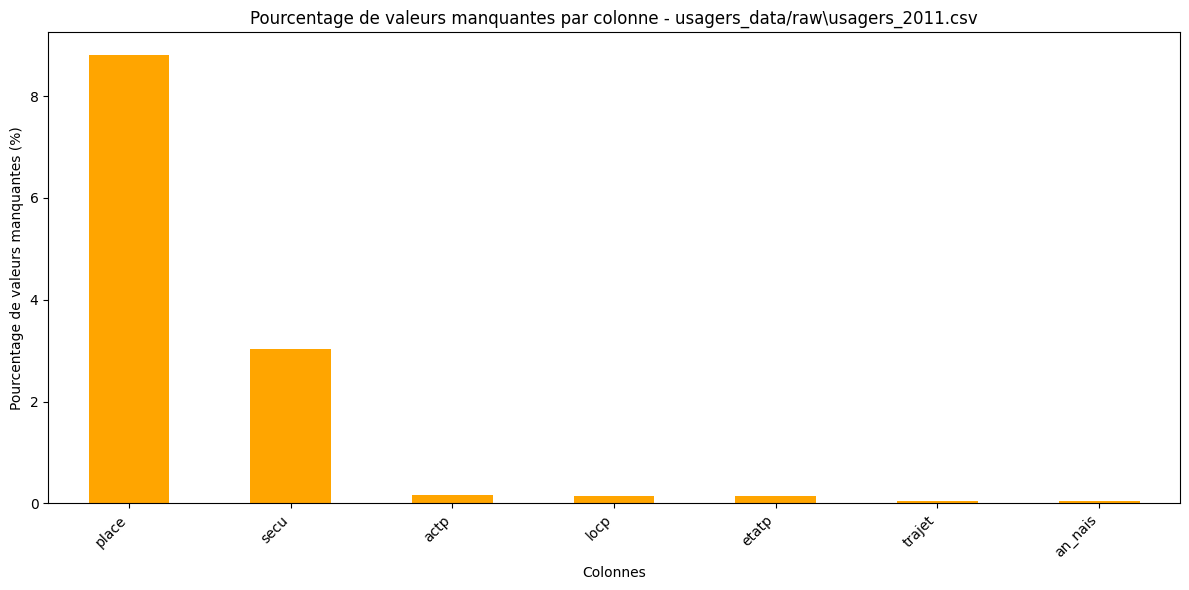

Résumé pour usagers_data/raw\usagers_2012.csv:
Total Rows: 138628, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      8.92
catu       0.00
grav       0.00
sexe       0.00
trajet     0.04
secu       3.05
locp       0.12
actp       0.12
etatp      0.12
an_nais    0.01
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201200012891
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1990.0
num_veh             A01
Name: 0, dtype: object


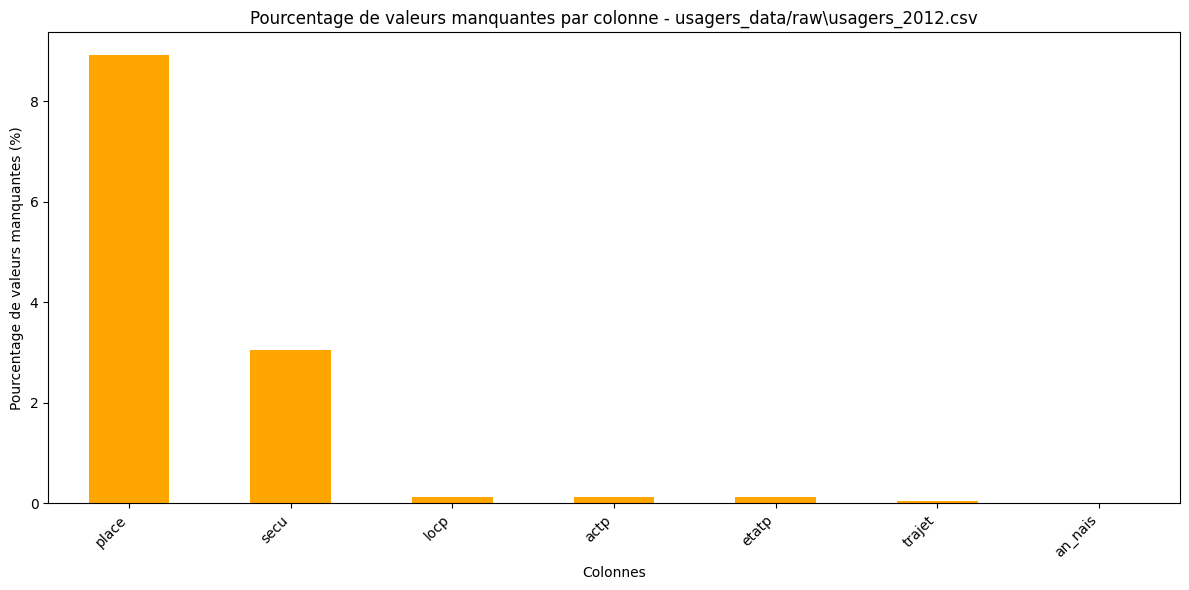

Résumé pour usagers_data/raw\usagers_2013.csv:
Total Rows: 128694, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      9.35
catu       0.00
grav       0.00
sexe       0.00
trajet     0.02
secu       3.11
locp       0.09
actp       0.11
etatp      0.12
an_nais    0.03
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201300011818
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1992.0
num_veh             A01
Name: 0, dtype: object


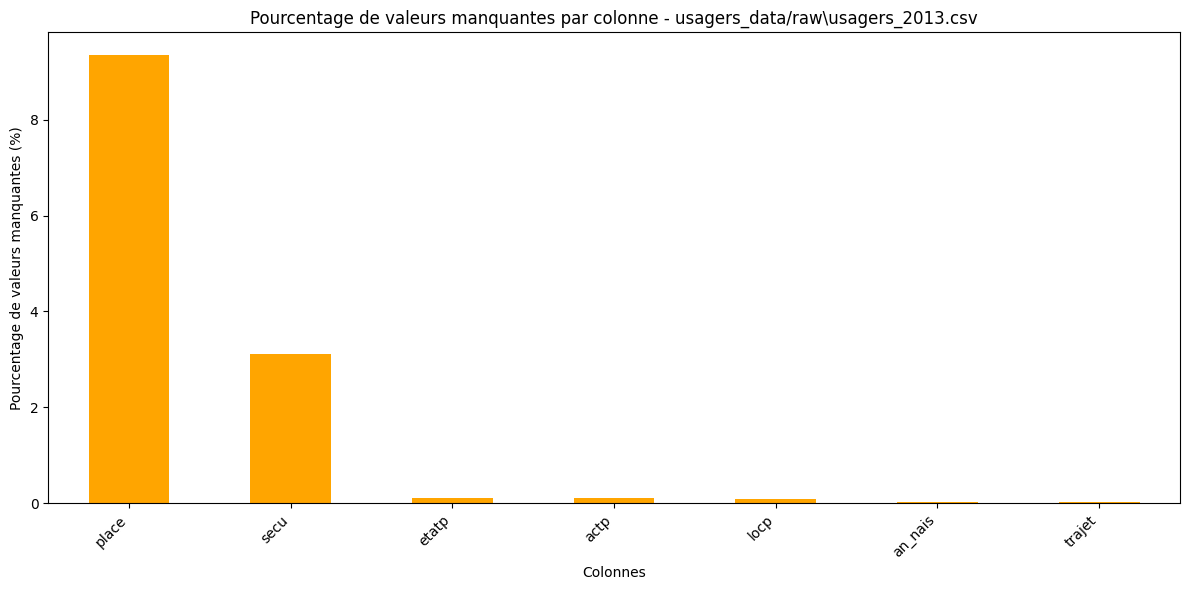

Résumé pour usagers_data/raw\usagers_2014.csv:
Total Rows: 132186, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      9.29
catu       0.00
grav       0.00
sexe       0.00
trajet     0.03
secu       3.05
locp       0.11
actp       0.14
etatp      0.13
an_nais    0.01
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201400019604
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1992.0
num_veh             A01
Name: 0, dtype: object


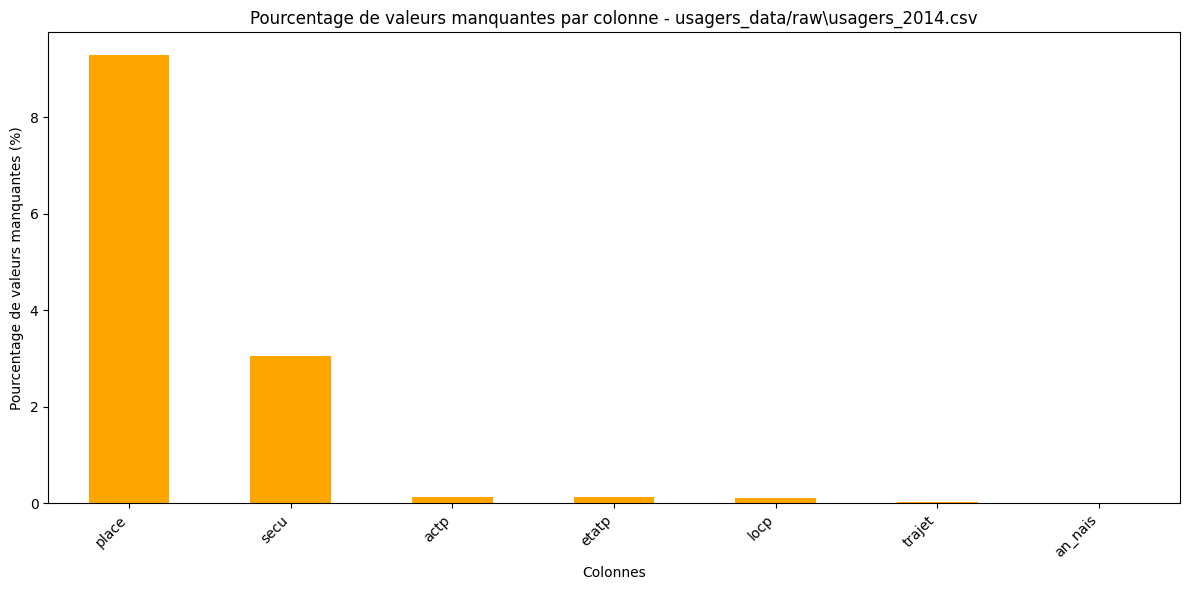

Résumé pour usagers_data/raw\usagers_2015.csv:
Total Rows: 130378, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      9.12
catu       0.00
grav       0.00
sexe       0.00
trajet     0.01
secu       6.24
locp       0.07
actp       0.08
etatp      0.08
an_nais    0.02
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201500018462
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1994.0
num_veh             A01
Name: 0, dtype: object


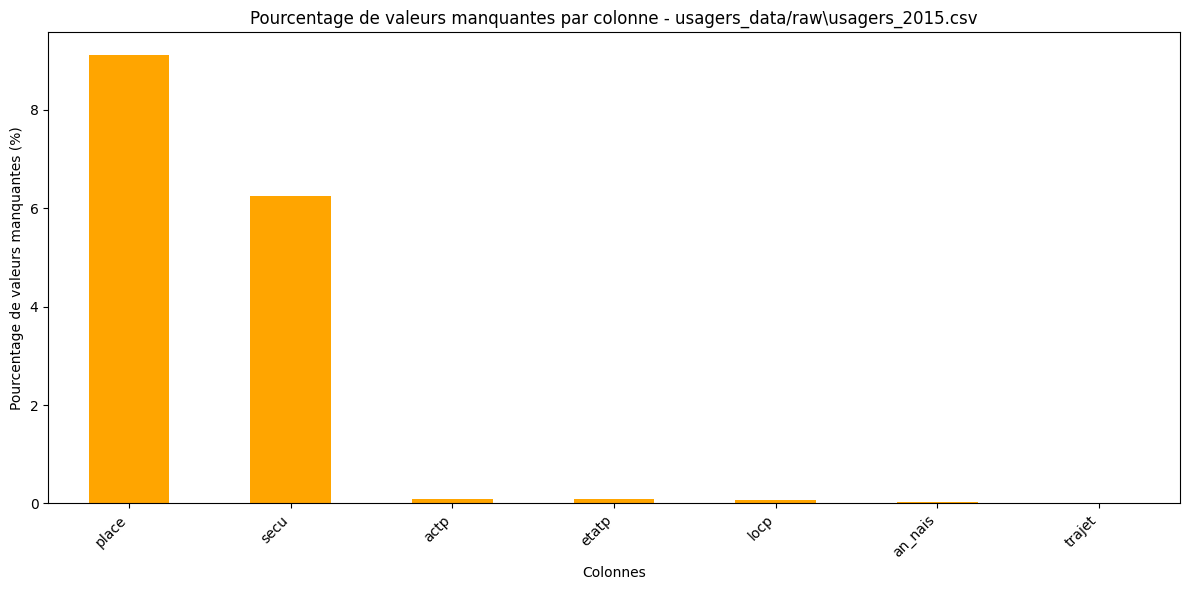

Résumé pour usagers_data/raw\usagers_2016.csv:
Total Rows: 133422, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      8.87
catu       0.00
grav       0.00
sexe       0.00
trajet     0.01
secu       7.02
locp       0.07
actp       0.07
etatp      0.07
an_nais    0.02
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201600002473
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1995.0
num_veh             A01
Name: 0, dtype: object


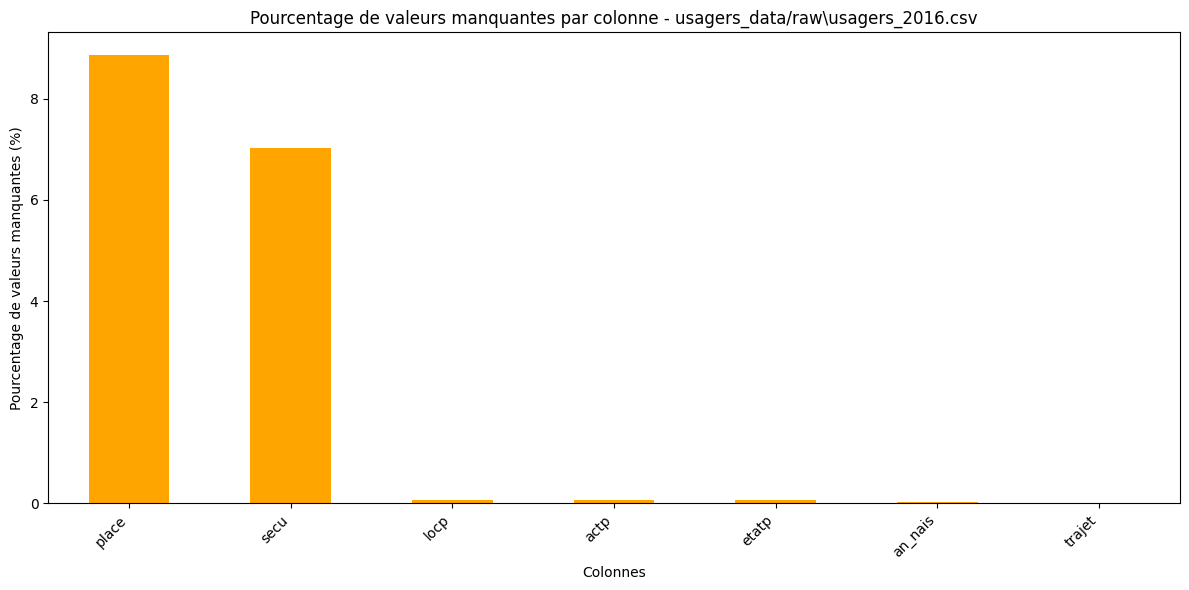

Résumé pour usagers_data/raw\usagers-2017.csv:
Total Rows: 136021, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc    0.00
place      8.68
catu       0.00
grav       0.00
sexe       0.00
trajet     0.01
secu       6.58
locp       0.03
actp       0.03
etatp      0.05
an_nais    0.03
num_veh    0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201700018713
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1997.0
num_veh             A01
Name: 0, dtype: object


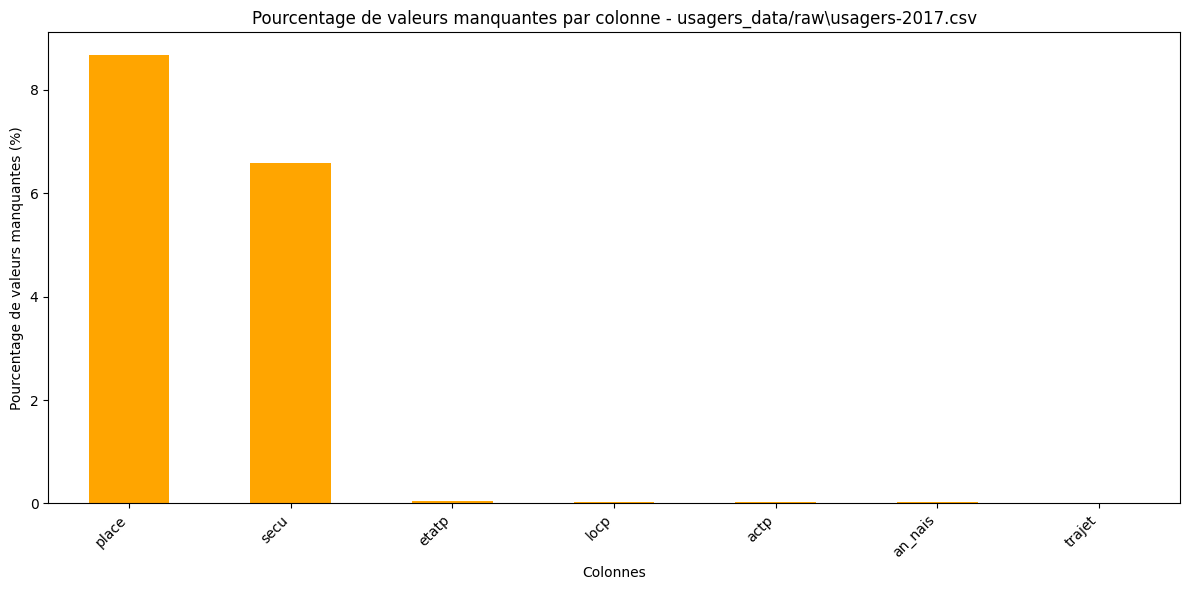

Résumé pour usagers_data/raw\usagers-2018.csv:
Total Rows: 130169, Total Columns: 12
Pourcentage de valeurs manquantes par colonne:
Num_Acc     0.00
place       8.42
catu        0.00
grav        0.00
sexe        0.00
trajet      0.09
secu        3.17
locp       41.98
actp       41.98
etatp      41.98
an_nais     0.02
num_veh     0.00
dtype: float64
Valeurs les plus fréquentes:
Num_Acc    201800017680
place               1.0
catu                  1
grav                  1
sexe                  1
trajet              5.0
secu               11.0
locp                0.0
actp                0.0
etatp               0.0
an_nais          1998.0
num_veh             A01
Name: 0, dtype: object


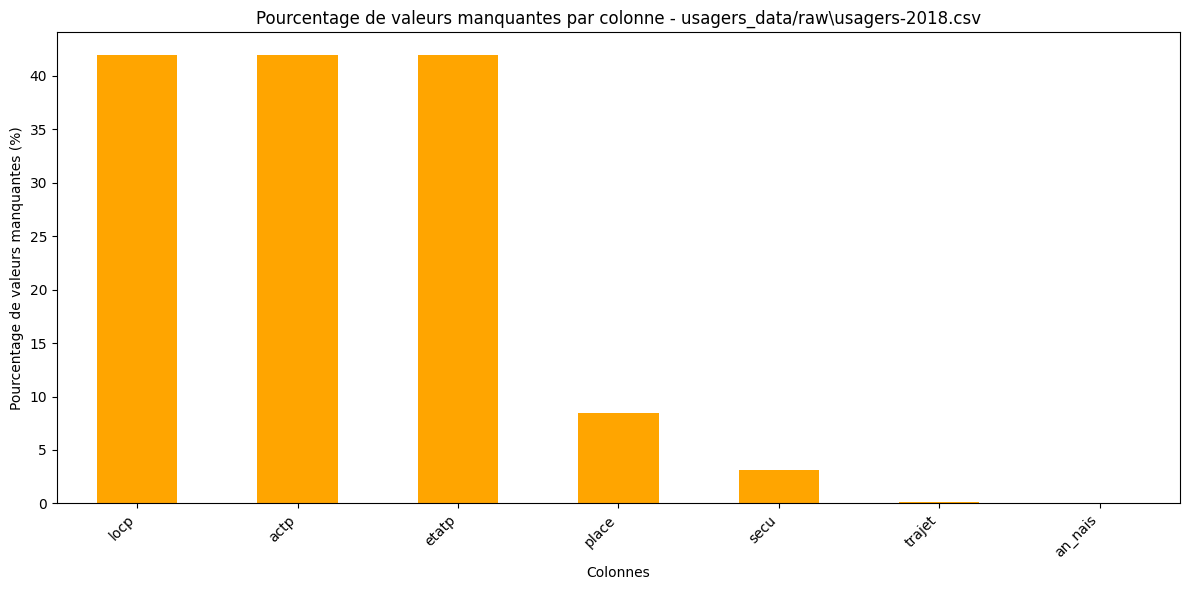

Résumé pour usagers_data/raw\usagers-2019.csv:
Total Rows: 132977, Total Columns: 15
Pourcentage de valeurs manquantes par colonne:
Num_Acc        0.0
id_vehicule    0.0
num_veh        0.0
place          0.0
catu           0.0
grav           0.0
sexe           0.0
an_nais        0.0
trajet         0.0
secu1          0.0
secu2          0.0
secu3          0.0
locp           0.0
actp           0.0
etatp          0.0
dtype: float64
Valeurs les plus fréquentes:
Num_Acc        201900049689
id_vehicule     138 212 691
num_veh                 A01
place                     1
catu                      1
grav                      1
sexe                      1
an_nais                2000
trajet                    5
secu1                     1
secu2                     0
secu3                    -1
locp                      0
actp                      0
etatp                    -1
Name: 0, dtype: object


IndexError: index 0 is out of bounds for axis 0 with size 0

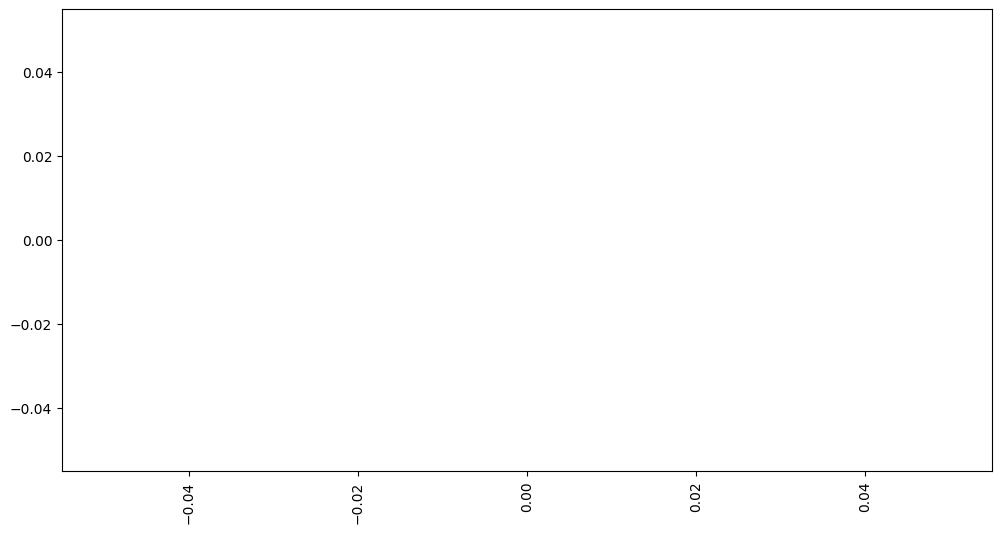

In [ ]:
with open(PATH_TO_JSON, encoding= 'utf-8') as f:
    descvar = json.load(f)

for dataset_name, datasets in zip(prefixes, dataframes):
    # Résumé de chaque fichier
    for dataset in datasets: 
        summarize_dataset(dataset, dataset_name)
        
    # Analyse de chaque colonne
    analyze_all_columns(datasets, dataset_name, descvar= descvar)